<a href="https://colab.research.google.com/github/mrpc25/TaikoLevelModel/blob/main/%E5%A4%AA%E9%BC%93%E8%AD%9C%E9%9D%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用方法
1.上傳譜面
*   上傳檔案後，複製檔案名字（不包括附檔名），貼到「載入譜面」儲存格裡的"file_name"
2.未載入同一個譜面檔案時：
*   （一）直接點選「執行階段/全部執行」（快捷鍵:Ctrl+F9）
*   （二）過程中會有兩次可能需要使用者輸入的時候，分別為「難度/雙人」和「分歧狀態」
*   （三）如果在這個階段發生錯誤，可以試試將譜面打開再儲存(Ctrl+S)一次
3.想要讀取同一個譜面檔案當中的其他譜面：
*   （一）如果是要重新選擇「難度/雙人」，那麼「依照難度、星級、雙人與否選擇譜面」本身開始到功能區之前的儲存格都要依序點選
*   （二）如果是要重新選擇「分歧狀態」，那麼「選擇分歧譜面（也可能沒有）」本身開始到功能區之前的儲存格都要依序點選




#目前可能無法解決的問題:
1. 目前不確定譜面分歧的指令是否可以寫在小節內（也就是不從開頭）開始

        目前測試，次郎1似乎是的確沒有辦法這樣做，也因為技術上的問題，以下的程式是建立在「譜面分歧只能寫在小節開頭」的前提上。
        如果輸入的譜面含有這項特徵，有可能會導致執行錯誤或得到錯誤結果

2. HSCcroll/BMScroll
        
        因為不會寫¯\_(ツ)_/¯，真的是理解層面上的無法參透。

3. 之前提到的複合難度定義問題

        可能同時包含概念問題和技術問題:
        曾經想過是否要用同密度下的咚咔變化率來表示，但舉個大部分普遍認知下的反例:
        「⚪⚫⚪⚫⚪⚫⚪⚫⚪」並不會比「⚫⚪⚪⚫⚪⚪⚫⚪⚫」還難打，但前者的咚咔變化反而較多。

        還有非同一個密度下的長串，例如"16+24"、16+12"、16+32"、"8+12"等等。
        計算上其實有點複雜，可能要先定義達到多少密度以上的才叫做複合。


In [129]:
# @title 載入譜面
# @title
如果執行這裡有發生錯誤代表有順利清除變數 = None

try:
  abcdefg123456789blahblahblah = HaveDownLoadedNodel
except:
  HaveDownLoadedNodel = False
file_name = "さいたま2000" #@param {type:"string"}
codec = "unicode_escape" # @param ["utf_8", "ascii", "shift_jis", "big5", "hz", "unicode_escape"] {allow-input: true}

with open(file_name + ".tja", mode='r' ,encoding = codec) as f:
  words_raw = f.read()

#按行將原始檔案做切割
EveryRow = []
TempRow = ""
for char in words_raw:
    if(char!="\n"):
        TempRow = TempRow + char
    else:
        EveryRow.append(TempRow)
        TempRow = ""
EveryRow.append(TempRow)

print(f">>> Currently Loading Song File:\"{file_name}.tja\" in codec \"{codec}\"")

>>> Currently Loading Song File:"さいたま2000.tja" in codec "unicode_escape"


**因為語言問題，編碼問題會影響載入時的問題，如果發生問題可以依照對照以下選擇編碼（預設是**"utf_8"）：
1. 部分的簡單對照表:

        english <-> ascii
        japanese(日本語) <-> shift_jis
        Simplified Chinese(简体中文) <-> hz
        Traditional Chinese(繁體中文) <-> big5
        能載入，但可能會有亂碼 <-> unicode_escape
2. 如果還是發生錯誤:
  詳情請參照"[codecs — Codec registry and base classes](https://docs.python.org/3/library/codecs.html#codecs.StreamRecoder)"中提到的其他編碼，並自行輸入更換。

# 譜面預處理+譜面前資訊

In [130]:
#定義在指定的行內（範圍），是否有出現過特定文字，並輸出所有含有該特定文字的所在行數，形式是List
def FindPhraseInRow(Phrase, Coverage=[0, len(EveryRow)]):
    Order = []
    for i in range(Coverage[0],Coverage[1]):
        if(EveryRow[i].find(Phrase)!=-1):
            Order.append(i)
    return Order

def FindPhraseInRowRev(Phrase, Coverage=[0, len(EveryRow)]):
    Order = []
    for i in range(Coverage[0],Coverage[1]):
        if(EveryRow[i].rfind(Phrase)!=-1):
            Order.append(i)
    return Order

In [131]:
#尋找特定字詞所在地，在那個字詞之後出現的字詞，並去除在註解符號"//"後的部分
def OffsetThingsValue(Phrase,Range):
     PhraseInRegion = FindPhraseInRow(Phrase,Range)
     output = ""
     if(len(PhraseInRegion)>0):
          Observed = EveryRow[PhraseInRegion[0]]
          Anno = Observed.find("//")
          lebr = Observed.find("(")
          if(Anno == -1 and lebr == -1):
               EndLocation = len(Observed)
          elif(Anno == -1):
               EndLocation = lebr
          elif(lebr == -1):
               EndLocation = Anno
          else:
            if(lebr<Anno):
               EndLocation = lebr
            else:
               EndLocation = Anno

          for i in range(Observed.find(Phrase)+len(Phrase),EndLocation):
               output = output + Observed[i]
     return output

def OffsetThingsValueRev(Phrase,Range):
     PhraseInRegion = FindPhraseInRowRev(Phrase,Range)
     output = ""
     if(len(PhraseInRegion)>0):
          Observed = EveryRow[PhraseInRegion[0]]
          Anno = Observed.find("//")
          if(Anno == -1):
               EndLocation = len(Observed)
          else:
               EndLocation = Anno
          for i in range(Observed.find(Phrase)+len(Phrase),EndLocation):
               output = output + Observed[i]
     return output

In [132]:
#先尋找所有難度以及星級
Song_Difficulty = FindPhraseInRow("COURSE:")
Song_level = FindPhraseInRow("LEVEL:")
Song_IsDual = []
for location in Song_Difficulty:
  if(location==Song_Difficulty[0]):
    Song_IsDual.append(OffsetThingsValue("STYLE:",[0,FindPhraseInRow("#START",[location+1,len(EveryRow)])[0]]))
  else:
    Song_IsDual.append(OffsetThingsValue("STYLE:",[FindPhraseInRowRev("#END",[0,location])[0],FindPhraseInRow("#START",[location+1,len(EveryRow)])[0]]))


In [133]:
#判斷這份譜面檔案當中是否含有任何一個是雙人譜面的難度
IsAnyDual = False
for IsDualState in Song_IsDual:
  IsDualState = IsDualState.replace(" ", "")
  if(IsDualState=="2" or IsDualState=="Double" or IsDualState=="double"):
    IsAnyDual = True
    break

In [134]:
Song_Begin = FindPhraseInRow("#START")
Song_Endin = FindPhraseInRow("#END")
Song_Pre = []
for EachEnd in Song_Endin:
  if(EachEnd!=Song_Endin[0]):
    Song_Pre.append(Temp+1)
  else:
    Song_Pre.append(0)
  Temp = EachEnd

if(IsAnyDual==False):
  Song_Begin_P1 = []
  Song_Begin_P2 = []

else:
  # for i in range(len(Song_Difficulty)):
  #   if(i==0):
  #     Song_IsDual.append(OffsetThingsValue("STYLE:",[0,FindPhraseInRow("#START",[location+1,len(EveryRow)])[0]]))
  #   else:
  #     Song_IsDual.append(OffsetThingsValue("STYLE:",[FindPhraseInRowRev("#END",[0,location])[0],FindPhraseInRow("#START",[location+1,len(EveryRow)])[0]]))
  #   if(Song_IsDual[i].replace(" ", "")=="2" or Song_IsDual[i].replace(" ", "")=="Double" ):
  #     Song_Difficulty.insert(i,Song_Difficulty[i])
  #     Song_level.insert(i,Song_level[i])

  for j in range(len(Song_Pre)):
    if(len(OffsetThingsValue("COURSE:", [Song_Pre[j], Song_Begin[j]]).replace(" ", ""))==0):
      Song_Difficulty.insert(j,Temp_Difficulty)
      Song_level.insert(j,Temp_level)
    else:
      Temp_Difficulty = Song_Difficulty[j]
      Temp_level = Song_level[j]

if(len(Song_Begin)!=len(Song_Endin)):
  raise Exception("Please check if the #START(P1/P2) and #END commands used correctly, and then restart.")

# 載入音源

In [135]:
# @title
IfAudioNeeded = False # @param {type:"boolean"}
audio_name = OffsetThingsValue("WAVE:",[0, len(EveryRow)])
import soundfile as sf

if(IfAudioNeeded):
  try:
    with open(audio_name, 'rb') as f:
        data, samplerate = sf.read(f)
        AudioLength = len(data)/samplerate
    print(f">>> Currently Loading Audio File:\"{audio_name}\"")
  except:
    IfAudioNeeded = False
    print(">>> Fail to Read Audio File:\"{audio_name}\"")
else:
  print(">>> No Audio")

>>> No Audio


# 依照難度、星級、雙人與否選擇譜面

In [136]:
# @title
if(IsAnyDual==False):
  print(f"There are {len(Song_Begin)} Fumen(s) has been dectected and displayed below:")
  print("\n\t\tDifficulty\tLevel\n")

  for i in range(len(Song_Begin)):
    if(i!=0):
      difficulty = OffsetThingsValue("COURSE:", [Song_Endin[i-1]+1, Song_Begin[i]])
      level = OffsetThingsValue("LEVEL:", [Song_Endin[i-1]+1, Song_Begin[i]])
    else:
      difficulty = OffsetThingsValue("COURSE:", [0, Song_Begin[0]])
      level = OffsetThingsValue("LEVEL:", [0, Song_Begin[0]])
    difficulty = difficulty.replace(" ", "")
    if(difficulty=="4" or difficulty.lower()=="edit"):
      difficulty = "Edit"
    elif(difficulty=="3" or difficulty.lower()=="oni"):
      difficulty = "Oni"
    elif(difficulty=="2" or difficulty.lower()=="hard"):
      difficulty = "Hard"
    elif(difficulty=="1" or difficulty.lower()=="normal"):
      difficulty = "Normal"
    elif(difficulty=="0" or difficulty.lower()=="easy"):
      difficulty = "Easy"
    elif(difficulty==""):
      difficulty = "N/A"
    print(f"\t{i}\t{difficulty}\t\t{level}")

else:
  print(f"There are {len(Song_Begin)} Fumen(s) has been dectected and displayed below:")
  print("\n\t\tDifficulty\tDual\tLevel\n")

  for i in range(len(Song_Begin)):
    difficulty = OffsetThingsValue("COURSE:", [Song_Difficulty[i], Song_Difficulty[i]+1])
    difficulty = difficulty.replace(" ", "")
    if(difficulty=="4" or difficulty.lower()=="edit"):
      difficulty = "Edit"
    elif(difficulty=="3" or difficulty.lower()=="oni"):
      difficulty = "Oni"
    elif(difficulty=="2" or difficulty.lower()=="hard"):
      difficulty = "Hard"
    elif(difficulty=="1" or difficulty.lower()=="normal"):
      difficulty = "Normal"
    elif(difficulty=="0" or difficulty.lower()=="easy"):
      difficulty = "Easy"
    elif(difficulty==""):
      difficulty = "N/A"


    level = OffsetThingsValue("LEVEL:", [Song_level[i], Song_level[i]+1])

    StringOfSTART = OffsetThingsValue("#START",[Song_Begin[i],Song_Begin[i]+1])
    dualstatestr = ""
    for x in StringOfSTART:
      if(x=="P" or x=="1" or x=="2"):
        dualstatestr = dualstatestr + x

    if(dualstatestr=="P1"):
      dual = "P1"
    elif(dualstatestr=="P2"):
      dual = "P2"
    else:
      dual = "-"

    print(f"\t{i}\t{difficulty}\t\t{dual}\t{level}")

if(len(Song_Begin)==1):
  UserChosenFumen = 0
  print("\n>>> The loading process has sucessfully been done.")
elif(len(Song_Begin)>=2):
  while(True):
    UserChosenFumen = input("\nType in corresponding (at leftmost) symbol to choose a difficulty amd press Enter:\t")
    UserChosenFumen = UserChosenFumen.replace(" ", "")
    if(str.isnumeric(UserChosenFumen)):
      UserChosenFumen = int(UserChosenFumen)
      if(UserChosenFumen >= 0 and UserChosenFumen < len(Song_Begin)):
        print("\n>>> The loading process has sucessfully been done.")
        break
      print("\n>>> Invalid input, please make sure that imput is corresponding to numbers displayed at the leftmost side.")
    else:
      print("\n>>> Invalid input, please make sure that imput is at least a number.")

There are 4 Fumen(s) has been dectected and displayed below:

		Difficulty	Level

	0	Oni		7
	1	Hard		7
	2	Normal		7
	3	Easy		5

Type in corresponding (at leftmost) symbol to choose a difficulty amd press Enter:	0

>>> The loading process has sucessfully been done.


# 譜面內資訊

In [137]:
EveryBar = []          #每個小節的內容
EveryBarRowLocation = []    #每個小節所在的行數(位置)
CurrentMeasure = ""         #每次迴圈內暫存的小節內容
CurrentMeasureRowLocation = []   #每次迴圈內暫存的小節位置

if(UserChosenFumen>=0):
  if(UserChosenFumen==0):
    ChosenReady = 0
  else:
    ChosenReady = Song_Endin[UserChosenFumen-1]
  ChosenBegin = Song_Begin[UserChosenFumen]
  ChosenEndin = Song_Endin[UserChosenFumen]

for i in range(ChosenBegin+1,ChosenEndin):

    #檢查該小節是否有註解用的"//"符號，並記錄位置
    Annotation = EveryRow[i].find("//")

    #檢查該小節是否有譜面功能用的"#"符號，並記錄位置
    if(Annotation==-1):
        FunctionUsage = EveryRow[i].find("#")
    else:
        FunctionUsage = EveryRow[i].find("#", 0, Annotation)

    #判斷是否有使用函式"#"
    if(FunctionUsage==-1):
        for j in range(len(EveryRow[i])):
            if(EveryRow[i][j]!=","):

                #確認這一行文字中有沒有註解用的"//"
                if(Annotation==-1):
                  #逐一檢視小節當中的字元，是數字就紀錄
                  if(str.isnumeric(EveryRow[i][j])):
                        #紀錄實際的字元
                        CurrentMeasure = CurrentMeasure + EveryRow[i][j]

                        #記錄這個字源所在的行
                        CurrentMeasureRowLocation.append(i)
                else:
                  #逐一檢視小節當中的字元，是數字且是註解記號以前的文字就紀錄
                  if(str.isnumeric(EveryRow[i][j]) and j<Annotation):
                        #紀錄實際的字元
                        CurrentMeasure = CurrentMeasure + EveryRow[i][j]

                        #記錄這個字源所在的行
                        CurrentMeasureRowLocation.append(i)
            else:
                CurrentMeasure = CurrentMeasure + EveryRow[i][j]
                CurrentMeasureRowLocation.append(i)

                #小節結束時，暫時紀錄的str輸出到另外一個list，再讓暫時紀錄的str清空。
                EveryBar.append(CurrentMeasure)
                CurrentMeasure = ""

                #小節結束時，暫時紀錄的str行位置輸出到另外一個list，再讓暫時紀錄清空。
                EveryBarRowLocation.append(CurrentMeasureRowLocation)
                CurrentMeasureRowLocation = []

EveryBarWithoutComma = []
for Bar in EveryBar:
  BarWithoutComma = ""
  for i in range(len(Bar)-1):
    BarWithoutComma = BarWithoutComma + Bar[i]
  EveryBarWithoutComma.append(BarWithoutComma)

In [138]:
#每個小節開始時在檔案內所位於的行數
BarBeginLoaction = []
temp = EveryBarRowLocation[0][0]
BarBeginLoaction.append(temp)
for bar in EveryBarRowLocation:
    for notesLocation in bar:
        if(notesLocation != temp):
            temp = notesLocation
            BarBeginLoaction.append(temp)

In [139]:
temp = None
BarLocation = []
for bar in EveryBarRowLocation:
    #針對同一個小節，找出所有notes出現過的行數。
    NotesInBarLocation = []
    for notesLocation in bar:
        #紀錄同一個小節內的每個notes，是否有出現過不同的行數，有的話就做紀錄
        if(notesLocation != temp):
            temp = notesLocation
            NotesInBarLocation.append(temp)
    #記錄所有小節的結果
    BarLocation.append(NotesInBarLocation)

In [140]:
def Find_Scroll_Of_EachNotesInLoaction():
  LastLocation = ChosenBegin
  MeasureInfo = []
  TempContent = "1" #預設值1
  for MeasureLocationList in EveryBarRowLocation:
    NotesInfo = []
    for NotesLocation in MeasureLocationList:
      Content = OffsetThingsValue("#SCROLL",[LastLocation,NotesLocation])
      if(Content!="" and not str.isspace(Content)):
        TempContent = ""
        for char in Content:
          if(str.isnumeric(char) or char=="+" or char=="-" or char=="." or char=="i"):
            if(char != "i"):
                TempContent = TempContent + char
            else:
                TempContent = TempContent + "j"
        #TempContent = complex(TempContent) #複數譜面會有虛數
      TempContent = complex(TempContent) #同BPM作法

      NotesInfo.append(TempContent)
      LastLocation = NotesLocation
    MeasureInfo.append(NotesInfo)
  return MeasureInfo

In [141]:
def Find_BPM_Of_EachNotesInLoaction():
  LastLocation = ChosenBegin
  MeasureInfo = []
  TempContent = OffsetThingsValue("BPM:",[ChosenReady,ChosenBegin]) #預設使用譜面開始前設定的BPM
  if(TempContent==""):
    TempContent = OffsetThingsValue("BPM:",[0, Song_Begin[0]]) #沒有該譜面自設定的BPM，則沿用譜面檔案一開始能找到的數值

  for MeasureLocationList in EveryBarRowLocation:
    NotesInfo = []
    for NotesLocation in MeasureLocationList:
      Content = OffsetThingsValue("#BPMCHANGE",[LastLocation,NotesLocation])
      if(Content!="" and not str.isspace(Content)):
        TempContent = ""
        for char in Content:
          if(str.isnumeric(char) or char=="+" or char=="-" or char=="."):
              TempContent = TempContent + char
        #TempContent = float(TempContent)  #原先這行在這，移下去看有沒有問題
      TempContent = float(TempContent) #???

      NotesInfo.append(TempContent)
      LastLocation = NotesLocation
    MeasureInfo.append(NotesInfo)
  return MeasureInfo

In [142]:
def Find_SeenVelocity_Of_EachNotesInLoaction():
  MeasureInfo = []
  bpmSet = Find_BPM_Of_EachNotesInLoaction()
  scrSet = Find_Scroll_Of_EachNotesInLoaction()

  for bpmBar, scrBar in zip(bpmSet, scrSet):
    NotesInfo = []
    for bpm, scr in zip(bpmBar, scrBar):
      NotesInfo.append(bpm * scr)
    MeasureInfo.append(NotesInfo)

  return MeasureInfo

In [143]:
def Find_BeatsToMeasure_Of_EachNotesInLoaction():
  LastLocation = ChosenBegin
  MeasureInfo = []
  TempContent = [4, 4] #預設4/4拍
  for MeasureLocationList in EveryBarRowLocation:
    NotesInfo = []
    for NotesLocation in MeasureLocationList:
      Content = OffsetThingsValue("#MEASURE",[LastLocation,NotesLocation])
      if(Content!="" and not str.isspace(Content)):
        TempContent = ""
        for char in Content:
          if(str.isnumeric(char) or char=="+" or char=="-" or char=="/" or char=="-"):
              TempContent = TempContent + char
        TempContent = TempContent.split("/")
        TempContent = [int(TempContent[0]), int(TempContent[1])]

      NotesInfo.append(TempContent)
      LastLocation = NotesLocation
    MeasureInfo.append(NotesInfo)
  return MeasureInfo

In [144]:
def Find_Delay_Of_EachNotesInLoaction():
  LastLocation = ChosenBegin
  MeasureInfo = []
  for MeasureLocationList in EveryBarRowLocation:
    NotesInfo = []
    for NotesLocation in MeasureLocationList:
      Content = OffsetThingsValue("#DELAY",[LastLocation,NotesLocation])
      if(Content!="" and not str.isspace(Content)):
        TempContent = ""
        for char in Content:
          if(str.isnumeric(char) or char=="+" or char=="-" or char=="."):
              TempContent = TempContent + char
        TempContent = float(TempContent)
      else:
        TempContent = 0.0
      NotesInfo.append(TempContent)
      LastLocation = NotesLocation
    MeasureInfo.append(NotesInfo)
  return MeasureInfo

In [145]:
def Find_Barline_Of_EachNotesInLoaction():
  LastLocation = ChosenBegin
  MeasureInfo = []
  TempContent = True
  for MeasureLocationList in EveryBarRowLocation:
    NotesInfo = []
    for NotesLocation in MeasureLocationList:
      Content = OffsetThingsValue("#BARLINE",[LastLocation,NotesLocation])
      if(Content!="" and not str.isspace(Content)):
        TempContent = ""
        for char in Content:
          if(char!="" and char!=" " and char!="　"):
              TempContent = TempContent + char
        if(TempContent=="ON"):
          TempContent = True
        else:
          TempContent = False

      NotesInfo.append(TempContent)
      LastLocation = NotesLocation
    MeasureInfo.append(NotesInfo)
  return MeasureInfo

In [146]:
def Find_GOGO_Of_EachNotesInLoaction():
  LastLocation = ChosenBegin
  MeasureInfo = []
  TempContent = False
  for MeasureLocationList in EveryBarRowLocation:
    NotesInfo = []
    for NotesLocation in MeasureLocationList:
      Content = OffsetThingsValue("#GOGO",[LastLocation,NotesLocation])
      if(Content!="" and not str.isspace(Content)):
        TempContent = ""
        for char in Content:
          if(char!="" and char!=" " and char!="　"):
              TempContent = TempContent + char
        if(TempContent=="START"):
          TempContent = True
        else:
          TempContent = False

      NotesInfo.append(TempContent)
      LastLocation = NotesLocation
    MeasureInfo.append(NotesInfo)
  return MeasureInfo

In [147]:
def Find_Branch_Of_EachNotesInLoaction():
  LastLocation = ChosenBegin
  MeasureInfo = []

  TempIsBranched = False
  BranchCondition = None
  BranchSwitchSide = None
  if(len(FindPhraseInRow("#SECTION",[ChosenBegin, ChosenEndin]))!=0):
    ConditionResetTimes = 0
  else:
    ConditionResetTimes = None

  for MeasureLocationList in EveryBarRowLocation:
    NotesInfo = []
    for NotesLocation in MeasureLocationList:
      if(len(FindPhraseInRow("#BRANCHSTART",[LastLocation,NotesLocation]))!=0):
        TempIsBranched = True
        BranchCondition = OffsetThingsValue("#BRANCHSTART",[LastLocation,NotesLocation])
        BranchCondition = BranchCondition.split(",")
        BranchCondition[1]=float(BranchCondition[1])
        BranchCondition[2]=float(BranchCondition[2])
      if(TempIsBranched):
        if(len(FindPhraseInRow("#N",[LastLocation,NotesLocation]))!=0):
          BranchSwitchSide = 0
        elif(( len(FindPhraseInRow("#E",[LastLocation,NotesLocation])) - len(FindPhraseInRow("#END",[LastLocation,NotesLocation])) ) != 0):
          BranchSwitchSide = 1
        elif(( len(FindPhraseInRow("#M",[LastLocation,NotesLocation])) - len(FindPhraseInRow("#MEASURE",[LastLocation,NotesLocation])) ) != 0):
          BranchSwitchSide = 2
      else:
        pass

      if(len(FindPhraseInRow("#BRANCHEND",[LastLocation,NotesLocation]))!=0):
        TempIsBranched = False
        BranchCondition = None
        BranchSwitchSide = None
      else:
        pass

      if(len(FindPhraseInRow("#SECTION",[LastLocation,NotesLocation]))!=0):
        ConditionResetTimes = ConditionResetTimes + 1


      #TempContent形式: [是否在分歧狀態， 這個分岐的條件， 有分歧的話目前是在哪一個譜面, 條件重設次數]
      NotesInfo.append([TempIsBranched, BranchCondition, BranchSwitchSide, ConditionResetTimes])
      LastLocation = NotesLocation
    MeasureInfo.append(NotesInfo)
  return MeasureInfo

In [229]:
def FindWhereCommandShowUp(command):
  command_list = FindPhraseInRow(command,[ChosenBegin, ChosenEndin])
  command_line_check = []

  for commad_location_row in command_list:
    temp_last = -1
    for i in range(len(EveryBarRowLocation)):
      MeasureLocationList = EveryBarRowLocation[i]
      for j in range(len(MeasureLocationList)):
        NotesLocation = MeasureLocationList[j]
        if(temp_last < commad_location_row < NotesLocation):
          command_line_check.append([i,j])
          temp_last = commad_location_row
          break
      if(temp_last==commad_location_row):
        break

  return command_line_check

In [150]:
def FindEveryActualNotesLocation():
  locationinfo = []
  for i in range(len(EveryBar)):
    for j in range(len(EveryBar[i])):
      notes = EveryBar[i][j]
      if(notes=="1" or notes=="2" or notes=="3" or notes=="4"):
        locationinfo.append([i,j])
  return locationinfo

def FindEveryKindOfNotesLocation():
  locationinfo = []
  for i in range(len(EveryBar)):
    for j in range(len(EveryBar[i])):
      notes = EveryBar[i][j]
      if(notes!="0" and str.isnumeric(notes)):
        locationinfo.append([i,j])
  return locationinfo

def FindEveryPassedNotesLocation():
  locationinfo = []
  for i in range(len(EveryBar)):
    for j in range(len(EveryBar[i])):
      notes = EveryBar[i][j]
      if(notes!=","):
        locationinfo.append([i,j])
  return locationinfo

In [151]:
def DeleteCommmaInfo(KindOfEveryBar):
  KindOfEveryBarWithoutComma = []
  for Bar in KindOfEveryBar:
    try:
      KindOfBarWithoutComma = ""
      for i in range(len(Bar)-1):
        KindOfBarWithoutComma = KindOfBarWithoutComma + Bar[i]
    except:
      KindOfBarWithoutComma = []
      for i in range(len(Bar)-1):
        KindOfBarWithoutComma.append(Bar[i])

    KindOfEveryBarWithoutComma.append(KindOfBarWithoutComma)
  return KindOfEveryBarWithoutComma

In [152]:
ScrollSet = Find_Scroll_Of_EachNotesInLoaction()
BPMValueSet = Find_BPM_Of_EachNotesInLoaction()
BeatsToMeasureSet = Find_BeatsToMeasure_Of_EachNotesInLoaction()
SeenVelSet = Find_SeenVelocity_Of_EachNotesInLoaction()
DelaySet = Find_Delay_Of_EachNotesInLoaction()
BarlineSet = Find_Barline_Of_EachNotesInLoaction()
GOGOSet = Find_GOGO_Of_EachNotesInLoaction()

BeatsToMeasureSetPure = DeleteCommmaInfo(Find_BeatsToMeasure_Of_EachNotesInLoaction())
BPMValueSetPure = DeleteCommmaInfo(Find_BPM_Of_EachNotesInLoaction())
ScrollSetPure = DeleteCommmaInfo(Find_Scroll_Of_EachNotesInLoaction())
SeenVelSetPure = DeleteCommmaInfo(Find_SeenVelocity_Of_EachNotesInLoaction())

In [153]:
HasBrachProcessYet = False
BranchStateSet = Find_Branch_Of_EachNotesInLoaction()

# 選擇分歧譜面（也可能沒有）

In [322]:
# @title
if(len(FindPhraseInRow("#BRANCHSTART",[ChosenBegin, ChosenEndin]))==0):

  UserChosenBranchDirection = None
  print(">>> No branches were found in this fumen.")

else:

  print("There are branches dectected, please choose one of them depending on prompt below:\n")

  print("\t\t0：「普通」 / 1：「玄人」 / 2：「達人」")

  while(True):

    UserChosenBranchDirection = input("\nType in corresponding symbol to choose Branch Direction amd press Enter:\t")
    UserChosenBranchDirection = UserChosenBranchDirection.replace(" ", "")
    if(str.isnumeric(UserChosenBranchDirection)):
      UserChosenBranchDirection = int(UserChosenBranchDirection)
      if(UserChosenBranchDirection==0 or UserChosenBranchDirection==1 or UserChosenBranchDirection==2):
        print("\n>>> The loading process has sucessfully been done.")
        break
      print("\n>>> Invalid input, please make sure that imput is corresponding to numbers displayed at the leftmost side.")
    else:
      print("\n>>> Invalid input, please make sure that imput is at least a number.")

  if(not HasBrachProcessYet):

    OG_BranchStateSet = BranchStateSet

    OG_EveryBarRowLocation = EveryBarRowLocation
    OG_EveryBar = EveryBar

    OG_ScrollSet = ScrollSet
    OG_BPMValueSet = BPMValueSet
    OG_BeatsToMeasureSet = BeatsToMeasureSet
    OG_SeenVelSet = SeenVelSet
    OG_DelaySet = DelaySet
    OG_BarlineSet = BarlineSet
    OG_GOGOSet = GOGOSet

    HasBrachProcessYet = True

  EveryBarRowLocation = []
  EveryBar = []

  ScrollSet = []
  BPMValueSet = []
  BeatsToMeasureSet = []
  SeenVelSet = []
  DelaySet = []
  BarlineSet = []
  GOGOSet = []

  BranchStateSet = []       #2024.03.22 新增

  for i in range(len(OG_EveryBar)):
    if(OG_BranchStateSet[i][0][2]==None or OG_BranchStateSet[i][0][2]==int(UserChosenBranchDirection)):

      EveryBarRowLocation.append(OG_EveryBarRowLocation[i])
      EveryBar.append(OG_EveryBar[i])

      ScrollSet.append(OG_ScrollSet[i])
      BPMValueSet.append(OG_BPMValueSet[i])
      BeatsToMeasureSet.append(OG_BeatsToMeasureSet[i])
      SeenVelSet.append(OG_SeenVelSet[i])
      DelaySet.append(OG_DelaySet[i])
      BarlineSet.append(OG_BarlineSet[i])
      GOGOSet.append(OG_GOGOSet[i])

      BranchStateSet.append(OG_BranchStateSet[i])


There are branches dectected, please choose one of them depending on prompt below:

		0：「普通」 / 1：「玄人」 / 2：「達人」

Type in corresponding symbol to choose Branch Direction amd press Enter:	0

>>> The loading process has sucessfully been done.


#分析

In [323]:
def Get_NumberOfNotes():
  d = 0
  k = 0
  Bd = 0
  Bk = 0
  for bar in EveryBar:
    for notes in bar:
      if(notes=="1"):
        d = d + 1
      elif(notes=="2"):
        k = k + 1
      elif(notes=="3"):
        Bd = Bd + 1
      elif(notes=="4"):
        Bk = Bk + 1
  return d+k+Bd+Bk, d, k ,Bd, Bk

In [324]:
def Get_NumberOfNotes_InRegion(x=[0, 0], y=[len(EveryBar)-1, len(EveryBar[-1])-1]):
  d = 0
  k = 0
  Bd = 0
  Bk = 0
  for i in range(x[0],y[0]+1):
    if(x[0]==y[0]):
        a = x[1]
        b = y[1]
    else:
        if(i==x[0]):
              a = x[1]
              b = len(EveryBar[i]) - 1 #小節資訊的最後一個是逗號，因此考慮實際譜面要-1，其他地方以此類推
        elif(i==y[0]):
              a = 0
              b = y[1]
        else:
              a = 0
              b = len(EveryBar[i]) - 1
    for j in range(a,b):
      # print(i,j)
      notes = EveryBar[i][j]
      if(notes=="1"):
        d = d + 1
      elif(notes=="2"):
        k = k + 1
      elif(notes=="3"):
        Bd = Bd + 1
      elif(notes=="4"):
        Bk = Bk + 1
  return d+k+Bd+Bk, d, k ,Bd, Bk

In [325]:
def Get_RollInformation():
  RollLoaction = []

  IsDurningRoll = False
  RollType = None
  RollLocation = [None, None]

  EveryBarWithoutComma = DeleteCommmaInfo(EveryBar)


  for i in range(len(EveryBarWithoutComma)):
    for j in range(len(EveryBarWithoutComma[i])):

      Notes = EveryBarWithoutComma[i][j]
      if(not IsDurningRoll):
        if(Notes=="5" or Notes=="6" or Notes=="7" or Notes=="9"):
          RollType = int(Notes)
          RollLocation[0] = [i,j]
          IsDurningRoll = True
      else:
        if(Notes=="8" or Notes=="1" or Notes=="2" or Notes=="3" or Notes=="4"):
          RollLocation[1] = [i,j]
          IsDurningRoll = False

      if(RollType!=None and RollLocation[0]!=None and RollLocation[1]!=None):
        RollLoaction.append([RollType, RollLocation])
        RollType = None
        RollLocation = [None, None]

  return RollLoaction

In [326]:
def Get_BalloonKickNeeded():
   BalloonsInString = OffsetThingsValue("BALLOON:",[ChosenReady, ChosenBegin]).split(",")
   Balloons = []
   for Balloon in BalloonsInString:
      if(str.isnumeric(Balloon)):
          Balloons.append(int(Balloon))
   return Balloons

In [327]:
# BeatsToMeasureSet = Find_BeatsToMeasure_Of_EachNotesInLoaction()
# BPMValueSet = Find_BPM_Of_EachNotesInLoaction()
# DelaySet = Find_Delay_Of_EachNotesInLoaction()

def Duration(x=[0, 0], y=[len(EveryBar)-1, len(EveryBar[-1])-1]):
     OverallDuration = 0
     DELAYinProcess = 0
     ProcessDirectionElement = 1

     if(x[0]>y[0] or (x[0]==y[0] and x[1]>y[1])):
          Temp = [x, y]
          x = Temp[1]
          y = Temp[0]
          ProcessDirectionElement = -1
          del Temp

     #起頭點部分的DELAY不應該被記入
     OverallDuration = OverallDuration - DelaySet[x[0]][x[1]]
     DELAYinProcess = DELAYinProcess - DelaySet[x[0]][x[1]]

     for j in range(x[0],y[0]+1):
          if len(EveryBar[j])==1:
               MeasureBeat, MeasureForm = BeatsToMeasureSet[j][0]

               #可能與真正樂理上的算法有出入，這邊以太鼓次郎的判定作計算
               OverallDuration = OverallDuration + 60 / BPMValueSet[j][0] * 4 * ( MeasureBeat / MeasureForm )
          else:
               if(x[0]==y[0]):
                    a = x[1]
                    b = y[1]
               else:
                    if(j==x[0]):
                         a = x[1]
                         b = len(EveryBar[j]) - 1 #小節資訊的最後一個是逗號，因此考慮實際譜面要-1，其他地方以此類推
                    elif(j==y[0]):
                         a = 0
                         b = y[1]
                    else:
                         a = 0
                         b = len(EveryBar[j]) - 1

               for i in range(a,b):
                    MeasureBeat, MeasureForm = BeatsToMeasureSet[j][i]
                    OverallDuration = OverallDuration + DelaySet[j][i] + 60 / BPMValueSet[j][i] * 4 * ( MeasureBeat / MeasureForm ) / ( len(EveryBar[j]) - 1 )
                    DELAYinProcess = DELAYinProcess + DelaySet[j][i]

          #由於每個小節尾端(也就是逗號所在位置)也能夠加上指令，故須考慮
          if(x[0]!=y[0] and j!=y[0]):
              OverallDuration = OverallDuration + DelaySet[j][-1]
              DELAYinProcess = DELAYinProcess + DelaySet[j][-1]

     #最後點所屬的部份的DELAY應該被考慮
     OverallDuration = OverallDuration + DelaySet[y[0]][y[1]]
     DELAYinProcess = DELAYinProcess + DelaySet[y[0]][y[1]]

     return OverallDuration * ProcessDirectionElement, DELAYinProcess * ProcessDirectionElement

In [328]:
#找出所有相鄰鼓點間，持續時間最短和最長的值
def FindExtremePeriod():
     Noteslist = FindEveryActualNotesLocation()
     tempL = Duration(Noteslist[0], Noteslist[1])[0]
     tempH = Duration(Noteslist[0], Noteslist[1])[0]
     for i in range(len(Noteslist)-2):
          Last = Duration(Noteslist[i+1], Noteslist[i+2])[0]
          if(tempL > Last):
               tempL = Last
          if(tempH < Last):
               tempH = Last
     return tempL, tempH

In [329]:
#計算密度
#輸入為開始位置和結束位置，預設為第一個和最後音符位置
def DensityOfRegion(x=FindEveryActualNotesLocation()[0], y=FindEveryActualNotesLocation()[-1]):
     #Amount = Get_NumberOfNotes_InRegion(x,y)[0] - 1
     Amount = Get_NumberOfNotes_InRegion(x,y)[0]
     Length = Duration(x,y)[0]
     if(Length>0 and Amount>0):
          return Amount / Length
     else:
          return "沒有音符"

In [330]:
#尋找一個中心點周遭特定時間長度的打點密度
def DensityInSpreadRange(Center,t):
    i = 0
    j = 0
    k = 0
    Noteslist = FindEveryActualNotesLocation()
    while(Noteslist[i][0]<Center[0]):
        i = i + 1
    while(Noteslist[i][0]<=Center[0] and Noteslist[i][1]<Center[1]):
        i = i + 1

    time = t / 2
    if(Duration(Center,Noteslist[i])[0]<time):
        while(Duration(Center,Noteslist[i+j])[0]<time and (i+j)>=0):
              j = j + 1
              if(i+j>len(Noteslist)-1):
                  break

    if(Duration(Noteslist[i],Center)[0]<time):
        while(Duration(Noteslist[i-k],Center)[0]<time and (i-k)<=len(Noteslist)-1):
              k = k + 1
              if(i-k<0):
                  break

    if(i+j==0):
      Upperbound = Noteslist[0]
    else:
      Upperbound = Noteslist[i+j-1]

    if(i-k==len(Noteslist)-1):
      Lowerbound = Noteslist[len(Noteslist)-1]
    else:
      Lowerbound = Noteslist[i-k+1]

    return (Get_NumberOfNotes_InRegion(Lowerbound,Upperbound)[0]+1) / t

In [331]:
#計算時間，並顯示固定的位數
import math
import sys
sys.setrecursionlimit(3000)
def chechforms(x):
  if(x>=10):
    x = str(x)
  elif(x>=0):
    x = "0" + str(x)
  return x

def TimeDisplay(t):
  sec = math.floor( t % 60 )
  min = math.floor( ( t % 3600 ) / 60 )
  hr = math.floor( ( t % 86400 ) / 3600 )
  return str(chechforms(hr)) + ":" + str(chechforms(min)) + ":" + str(chechforms(sec))

#尋找周遭秒數內，從頭到尾尋找的過程中所出現過的最大密度
def DensityInSepecificTimeRegion(T):
  AllRelativeLocation = FindEveryActualNotesLocation()
  Noteslist = FindEveryActualNotesLocation()
  ALLnotes = len(AllRelativeLocation)


  Temp = DensityInSpreadRange(AllRelativeLocation[0],T)

  ProcessUnitTime = []
  ProcessTime = 0
  import time
  for i in range(len(Noteslist)):
      start = time.time()
      Compared = DensityInSpreadRange(Noteslist[i],T)
      if(Temp < Compared):
          Temp = Compared
      end = time.time()

      ProcessUnitTime.append(end - start)
      if(i+1<=100):
        ProcessTime = sum(ProcessUnitTime)
        Average = ProcessTime / (i+1)
      else:
        ProcessTime = 0
        for x in range(100):
          ProcessTime = ProcessTime + ProcessUnitTime[len(ProcessUnitTime)-1-x]
        Average = ProcessTime / 100

      EstimateTime = Average * (len(Noteslist)-(i+1))
      print(f"\rLatest Highest:{round(Temp,3)} notes/s\t/  {Noteslist[i]}\t/{round((i+1)/len(Noteslist)*100,2)}%\t\t/Estimate Time Left:\t{TimeDisplay(EstimateTime)}",end='')
  time.sleep(1.5)
  print(f"\r",end='')

  return Temp

def DensityInSepecificTimeRegionBoth(T):
  AllRelativeLocation = FindEveryActualNotesLocation()
  Noteslist = FindEveryActualNotesLocation()
  ALLnotes = len(AllRelativeLocation)


  Temp = DensityInSpreadRange(AllRelativeLocation[0],T)
  TempL = Temp
  TempH = Temp

  ProcessUnitTime = []
  ProcessTime = 0
  import time
  for i in range(len(Noteslist)):
      start = time.time()
      Compared = DensityInSpreadRange(Noteslist[i],T)
      if(TempH < Compared):
          TempH = Compared
      if(TempL > Compared):
          TempL = Compared
      end = time.time()

      ProcessUnitTime.append(end - start)
      if(i+1<=100):
        ProcessTime = sum(ProcessUnitTime)
        Average = ProcessTime / (i+1)
      else:
        ProcessTime = 0
        for x in range(100):
          ProcessTime = ProcessTime + ProcessUnitTime[len(ProcessUnitTime)-1-x]
        Average = ProcessTime / 100

      EstimateTime = Average * (len(Noteslist)-(i+1))
      print(f"\rLatest\t:{round(TempH,3)}\t/{round(TempL,3)}\tnotes/s\t/  {Noteslist[i]}\t/{round((i+1)/len(Noteslist)*100,2)}%\t\t/Estimate Time Left:\t{TimeDisplay(EstimateTime)}",end='')
  time.sleep(1.5)
  print(f"\r",end='')

  return TempH, TempL

In [332]:
#將所有譜面裡的鼓點時間點標出，再用時間範圍求值
def FindExtremeDensityByTimeStrap(T):
  t = T / 2

  Location = FindEveryActualNotesLocation()
  RelativeTime = [0]
  total = 0
  for i in range(len(Location)-1):
    total = total + Duration(Location[i],Location[i+1])[0]
    RelativeTime.append(total)

  LatestLow = float("inf")
  LatestHigh = 0
  for i in range(len(RelativeTime)):
    if(RelativeTime[i] - t < 0 or RelativeTime[i] + t > RelativeTime[-1] ):
      pass
    else:
      j = 0
      while(RelativeTime[i+j]-RelativeTime[i]<t):
        j = j + 1
      #HighEnd = j - 1

      k = 0
      while(RelativeTime[i]-RelativeTime[i-k]<t):
        k = k + 1
      #LowEnd = k - 1

      #NumberOfNotesInsidePeriod = HighEnd + LowEnd + 1
      NumberOfNotesInsidePeriod = j + k - 1

      CurrentDensity = NumberOfNotesInsidePeriod / T

      if(CurrentDensity > LatestHigh):
        LatestHigh = CurrentDensity
      if(CurrentDensity < LatestLow):
        LatestLow = CurrentDensity

  #print(j-1,k-1,NumberOfNotesInsidePeriod)
  return LatestHigh, LatestLow

In [333]:
#將所有譜面裡的鼓點時間點標出，再依照最低時間單位掃描指定時間範圍
def FindExtremeDensityByScanning(T,ScanRate):
  Location = FindEveryActualNotesLocation()
  RelativeTime = [0]
  for i in range(len(Location)-1):
    temp = Duration(Location[0],Location[i+1])[0]
    RelativeTime.append(temp)

  LatestLow = float("inf")
  LatestHigh = 0
  PrintThresHold = 0

  import math
  import time
  ScanningLocation = -ScanRate/math.exp(1)
  while(ScanningLocation < RelativeTime[-1]):
    #ComparreObject = ScanningLocation
    i = 0
    while(RelativeTime[i] < ScanningLocation):
      i = i + 1
    #FirstNote = i

    j = 0
    while(RelativeTime[j] < ScanningLocation + T):
      if(j + 1 == len(RelativeTime)):
        j = j + 1
        break
      j = j + 1
    #LastNote = j - 1

    #NumberOfNotesInsidePeriod = LastNote - FirstNote + 1
    NumberOfNotesInsidePeriod = j - i

    CurrentDensity = NumberOfNotesInsidePeriod / T

    if(CurrentDensity > LatestHigh):
      LatestHigh = CurrentDensity
    if(CurrentDensity < LatestLow):
      LatestLow = CurrentDensity
    ScanningLocation = ScanningLocation + ScanRate

    if(ScanningLocation + T > RelativeTime[-1]):
      break


    if(ScanningLocation>PrintThresHold):
      print(f"\rLatest\t:{round(LatestHigh,3)}\t/{round(LatestLow,3)}\tnotes/s\t/  Location:\t{TimeDisplay(ScanningLocation)}|{TimeDisplay(RelativeTime[-1])}",end='')
      PrintThresHold = PrintThresHold + 1
  time.sleep(1.5)
  print(f"\r",end='')

  #print(j-1,k-1,NumberOfNotesInsidePeriod)
  return LatestHigh, LatestLow

In [334]:
# BeatsToMeasureSetPure = DeleteCommmaInfo(Find_BeatsToMeasure_Of_EachNotesInLoaction())
# BPMValueSetPure = DeleteCommmaInfo(Find_BPM_Of_EachNotesInLoaction())
# ScrollSetPure = DeleteCommmaInfo(Find_Scroll_Of_EachNotesInLoaction())
# ScrollSet = Find_Scroll_Of_EachNotesInLoaction()

#依照選擇的運算方式，輸出個別位置的相對位置和對應位置的視覺速度
def SetSeenVelocityListedinLocation(Range, Comparison):
     SeenVelocity_list = []

     if(Range):
          NoteList = FindEveryPassedNotesLocation()
     else:
          NoteList = FindEveryActualNotesLocation()

     tenp_sc_before = None
     tenp_bpm_before = None

     for RelatedLocation in NoteList:
          tenp_sc_after = ScrollSet[RelatedLocation[0]][RelatedLocation[1]]
          tenp_bpm_after = BPMValueSet[RelatedLocation[0]][RelatedLocation[1]]


          if(Comparison):
            if(tenp_sc_after!=tenp_sc_before or tenp_bpm_after!=tenp_bpm_before):
                SeenVelocity_list.append([RelatedLocation , tenp_bpm_after * tenp_sc_after])
            tenp_sc_before = tenp_sc_after
            tenp_bpm_before = tenp_bpm_after
          else:
            SeenVelocity_list.append([RelatedLocation , tenp_bpm_after * tenp_sc_after])

     return SeenVelocity_list

In [335]:
#依照選擇的運算方式，輸出相應的變化值和變化次數
#而其中主要計算的值為流速變化大小，也就是兩個點之間的變化倍數，值會大於1。
#如果譜面有3個點，分別是流速從200變成400再變回200，那麼就算是變動2次，而兩次的倍數都計為2。
def SeenVelChangeFrequency(Range, Comparison, IsDuration, Ref=24, ReCompute=False, ReCompureCause=None, HiLo=[None, None]):
     if(ReCompute):
      print(f"\r(Restart Computing Process...\tCurrent Reference = {round(Ref,3)}\tLast Result : {ReCompureCause}\t{HiLo}\t{HiLo[0]!=None and HiLo[1]!=None}", end='')
     #print(T)
     MultipleBase = 1
     ChangedTimes = 0
     SeenVelInfoCouple = SetSeenVelocityListedinLocation(Range, Comparison)
     PointNum = len(SeenVelInfoCouple)
     if(PointNum>=2):
          for i in range(PointNum-1):
               Amplification = abs(SeenVelInfoCouple[i][1]/SeenVelInfoCouple[i+1][1])
               if(Amplification!=1):
                    ChangedTimes = ChangedTimes + 1
                    if(Amplification<1):
                         Amplification = 1 / Amplification
               if(IsDuration):
                  ChageVelocity = Amplification / ( Duration(SeenVelInfoCouple[i][0] , SeenVelInfoCouple[i+1][0])[0] )
                  MultipleBase = MultipleBase * (ChageVelocity / Ref)
               else:
                  ChageVelocity = Amplification
                  MultipleBase = MultipleBase * ChageVelocity

          if(IsDuration):
              #由於考慮進去兩點之間的時間差，而在瞬間密度很高且流速變化高的情形之下，值會變得非常的高。
              #由於這邊採取的計算方式是所有資料相乘再做開特定次數的根號，因此在前面相乘的過程，就很容易先超過python的計算極限導致出現"inf"的結果。
              #所以在這邊先令要計算的值除以一個特定的值(預設是24)，讓相乘之後的值降到可以計算，到了輸出時再把這個值乘回來。
              #而若預設的值還是導致計算最後出現無限大，則將值增大再做一次，直到可以輸出正常值為止。
              #而除以特定的值也可能導致相乘過後的數值太小，超過python運算極限導致出現0的結果，因此這個情況會反過來將值縮小，再做一遍

              ReturnedResult = ( MultipleBase ** ( 1 / ( PointNum - 1 ) ) ) * Ref
              #print(ReturnedResult)

              if(ReturnedResult==float("inf")):
                  high_N_low = HiLo
                  if(HiLo[0]!=None and HiLo[1]!=None):
                    #Reference = (HiLo[1] + HiLo[0]) / 2
                    Reference = HiLo[1] - (HiLo[1] - HiLo[0]) / 3
                  else:
                    Reference = Ref*1.25
                  if(ReCompureCause=="zero"):
                    high_N_low[0] = Ref
                  ReturnedResult = SeenVelChangeFrequency(Range, Comparison, IsDuration, Reference, True, "Infinite", high_N_low)[0]
              elif(ReturnedResult==0):
                  high_N_low = HiLo
                  if(HiLo[0]!=None and HiLo[1]!=None):
                    #Reference = (HiLo[1] + HiLo[0]) / 2
                    Reference = HiLo[0] + (HiLo[1] - HiLo[0]) / 3
                  else:
                    Reference = Ref/1.25
                  if(ReCompureCause=="Infinite"):
                    high_N_low[1] = Ref
                  ReturnedResult = SeenVelChangeFrequency(Range, Comparison, IsDuration, Reference, True, "zero", high_N_low)[0]
              else:
                  return ReturnedResult , ChangedTimes

              return ReturnedResult , ChangedTimes
          else:
            return MultipleBase ** ( 1 / ( PointNum - 1 ) ) , ChangedTimes
     else:
        if(IsDuration):
          return 0, ChangedTimes
        else:
          return 1, ChangedTimes
        #return 1, ChangedTimes

In [336]:
TempContent = OffsetThingsValue("BPM:",[ChosenReady,ChosenBegin]) #預設使用譜面開始前設定的BPM
if(TempContent==""):
  TempContent = OffsetThingsValue("BPM:",[0, Song_Begin[0]]) #沒有該譜面自設定的BPM，則沿用譜面檔案一開始能找到的數值
TempContent = float(TempContent)

# BPMValueSet = Find_BPM_Of_EachNotesInLoaction()
# ScrollSet = Find_Scroll_Of_EachNotesInLoaction()
# SeenVelSet = Find_SeenVelocity_Of_EachNotesInLoaction()

# BPMValueSetPure = DeleteCommmaInfo(Find_BPM_Of_EachNotesInLoaction())
# ScrollSetPure = DeleteCommmaInfo(Find_Scroll_Of_EachNotesInLoaction())
# SeenVelSetPure = DeleteCommmaInfo(Find_SeenVelocity_Of_EachNotesInLoaction())

# BeatsToMeasureSet = Find_BeatsToMeasure_Of_EachNotesInLoaction()

def MultipliedRootOf(WantedType="both",precision_ref=TempContent*3,x=[0,0],y=[len(EveryBar)-1,len(EveryBar[-1])-1], ReCompute=False):
     if(ReCompute):
      print(f"\r(Restart Computing Process... Current Reference = {round(precision_ref,3)})", end='')
     MulipliedThings = 1
     PortionPassedBy = 0



     if(WantedType.lower()=="both"):
          ChoosenFunction = SeenVelSet
     elif(WantedType.lower()=="bpm"):
          ChoosenFunction = BPMValueSet
     elif(WantedType.lower()=="scroll"):
          ChoosenFunction = ScrollSet

     #小節
     for j in range(x[0],y[0]+1):
          if(len(EveryBar[j])==1):
               MeasureBeat, MeasureForm = BeatsToMeasureSet[j][0]
               TargetValueT = ChoosenFunction[j][0]
               if(WantedType.lower()=="both" or WantedType.lower()=="bpm"):
                    TargetValueT = TargetValueT / precision_ref

               #可能與真正樂理上的算法有出入，這邊以太鼓次郎的判定作計算
               MulipliedThings = MulipliedThings * ( TargetValueT ** ( MeasureBeat / MeasureForm ) )
               PortionPassedBy = PortionPassedBy + ( MeasureBeat / MeasureForm )
          else:
               if(x[0]==y[0]):
                    a = x[1]
                    b = y[1]
               else:
                    if(j==x[0]):
                         a = x[1]
                         b = len(EveryBar[j]) - 1 #小節資訊的最後一個是逗號，因此考慮實際譜面要-1，其他地方以此類推
                    elif(j==y[0]):
                         a = 0
                         b = y[1]
                    else:
                         a = 0
                         b = len(EveryBar[j]) - 1

               for i in range(a,b):
                    MeasureBeat, MeasureForm = BeatsToMeasureSet[j][i]
                    TargetValueF = ChoosenFunction[j][i]
                    if(WantedType.lower()=="both" or WantedType.lower()=="bpm"):
                         TargetValueF = TargetValueF / precision_ref
                    MulipliedThings = MulipliedThings * ( TargetValueF ** ( MeasureBeat / MeasureForm / (len(EveryBar[j]) - 1) ) )
                    PortionPassedBy = PortionPassedBy + ( MeasureBeat / MeasureForm / (len(EveryBar[j]) - 1) )

     if(WantedType.lower()=="both" or WantedType.lower()=="bpm"):
          WaitForReturning = MulipliedThings ** ( 1 / PortionPassedBy ) * precision_ref
          if(WaitForReturning==float("inf")):
            WaitForReturning = MultipliedRootOf(WantedType, precision_ref*2, x, y, True)
          elif(WaitForReturning==0):
            WaitForReturning = MultipliedRootOf(WantedType, precision_ref/1.1, x, y, True)
          else:
            return WaitForReturning
          return WaitForReturning
     else:
          return MulipliedThings ** ( 1 / PortionPassedBy )

In [337]:
# BeatsToMeasureSet = Find_BeatsToMeasure_Of_EachNotesInLoaction()
# BPMValueSet = Find_BPM_Of_EachNotesInLoaction()
# DelaySet = Find_Delay_Of_EachNotesInLoaction()

def SumAverageBPM(x=[0, 0], y=[len(EveryBar)-1, len(EveryBar[-1])-1]):
     OverallDuration = 0
     PortionPassedBy = 0
     ProcessDirectionElement = 1

     if(x[0]>y[0] or (x[0]==y[0] and x[1]>y[1])):
          Temp = [x, y]
          x = Temp[1]
          y = Temp[0]
          ProcessDirectionElement = -1
          del Temp

     #起頭點部分的DELAY不應該被記入
     OverallDuration = OverallDuration - DelaySet[x[0]][x[1]]

     for j in range(x[0],y[0]+1):
          if len(EveryBar[j])==1:
               MeasureBeat, MeasureForm = BeatsToMeasureSet[j][0]

               #可能與真正樂理上的算法有出入，這邊以太鼓次郎的判定作計算
               OverallDuration = OverallDuration + DelaySet[j][0] + 60 / BPMValueSet[j][0] * 4 * ( MeasureBeat / MeasureForm )
               PortionPassedBy = PortionPassedBy + 4 * ( MeasureBeat / MeasureForm )
          else:
               if(x[0]==y[0]):
                    a = x[1]
                    b = y[1]
               else:
                    if(j==x[0]):
                         a = x[1]
                         b = len(EveryBar[j]) - 1 #小節資訊的最後一個是逗號，因此考慮實際譜面要-1，其他地方以此類推
                    elif(j==y[0]):
                         a = 0
                         b = y[1]
                    else:
                         a = 0
                         b = len(EveryBar[j]) - 1

               for i in range(a,b):
                    MeasureBeat, MeasureForm = BeatsToMeasureSet[j][i]
                    OverallDuration = OverallDuration + DelaySet[j][i] + 60 / BPMValueSet[j][i] * 4 * ( MeasureBeat / MeasureForm ) / ( len(EveryBar[j]) - 1 )
                    PortionPassedBy = PortionPassedBy + 4 * ( MeasureBeat / MeasureForm / ( len(EveryBar[j]) - 1 ) )

          #由於每個小節尾端(也就是逗號所在位置)也能夠加上指令，故須考慮
          if(x[0]!=y[0] and j!=y[0]):
              OverallDuration = OverallDuration + DelaySet[j][-1]

     #最後點所屬的部份的DELAY應該被考慮
     OverallDuration = OverallDuration + DelaySet[y[0]][y[1]]

     return 60 / ( OverallDuration / PortionPassedBy ) * ProcessDirectionElement

In [338]:
def DefineAndFindComplexLocation(ref, type_mode="den"):

  NotesLocation = FindEveryActualNotesLocation()
  ComplexesLocation = []
  IsInDenseThreshold = False

  if(type_mode=="den"):
    Threshold = 1 / ref
  elif(type_mode=="sec"):
    Threshold = ref
  elif(type_mode=="bpm"):
    Threshold = 60 / ref / 4

  TempComplexesLocation = []
  for i in range(len(NotesLocation)-1):

    if(Duration(NotesLocation[i],NotesLocation[i+1])[0]<=Threshold):
      IsInDenseThreshold = True
    else:
      IsInDenseThreshold = False

    if(IsInDenseThreshold):
      if(len(TempComplexesLocation)==0):
        TempComplexesLocation = [NotesLocation[i], NotesLocation[i+1]]
      else:
        TempComplexesLocation.append(NotesLocation[i+1])
    else:
      if(len(TempComplexesLocation)!=0):
        ComplexesLocation.append(TempComplexesLocation)
        TempComplexesLocation = []

  ComplexesLocation.append(TempComplexesLocation)

  return ComplexesLocation

In [339]:
def DefineDiffucultyOfComplex(random_complex):
  ppp = random_complex
  aaa = ""
  for _ in ppp:
    if(_ == "1" or _ == "3"):
      aaa = aaa + "d"
    elif(_ == "2" or _ == "4"):
      aaa = aaa + "k"

  sign_change = 0
  hand_change = 0
  if(len(aaa)!=0):
    temp = aaa[0]
    sign_change = 0
    temp_str = ""
    new_str = []

    for _ in aaa:
      if(temp!=_):
        temp = _
        sign_change = sign_change + 1

      if(len(temp_str)<2):
        temp_str = temp_str + _
      else:
        new_str.append(temp_str)
        temp_str = ""
        temp_str = temp_str + _

    new_str.append(temp_str)

    hand_change = 0
    for k in range(len(new_str)-1):
      if(new_str[k][0]!=new_str[k][1] and new_str[k][1]==new_str[k+1][0]):
        hand_change = hand_change + 1

  return sign_change, hand_change

In [340]:
import math
#複合複雜性定義測試:
#權重定義為：1/任一發生換手情況時的反應時間，之平方總和，最後除上所需換手次數再開根號 (單位:1/時間)
#最後even與odd相乘再娶一次跟號
def WeightOfDiffucultyOfComplex(IsEven):
  NotesLocation = FindEveryActualNotesLocation()
  FullSeriesNotes = ""
  for each in NotesLocation:
    if((not IsEven) and each == NotesLocation[0]):
      continue
    FullSeriesNotes = FullSeriesNotes + EveryBar[each[0]][each[1]]
  #print(len(FullSeriesNotes))

  Original = FullSeriesNotes
  Transformed = ""
  for _ in Original:
    if(_ == "1" or _ == "3"):
      Transformed = Transformed + "d"
    elif(_ == "2" or _ == "4"):
      Transformed = Transformed + "k"

  sign_change = 0
  hand_change = 0

  if(len(Transformed)!=0):
    temp = Transformed[0]
    sign_change = 0
    temp_str = ""
    new_str = []

    for _ in Transformed:
      if(temp!=_):
        temp = _
        sign_change = sign_change + 1

      if(len(temp_str)<2):
        temp_str = temp_str + _
      else:
        new_str.append(temp_str)
        temp_str = ""
        temp_str = temp_str + _

    #print(new_str)
    new_str.append(temp_str)

    hand_change = 0
    hand_change_weight = 1

    for k in range(len(new_str)-1):
      if(new_str[k][0]!=new_str[k][1] and new_str[k][1]==new_str[k+1][0]):
        hand_change = hand_change + 1
        #print(hand_change, k,round(Duration(NotesLocation[2*k], NotesLocation[2*(k+1)])[0],3))
        if(IsEven):
          #hand_change_weight = hand_change_weight + 1 / Duration(NotesLocation[2*k], NotesLocation[2*(k+1)])[0]
          hand_change_weight = hand_change_weight + 10 ** ( 1 / Duration(NotesLocation[2*k], NotesLocation[2*(k+1)])[0] )
          #hand_change_weight = hand_change_weight + Duration(NotesLocation[2*k], NotesLocation[2*(k+1)])[0]
        else:
          #hand_change_weight = hand_change_weight + 1 / Duration(NotesLocation[2*k+1], NotesLocation[2*(k+1)+1])[0]
          hand_change_weight = hand_change_weight + 10 ** ( 1 / Duration(NotesLocation[2*k+1], NotesLocation[2*(k+1)+1])[0] )
          #hand_change_weight = hand_change_weight + Duration(NotesLocation[2*k+1], NotesLocation[2*(k+1)+1])[0]
  if(hand_change!=0):
    return sign_change, hand_change, hand_change_weight
  else:
    return sign_change, 0, 1

def WeightResultOfComplex():

  even = WeightOfDiffucultyOfComplex(True)
  odd = WeightOfDiffucultyOfComplex(False)



  if(even[1]!=0):
    even_weight = ( even[2]*even[1] ) ** 0.5
  else:
    even_weight = 1

  if(even[1]!=0):
    odd_weight = ( odd[2]*odd[1] ) ** 0.5
  else:
    odd_weight = 1

  if(even_weight>odd_weight):
    high = even_weight
    low = odd_weight
  else:
    low = even_weight
    high = odd_weight

  if(low!=0 and high!=0):
  #return (even_weight*odd_weight)**0.5
    return math.log10( 1 + ( low ** 0.8 ) * ( high ** 0.2 ) )
  else:
    return 0

In [341]:
def JustForRecognition():
  TITLE = OffsetThingsValue("TITLE:", [0, Song_Begin[0]])
  if(not IsAnyDual):
    COURSE = OffsetThingsValue("COURSE:", [ChosenReady, ChosenBegin])
    LevelStar = OffsetThingsValue("LEVEL:", [ChosenReady, ChosenBegin])
  else:
    COURSE = OffsetThingsValue("COURSE:", [Song_Difficulty[int(UserChosenFumen)], Song_Difficulty[int(UserChosenFumen)]+1])
    LevelStar = OffsetThingsValue("LEVEL:", [Song_level[int(UserChosenFumen)], Song_level[int(UserChosenFumen)]+1])
  COURSE = COURSE.replace(" ", "")
  if(COURSE=="4" or COURSE=="Edit"):
    COURSE = "Edit"
  elif(COURSE=="3" or COURSE=="Oni"):
    COURSE = "Oni"
  elif(COURSE=="2" or COURSE=="Hard"):
    COURSE = "Hard"
  elif(COURSE=="1" or COURSE=="Normal"):
    COURSE = "Normal"
  elif(COURSE=="0" or COURSE=="Easy"):
    COURSE = "Easy"
  elif(COURSE==""):
    COURSE = "N/A"

  #print(f">>> Current Song\t\t\t\t:{TITLE}\n>>> Choosen Difficulty / Corresponding Level\t:{COURSE} / {LevelStar}")
  print(">>> Current Song\t\t\t\t:" + str(TITLE) + "\n>>> Choosen Difficulty / Corresponding Level\t:" + str(COURSE) + " / " + str(LevelStar), end='')

  DUAL = None
  StringOfStartType = OffsetThingsValue("#START",[Song_Begin[UserChosenFumen],Song_Begin[UserChosenFumen]+1])
  dualstatestr = ""
  for Type in StringOfStartType:
    if(Type=="P" or Type=="1" or Type=="2"):
      dualstatestr = dualstatestr + Type
  if(dualstatestr=="P1"):
    DUAL = "Player 1"
  elif(dualstatestr=="P2"):
    DUAL = "Player 2"
  if(DUAL != None):
    #print(f">>> Dual State\t\t\t\t\t:{DUAL}")
    print("\n>>> Dual State\t\t\t\t\t:" + DUAL, end='')

  BRANCH = None
  if(UserChosenBranchDirection==0):
    BRANCH = "普通譜面"
  elif(UserChosenBranchDirection==1):
    BRANCH = "玄人譜面"
  elif(UserChosenBranchDirection==2):
    BRANCH = "達人譜面"
  if(BRANCH != None):
    # print(f">>> Branch State\t\t\t\t:{BRANCH}")
    print("\n>>> Branch State\t\t\t\t:" + BRANCH, end='')

  print("\n")

In [342]:
def JustForBasicInfo():
  TITLE = OffsetThingsValue("TITLE:", [0, Song_Begin[0]])
  if(not IsAnyDual):
    COURSE = OffsetThingsValue("COURSE:", [ChosenReady, ChosenBegin])
    LevelStar = OffsetThingsValue("LEVEL:", [ChosenReady, ChosenBegin])
  else:
    COURSE = OffsetThingsValue("COURSE:", [Song_Difficulty[int(UserChosenFumen)], Song_Difficulty[int(UserChosenFumen)]+1])
    LevelStar = OffsetThingsValue("LEVEL:", [Song_level[int(UserChosenFumen)], Song_level[int(UserChosenFumen)]+1])
  COURSE = COURSE.replace(" ", "")
  if(COURSE=="4" or COURSE=="Edit"):
    COURSE = "Edit"
  elif(COURSE=="3" or COURSE=="Oni"):
    COURSE = "Oni"
  elif(COURSE=="2" or COURSE=="Hard"):
    COURSE = "Hard"
  elif(COURSE=="1" or COURSE=="Normal"):
    COURSE = "Normal"
  elif(COURSE=="0" or COURSE=="Easy"):
    COURSE = "Easy"
  elif(COURSE==""):
    COURSE = "N/A"


  DUAL = None
  StringOfStartType = OffsetThingsValue("#START",[Song_Begin[UserChosenFumen],Song_Begin[UserChosenFumen]+1])
  dualstatestr = ""
  for Type in StringOfStartType:
    if(Type=="P" or Type=="1" or Type=="2"):
      dualstatestr = dualstatestr + Type
  if(dualstatestr=="P1"):
    DUAL = "Player 1"
  elif(dualstatestr=="P2"):
    DUAL = "Player 2"

  BRANCH = None
  if(UserChosenBranchDirection==0):
    BRANCH = "普通譜面"
  elif(UserChosenBranchDirection==1):
    BRANCH = "玄人譜面"
  elif(UserChosenBranchDirection==2):
    BRANCH = "達人譜面"

  return TITLE, COURSE, LevelStar, DUAL, BRANCH

#繪圖相關

In [343]:
# @title 舊式生成圖
import matplotlib.pyplot as plt
def PlotNotes(SomeBar, adjustratio, iteInRoll=None, iteRollsize=None, iteSelected_color=None):
  DisplayedUnitWidth = 1.25
  plt.figure(figsize=(DisplayedUnitWidth + 5 * DisplayedUnitWidth * adjustratio,1))
  plt.axhline(y=0, color='grey', linestyle='-', alpha=0.3, zorder=0)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  #ax.set_xlim([-0.1, 1.1])
  ax.set_xlim([0-0.1/adjustratio, 1+0.1/adjustratio])
  ax.set_ylim([-0.1, 0.1])

  if(iteInRoll==None):
    InRoll = False
  else:
    InRoll = iteInRoll

  Selected_color = None
  Selected_marker = None
  SelectedEdgeColor = None
  size = None
  Rollsize = None
  existing = 0

  if(InRoll):
    Rollsize = iteRollsize
    Selected_color = iteSelected_color


  plt.plot(0, 0, color="black", marker="o", markersize=25, mew=2.5, mec="grey", alpha=0.25, zorder=0)
  if(len(SomeBar)!=1):
    for i in range(len(SomeBar)):
      target_notes = SomeBar[i]
      if(InRoll):
        if(target_notes=="0" or target_notes=="5" or target_notes=="6" or target_notes=="7" or target_notes=="9"):
          Selected_color = Rollcolor = Selected_color
          Selected_marker = "s"
          SelectedEdgeColor = Selected_color
          size = Rollsize
          existing = 1
        elif(target_notes=="8"):
          Selected_color = Rollcolor = Selected_color
          Selected_marker = "o"
          SelectedEdgeColor = Selected_color
          size = Rollsize
          existing = 1
          InRoll = False
        elif(target_notes=="1"):
          Selected_color = "red"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 25
          existing = 1
          InRoll = False
        elif(target_notes=="2"):
          Selected_color = "blue"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 25
          existing = 1
          InRoll = False
        elif(target_notes=="3"):
          Selected_color = "red"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          existing = 1
          InRoll = False
        elif(target_notes=="4"):
          Selected_color = "blue"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          existing = 1
          InRoll = False
      else:
        if(target_notes=="1"):
          Selected_color = "red"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 25
          existing = 1
        elif(target_notes=="2"):
          Selected_color = "blue"
          Selected_marker = "o"
          size = 25
          SelectedEdgeColor = "grey"
          existing = 1
        elif(target_notes=="3"):
          Selected_color = "red"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          existing = 1
        elif(target_notes=="4"):
          Selected_color = "blue"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          existing = 1
        elif(target_notes=="5"):
          Selected_color = "#FFD000"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 25
          Rollcolor = Selected_color
          Rollsize = size
          existing = 1
          InRoll = True
        elif(target_notes=="6"):
          Selected_color = "#FFCC00"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          Rollcolor = Selected_color
          Rollsize = size
          existing = 1
          InRoll = True
        elif(target_notes=="7"):
          Selected_color = "#FFCC00"
          Selected_marker = "*"
          SelectedEdgeColor = "grey"
          size = 25
          Rollcolor = Selected_color
          Rollsize = size
          existing = 1
          InRoll = True
        elif(target_notes=="9"):
          Selected_color = "#FF7700"
          Selected_marker = "D"
          SelectedEdgeColor = "grey"
          size = 40
          Rollcolor = Selected_color
          Rollsize = size
          existing = 1
          InRoll = True
        else:
          existing = 0

      plt.plot(i/(len(SomeBar)-1), 0, color=Selected_color, marker=Selected_marker, markersize=size, mew=2.5, mec=SelectedEdgeColor, alpha=existing, zorder=len(SomeBar)-i)

    else:
      plt.plot(0, 0, color="black", marker="o", markersize=25, mew=2.5, mec="grey", alpha=0, zorder=0)
  plt.plot(1, 0, color="black", marker="o", markersize=25, mew=2.5, mec="grey", alpha=0.2, zorder=0)

  return InRoll, Rollsize, Selected_color

In [354]:
# @title 新式生成圖 { form-width: "260px" }
Dots_per_inch = 150 # @param {type:"integer"}
import matplotlib.pyplot as plt
import math
import os

def ExtendBar(TargetBar, adjustratio, threshold=24):
  JudgeStandard = threshold * adjustratio
  if(len(TargetBar) > 1):
    NewBar = TargetBar
    k = 0
    while(len(NewBar) - 1 < JudgeStandard):
      k = k + 1
      NewBar = ""
      for Note in TargetBar:
        if(Note==","):
          break
        NewBar = NewBar + Note + "0" * k
      NewBar = NewBar + ","
    return NewBar
  else:
    return "0" * math.ceil(JudgeStandard) + ","

def DetectRollSign(TargetBar):
  for piece in TargetBar:
    match piece:
      case "5" | "6" | "7" | "9":
        return True
  return False

def PlotNotes_2(InputAboutBar, InputAboutMeasure, iteInRoll=None, iteRollsize=None, iteSelected_color=None, go=None, bpm=None, scr=None, balloon_count=0):
  if(InputAboutMeasure[0]<=0 or InputAboutMeasure[1]<=0):
    raise Exception("\"" + str(InputAboutMeasure[0]) + "/" + str(InputAboutMeasure[1]) + "\" is not a beat that makes sense.")

  branch_start_cmd_loc = FindWhereCommandShowUp("#BRANCHSTART")
  branch_endin_cmd_loc = FindWhereCommandShowUp("#BRANCHEND")
  section_cmd_loc = FindWhereCommandShowUp("#SECTION")

  adjustratio = InputAboutMeasure[0]/InputAboutMeasure[1]
  BalloonKick = Get_BalloonKickNeeded()
  balloon = balloon_count

  if(isinstance(InputAboutBar, int)):     #輸入是小節數
    SomeBar = EveryBar[InputAboutBar]         #依照指定小節數字擷取其內容
    go_state = GOGOSet[InputAboutBar]         #擷取該小節的燃燒段狀態
    scr_state = ScrollSet[InputAboutBar]       #擷取該小節的倍速狀態
    bpm_state = BPMValueSet[InputAboutBar]      #擷取該小節的歌速狀態
    branch_state = BranchStateSet[InputAboutBar]   #擷取該小節的分歧狀態

  elif(isinstance(InputAboutBar, str)):    #直接輸入小節內容
    if(InputAboutBar[-1]!=","):
      raise Exception("The end sign of a bar \",\" is lost.")
    SomeBar = InputAboutBar

  if(DetectRollSign(SomeBar) or iteInRoll==True):
    SomeBar = ExtendBar(SomeBar, adjustratio)

  DisplayedUnitWidth = 1.25
  plt.figure(figsize=(DisplayedUnitWidth + 5 * DisplayedUnitWidth * adjustratio,1), dpi=Dots_per_inch)      #圖片解析度
  plt.axhline(y=0, color='grey', linestyle='-', alpha=0.3, zorder=0)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  #ax.set_xlim([-0.1, 1.1])
  ax.set_xlim([0-0.1/adjustratio, 1+0.1/adjustratio])
  ax.set_ylim([-0.1, 0.1])

  if(iteInRoll==None):
    InRoll = False
  else:
    InRoll = iteInRoll

  Selected_color = None
  Selected_marker = None
  SelectedEdgeColor = None
  size = None
  Rollsize = None
  existing = 0

  if(InRoll):
    Rollsize = iteRollsize
    Selected_color = iteSelected_color

  SignSizeToAxisValueRatio = 0.00194
  StartPosistionOffset = 0.0006
  Display_axis_bpm = 0.0735
  Display_axis_scr = -0.0865
  Display_fontsize = 5
  balloonfontsize = 10

  plt.plot(0, 0, color="black", marker="o", markersize=25, mew=2.5, mec="grey", alpha=0.25, zorder=0)
  if(len(SomeBar)!=1):
    for i in range(len(SomeBar)):
      target_notes = SomeBar[i]
      if(InRoll):
        match target_notes:
          case "0" | "5" | "6" | "7" | "9":
            SafeDrawSize = (len(SomeBar)-1) / 16         #有連打的情況下，繼續用正方形可能會導致無法畫出圓形的頭尾
            Selected_color = Rollcolor = Selected_color
            if(i < SafeDrawSize * Rollsize / 20  or i > len(SomeBar) - 1 - SafeDrawSize * Rollsize / 20):
              Selected_marker = "o"
            else:
              Selected_marker = "s"
            SelectedEdgeColor = Selected_color
            size = Rollsize
            existing = 1
          case "8":
            Selected_color = Rollcolor = Selected_color
            Selected_marker = "o"
            SelectedEdgeColor = Selected_color
            size = Rollsize
            existing = 1
            InRoll = False
          case "1":
            Selected_color = "red"
            Selected_marker = "o"
            SelectedEdgeColor = "grey"
            size = 25
            existing = 1
            InRoll = False
          case "2":
            Selected_color = "blue"
            Selected_marker = "o"
            SelectedEdgeColor = "grey"
            size = 25
            existing = 1
            InRoll = False
          case "3":
            Selected_color = "red"
            Selected_marker = "o"
            SelectedEdgeColor = "grey"
            size = 40
            existing = 1
            InRoll = False
          case "4":
            Selected_color = "blue"
            Selected_marker = "o"
            SelectedEdgeColor = "grey"
            size = 40
            existing = 1
            InRoll = False
        if(not InRoll):
          plt.plot(i/(len(SomeBar)-1), 0, color=Selected_color, marker=Selected_marker, markersize=size, mew=2.5, mec=SelectedEdgeColor, alpha=existing, zorder=len(SomeBar)-i)
        else:
          if(i!=0 and i!=len(SomeBar)-1):
            ax.add_patch(plt.Rectangle((i/(len(SomeBar)-1), -size*SignSizeToAxisValueRatio-StartPosistionOffset), 1/(len(SomeBar)-1), (size-0)*SignSizeToAxisValueRatio*2, facecolor=Selected_color, alpha=1, zorder=len(SomeBar)-i))
          else:
            if(i==0):
              ax.add_patch(plt.Rectangle((i/(len(SomeBar)-1), -size*SignSizeToAxisValueRatio-StartPosistionOffset), 1/(len(SomeBar)-1), (size-0)*SignSizeToAxisValueRatio*2, facecolor=Selected_color, alpha=1, zorder=len(SomeBar)-i))
            plt.plot(i/(len(SomeBar)-1), 0, color=Selected_color, marker=Selected_marker, markersize=size, mew=2.5, mec=Selected_color, alpha=existing, zorder=len(SomeBar)-i)
      else:
        match target_notes:
          case "1":
            Selected_color = "red"
            Selected_marker = "o"
            SelectedEdgeColor = "grey"
            size = 25
            existing = 1
          case "2":
            Selected_color = "blue"
            Selected_marker = "o"
            size = 25
            SelectedEdgeColor = "grey"
            existing = 1
          case "3":
            Selected_color = "red"
            Selected_marker = "o"
            SelectedEdgeColor = "grey"
            size = 40
            existing = 1
          case "4":
            Selected_color = "blue"
            Selected_marker = "o"
            SelectedEdgeColor = "grey"
            size = 40
            existing = 1
          case "5":
            Selected_color = "#FFD000"
            Selected_marker = "o"
            SelectedEdgeColor = "grey"
            size = 25
            Rollcolor = Selected_color
            Rollsize = size
            existing = 1
            InRoll = True
            NeedKick = False
          case "6":
            Selected_color = "#FFCC00"
            Selected_marker = "o"
            SelectedEdgeColor = "grey"
            size = 40
            Rollcolor = Selected_color
            Rollsize = size
            existing = 1
            InRoll = True
            NeedKick = False
          case "7":
            Selected_color = "#4EFEB3"
            Selected_marker = "D"
            SelectedEdgeColor = "grey"
            size = 25
            Rollcolor = Selected_color
            Rollsize = size
            existing = 1
            InRoll = True
            NeedKick = True
          case "9":
            Selected_color = "#FF7700"
            Selected_marker = "h"
            SelectedEdgeColor = "grey"
            size = 40
            Rollcolor = Selected_color
            Rollsize = size
            existing = 1
            InRoll = True
            NeedKick = True
          case _:
            existing = 0

        if(InRoll):
          ax.add_patch(plt.Rectangle((i/(len(SomeBar)-1), -size*SignSizeToAxisValueRatio-StartPosistionOffset), 1/(len(SomeBar)-1), (size-0)*SignSizeToAxisValueRatio*2, facecolor=Selected_color, alpha=1, zorder=len(SomeBar)-i))
          if(NeedKick):
            ax.text(i/(len(SomeBar)-1), 0, str(BalloonKick[balloon]), horizontalalignment='center', verticalalignment='center', weight="bold", fontsize=balloonfontsize, zorder=len(SomeBar)+1, color='black', alpha=1)
            balloon = balloon + 1
        plt.plot(i/(len(SomeBar)-1), 0, color=Selected_color, marker=Selected_marker, markersize=size, mew=2.5, mec=SelectedEdgeColor, alpha=existing, zorder=len(SomeBar)-i)


    else:
      plt.plot(0, 0, color="black", marker="o", markersize=25, mew=2.5, mec="grey", alpha=0, zorder=0)
  plt.plot(1, 0, color="black", marker="o", markersize=25, mew=2.5, mec="grey", alpha=0.2, zorder=0)
  if(isinstance(InputAboutBar, int)):  #輸入小節數
    Current_go = go
    Current_bpm = bpm
    Current_scr = scr
    #Current_state =

    if(len(EveryBar[InputAboutBar])!=1):
      for j in range(len(EveryBar[InputAboutBar])):
        pos = j/(len(EveryBar[InputAboutBar])-1)
        seg = 1/(len(EveryBar[InputAboutBar])-1)
        if(Current_bpm!=bpm_state[j]):
          Current_bpm = bpm_state[j]
          #pos = j/(len(EveryBar[InputAboutBar])-1)/adjustratio
          #pos = j/(len(EveryBar[InputAboutBar])-1)
          ax.text(pos, Display_axis_bpm, " " + str(round(Current_bpm,2)), fontsize=Display_fontsize, zorder=len(SomeBar)+1 , color='red', alpha=1)
          ax.axvline(pos, color='red', linestyle='-', alpha=0.3, zorder=0)
        #原先有考慮到複素數譜面，但基本沒有，所以以絕對值為值
        if(Current_scr!=scr_state[j]):
          Current_scr = scr_state[j]
          #pos = j/(len(EveryBar[InputAboutBar])-1)/adjustratio
          #pos = j/(len(EveryBar[InputAboutBar])-1)
          ax.text(pos, Display_axis_scr, " " + str(round(abs(Current_scr),2)), fontsize=Display_fontsize, zorder=len(SomeBar)+1, color='blue', alpha=1)
          ax.axvline(pos, color='blue', linestyle='-', alpha=0.3, zorder=0)
        #燃燒段
        if(go_state[j]):
          if(j!=len(EveryBar[InputAboutBar])-1):
            #pos = j/(len(EveryBar[InputAboutBar])-1)
            #seg = 1/(len(EveryBar[InputAboutBar])-1)
            ax.add_patch(plt.Rectangle((pos, -0.1), seg, 0.2, facecolor="orange", alpha=0.2, zorder=0))
        #分岐
        if(j!=len(EveryBar[InputAboutBar])-1):
          match branch_state[j][2]:
            case 2:
              #FFA8EC
              ax.add_patch(plt.Rectangle((pos, 0.075), seg, 0.025, facecolor="#FFA8EC", alpha=0.5, zorder=0))
              ax.add_patch(plt.Rectangle((pos, -0.1), seg, 0.025, facecolor="#FFA8EC", alpha=0.5, zorder=0))
            case 1:
              #BAE3FF
              ax.add_patch(plt.Rectangle((pos, 0.075), seg, 0.025, facecolor="#BAE3FF", alpha=0.5, zorder=0))
              ax.add_patch(plt.Rectangle((pos, -0.1), seg, 0.025, facecolor="#BAE3FF", alpha=0.5, zorder=0))
            case 0:
              ax.add_patch(plt.Rectangle((pos, 0.075), seg, 0.025, facecolor="white", alpha=0.575, zorder=0))
              ax.add_patch(plt.Rectangle((pos, -0.1), seg, 0.025, facecolor="white", alpha=0.575, zorder=0))

        #與分岐相關的點
        for location in branch_start_cmd_loc:
          if(location == [InputAboutBar,j]):
            ax.axvline(pos, color='#FDE168', linestyle='-', alpha=1, zorder=0, linewidth=3)
            break
        for location in branch_endin_cmd_loc:
          if(location == [InputAboutBar,j]):
            ax.axvline(pos, color='#FDE168', linestyle='-', alpha=1, zorder=0, linewidth=3)
            break
        for location in section_cmd_loc:
          if(location == [InputAboutBar,j]):
            ax.axvline(pos, color='#FDE168', linestyle='-', alpha=1, zorder=0, linewidth=3)
            break
    else:
      if(Current_bpm!=bpm_state[0]):
        Current_bpm = bpm_state[0]
        ax.text(0, Display_axis_bpm, " " + str(round(Current_bpm,2)), fontsize=Display_fontsize, zorder=len(SomeBar)+1 , color='red', alpha=1)
        ax.axvline(0, color='red', linestyle='-', alpha=0.3, zorder=0)
      #原先有考慮到複素數譜面，但基本沒有，所以先以絕對值為值
      if(Current_scr!=scr_state[0]):
        Current_scr = scr_state[0]
        ax.text(0, Display_axis_scr, " " + str(round(abs(Current_scr),2)), fontsize=Display_fontsize, zorder=len(SomeBar)+1, color='blue', alpha=1)
        ax.axvline(0, color='blue', linestyle='-', alpha=0.3, zorder=0)
      #燃燒段
      if(go_state[0]):
        ax.add_patch(plt.Rectangle((0, -0.1), 1, 0.2, facecolor="orange", alpha=0.2, zorder=0))
      #分岐
      if(branch_state[0]):
        match branch_state[0][2]:
          case 2:
            #FFA8EC
            ax.add_patch(plt.Rectangle((pos, 0.075), seg, 0.025, facecolor="#FFA8EC", alpha=0.5, zorder=0))
            ax.add_patch(plt.Rectangle((pos, -0.1), seg, 0.025, facecolor="#FFA8EC", alpha=0.5, zorder=0))
          case 1:
            #BAE3FF
            ax.add_patch(plt.Rectangle((pos, 0.075), seg, 0.025, facecolor="#BAE3FF", alpha=0.5, zorder=0))
            ax.add_patch(plt.Rectangle((pos, -0.1), seg, 0.025, facecolor="#BAE3FF", alpha=0.5, zorder=0))
          case 0:
            ax.add_patch(plt.Rectangle((pos, 0.075), seg, 0.025, facecolor="white", alpha=0.575, zorder=0))
            ax.add_patch(plt.Rectangle((pos, -0.1), seg, 0.025, facecolor="white", alpha=0.575, zorder=0))

      #與分岐相關的點
      for location in branch_start_cmd_loc:
        if(location == [InputAboutBar,0]):
          ax.axvline(0, color='#FDE168', linestyle='-', alpha=1, zorder=0, linewidth=3)
          break
      for location in branch_endin_cmd_loc:
        if(location == [InputAboutBar,0]):
          ax.axvline(0, color='#FDE168', linestyle='-', alpha=1, zorder=0, linewidth=3)
          break
      for location in section_cmd_loc:
        if(location == [InputAboutBar,0]):
          ax.axvline(0, color='#FDE168', linestyle='-', alpha=1, zorder=0, linewidth=3)
          break


    ax.text(-0.09/adjustratio, -0.0875, str(len(EveryBar)), fontsize=8, zorder=len(SomeBar)+1 , alpha=1)
    ax.text(-0.09/adjustratio, 0.0660, str(InputAboutBar+1), fontsize=8, zorder=len(SomeBar)+1 , alpha=1)

  for k in range(InputAboutMeasure[0]+1):
    if(k/InputAboutMeasure[1]/adjustratio>1):
      continue
    ax.axvline(x=k/InputAboutMeasure[1]/adjustratio, color='grey', linestyle='-', alpha=0.1, zorder=-1)

  if(isinstance(InputAboutBar, int)):
    return InRoll, Rollsize, Selected_color, go, Current_bpm, Current_scr, balloon

def PlotAllNotes(SaveRequired=False):
  PassRoll, PassRollSize, PassNoteColor, go, bpm, scr, balloon = None, None, None, None, None, None, 0
  if(SaveRequired):
    if(os.path.isdir("_figure")):
      raise Exception("Please rename or delete the \"_figure\" folder lest the following executing process goes wrong.")
    if(os.path.isfile("figure.zip")):
      raise Exception("Please rename or delete the \"figure.zip\" file lest the following executing process goes wrong.")
    !mkdir _figure
    for x in range(len(EveryBar)):
      PassRoll, PassRollSize, PassNoteColor, go, bpm, scr, balloon = PlotNotes_2(x, BeatsToMeasureSet[x][0], PassRoll, PassRollSize, PassNoteColor, go, bpm, scr, balloon)

      plt.savefig("_figure/" + str(x+1) + '.png')
    !zip -r figure.zip _figure
    !rm -rf _figure

    infomation = JustForBasicInfo()
    FileName = ""
    for info in infomation:
      if(info==None):
        continue
      FileName = FileName + str(info) + "_"
    FileName = FileName[:-1]

    os.rename("figure.zip", FileName + ".zip")
  else:
    for x in range(len(EveryBar)):
      PassRoll, PassRollSize, PassNoteColor, go, bpm, scr, balloon = PlotNotes_2(x, BeatsToMeasureSet[x][0], PassRoll, PassRollSize, PassNoteColor, go, bpm, scr, balloon)

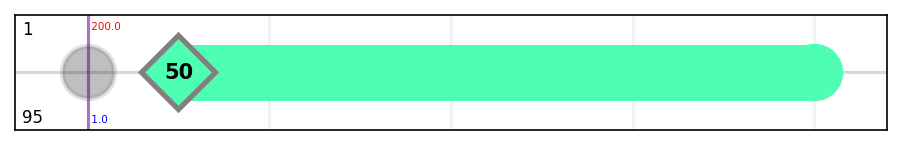

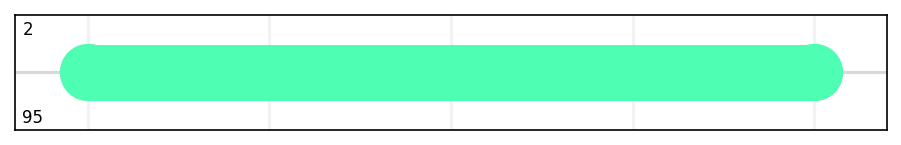

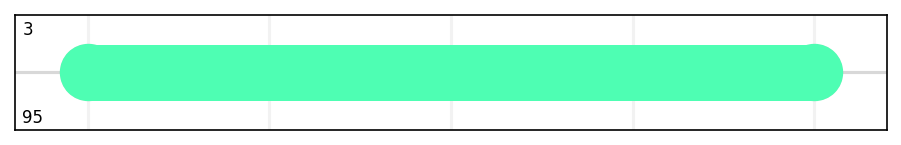

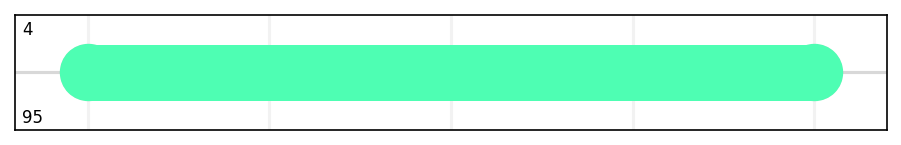

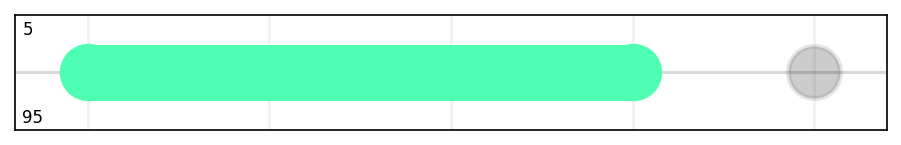

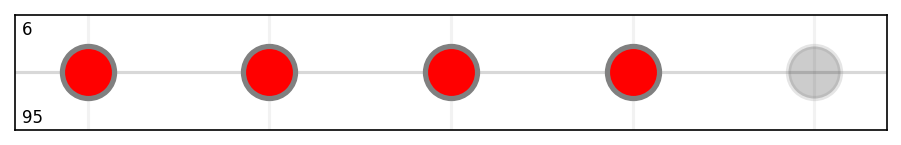

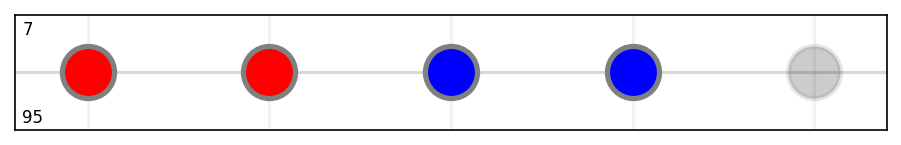

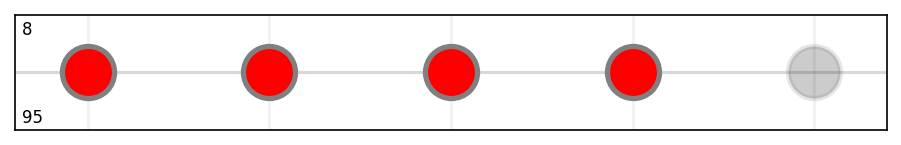

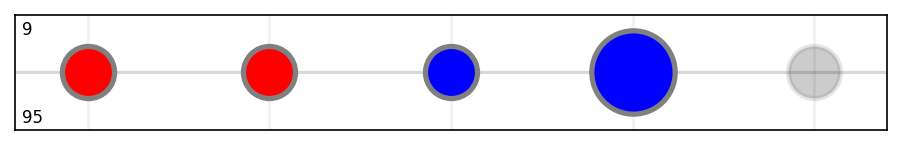

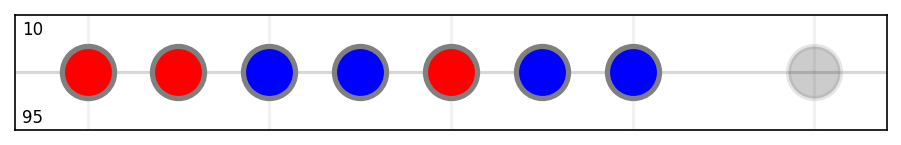

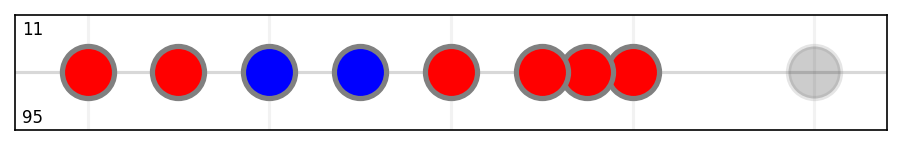

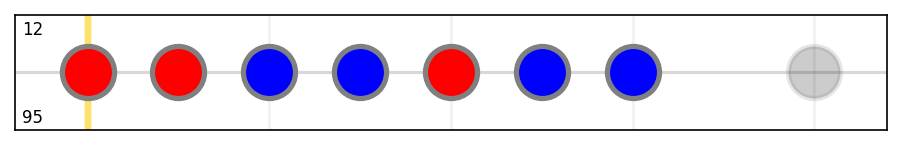

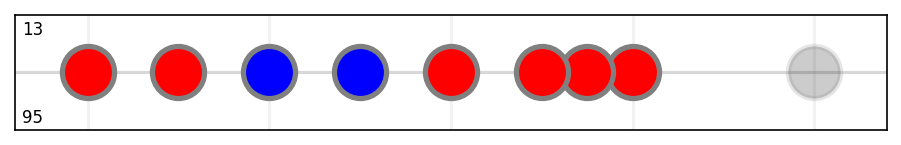

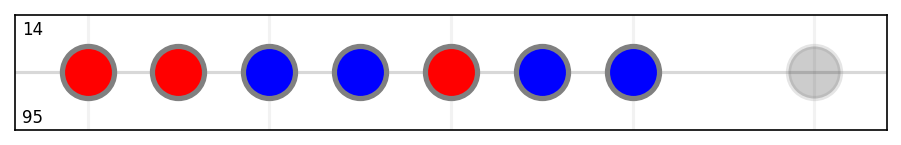

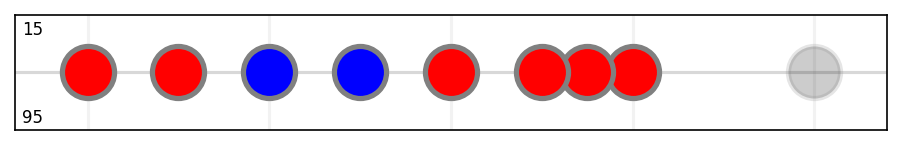

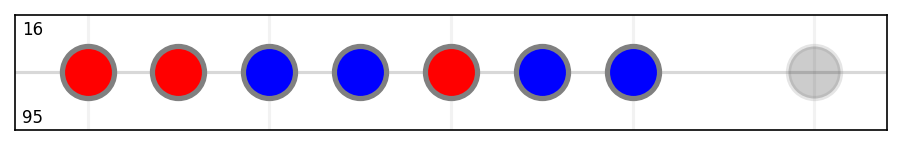

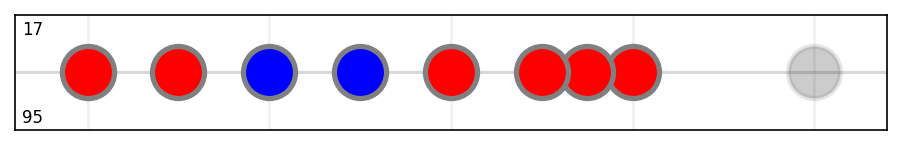

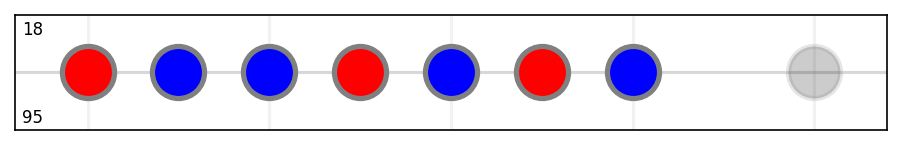

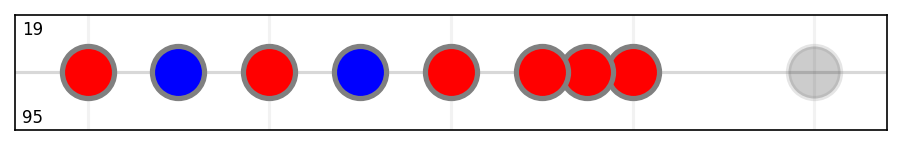

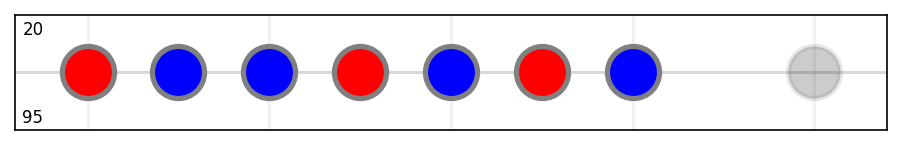

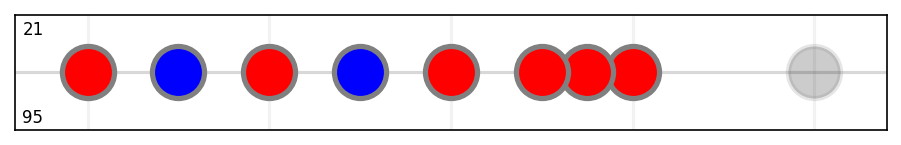

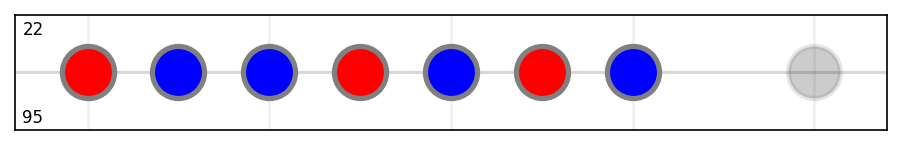

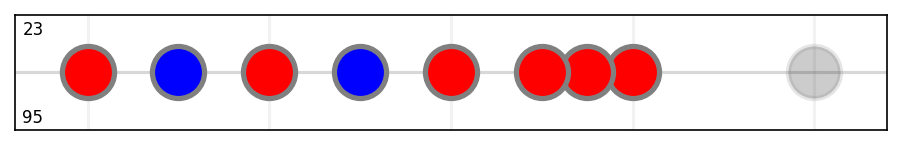

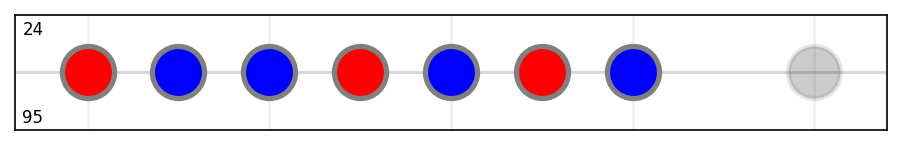

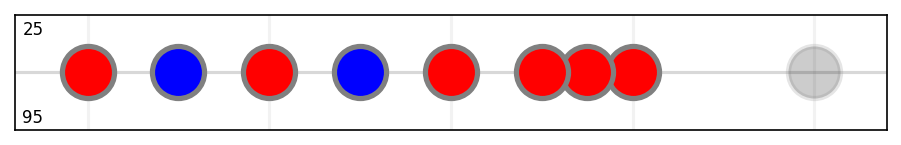

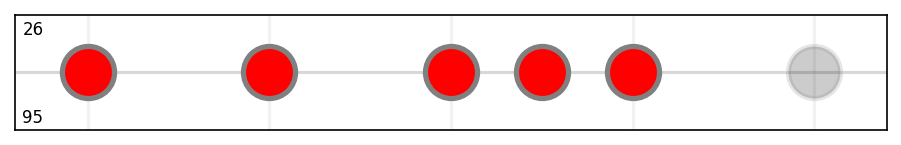

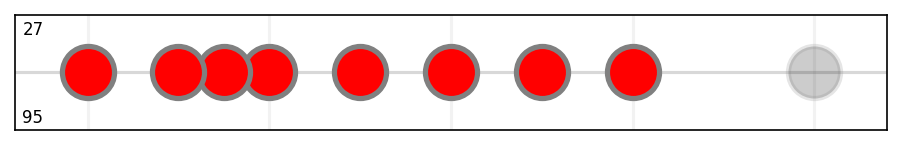

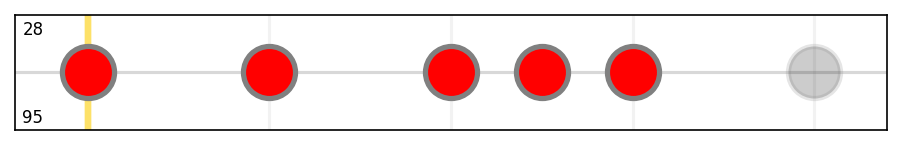

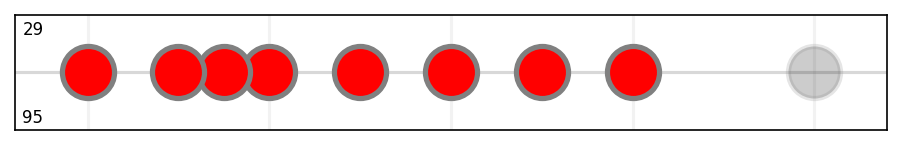

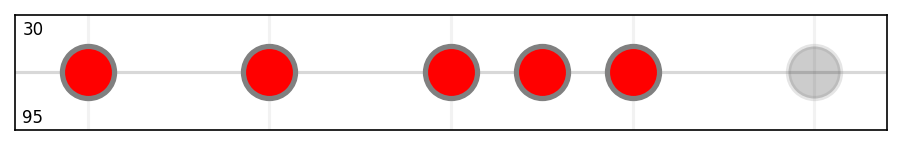

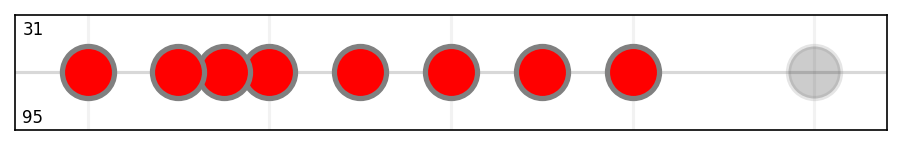

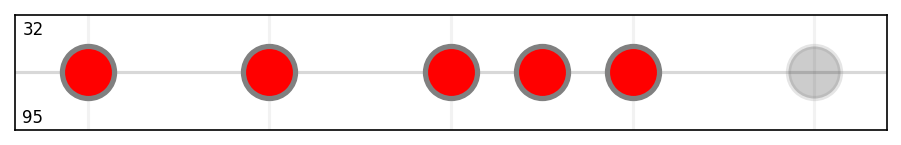

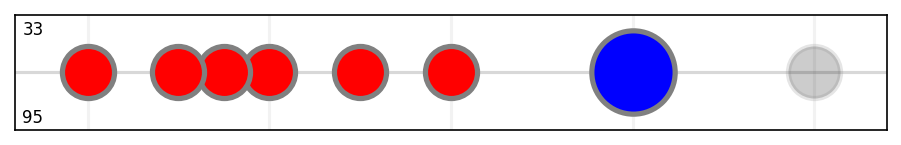

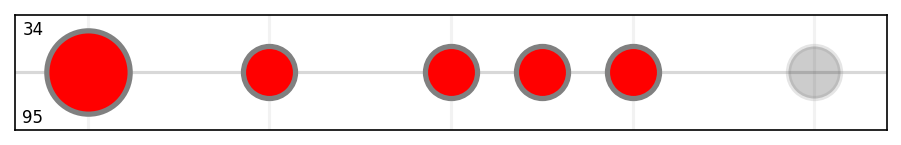

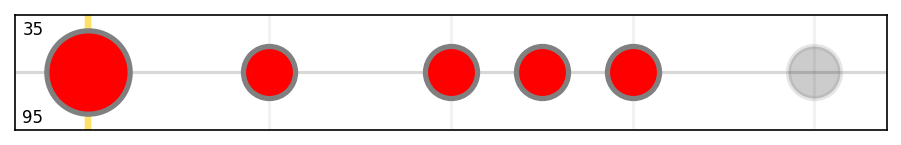

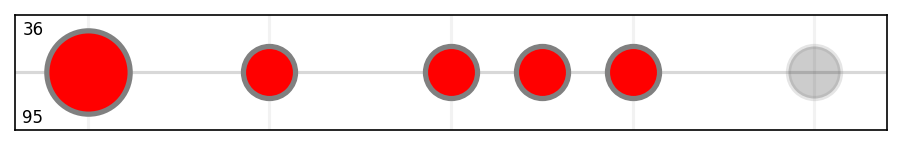

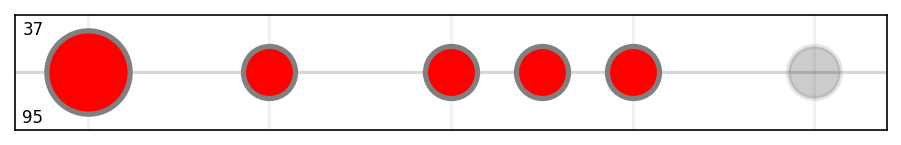

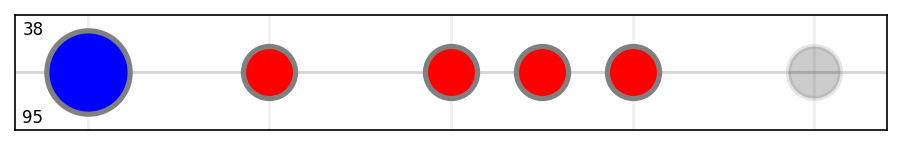

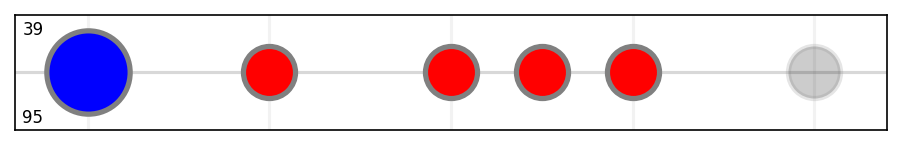

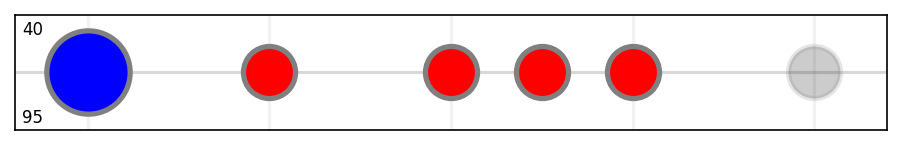

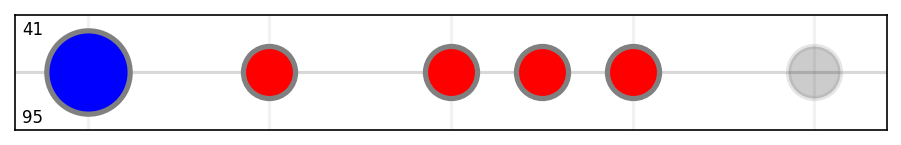

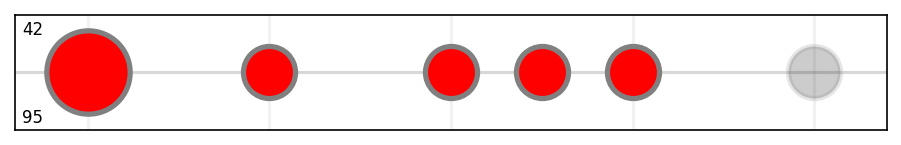

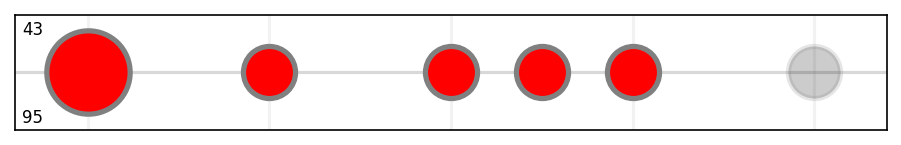

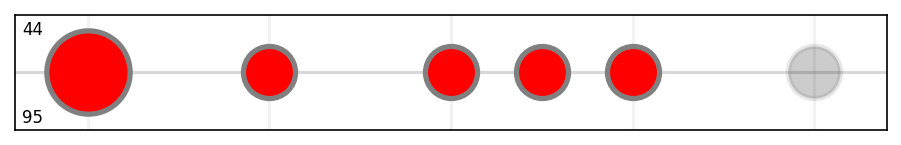

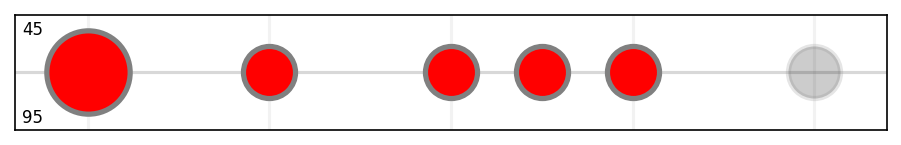

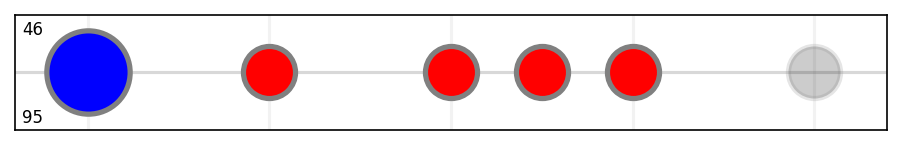

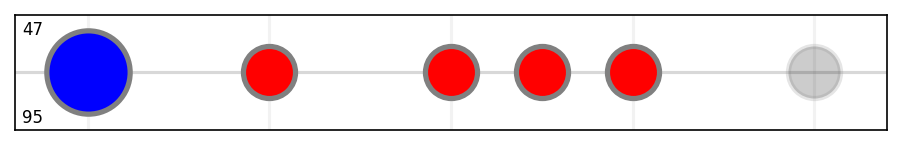

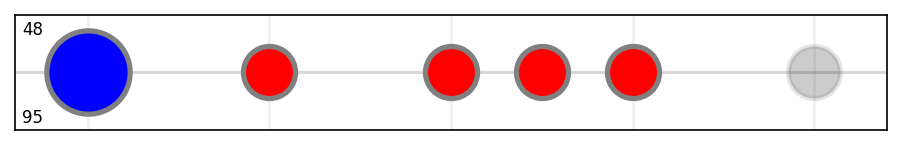

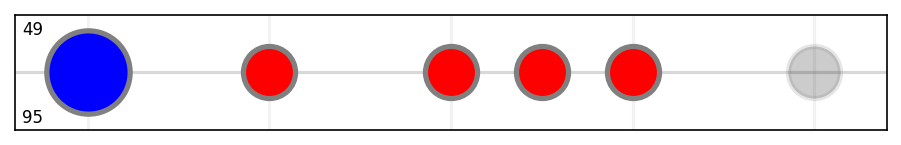

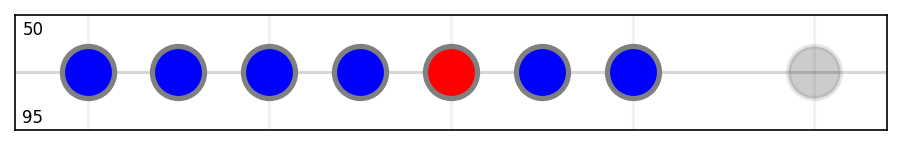

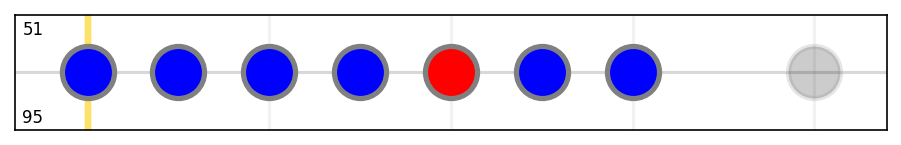

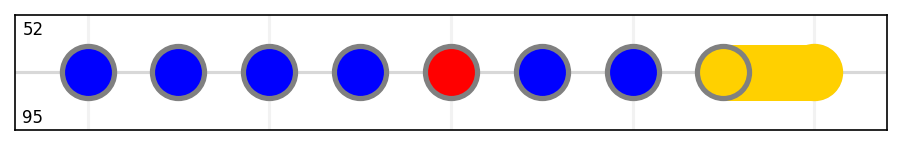

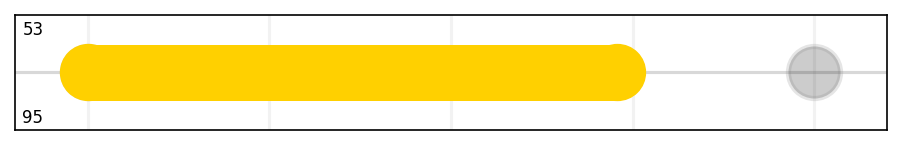

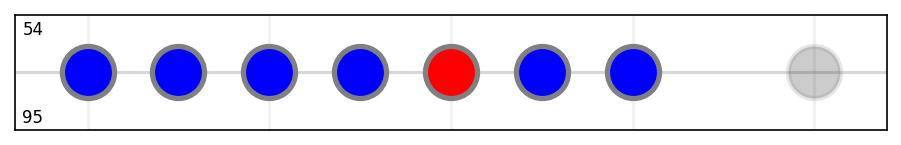

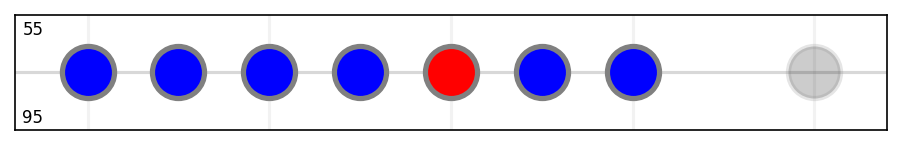

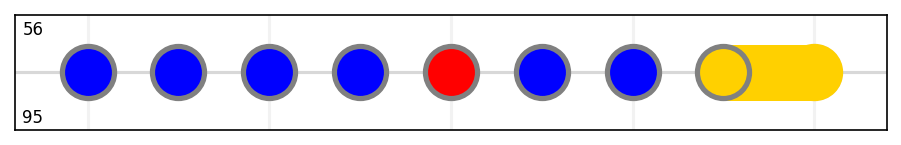

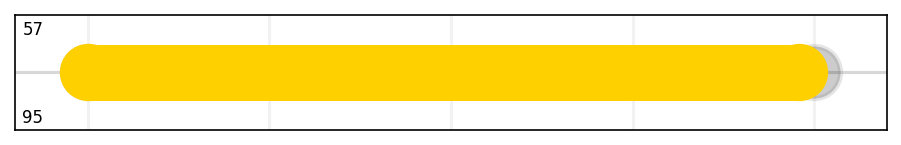

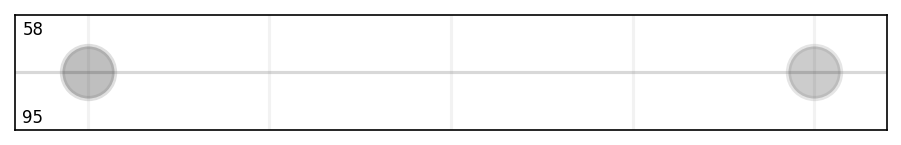

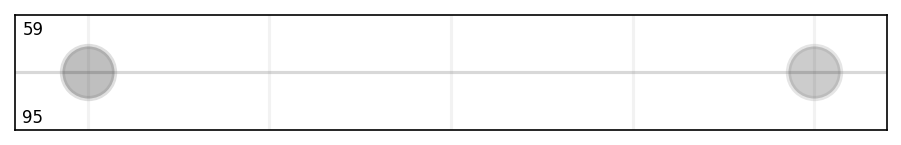

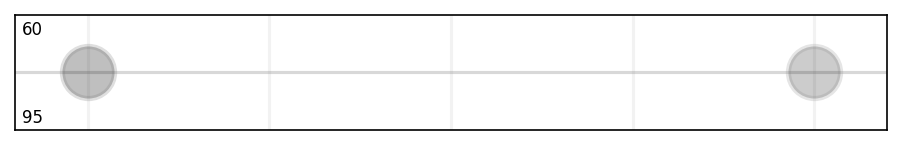

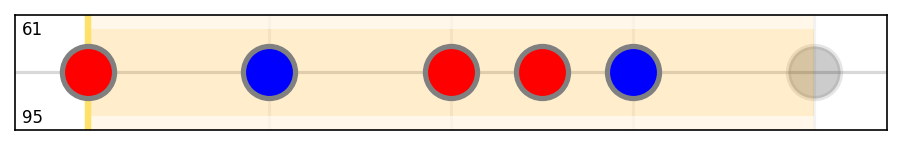

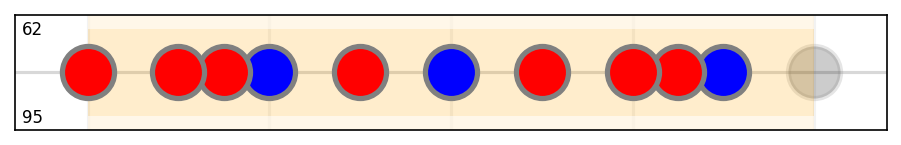

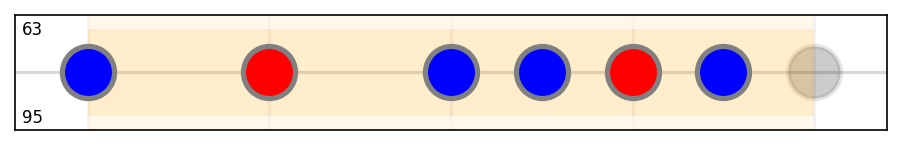

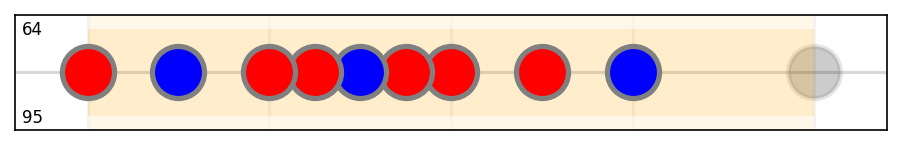

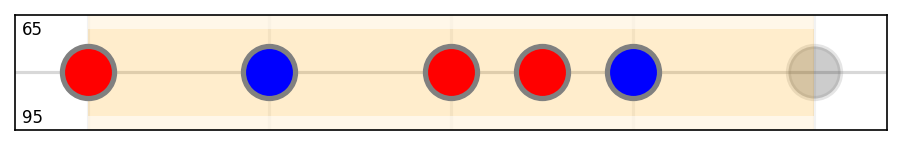

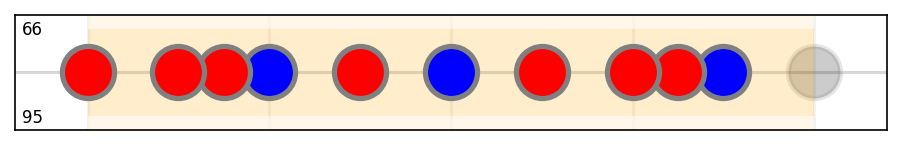

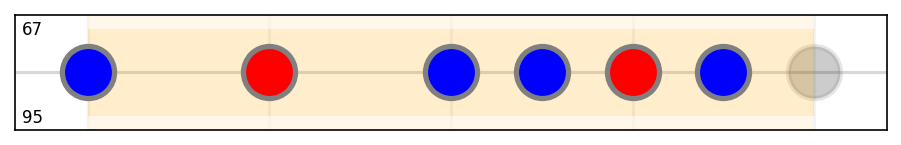

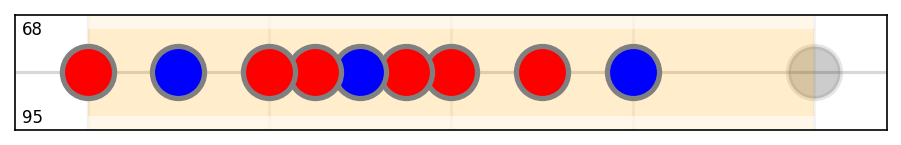

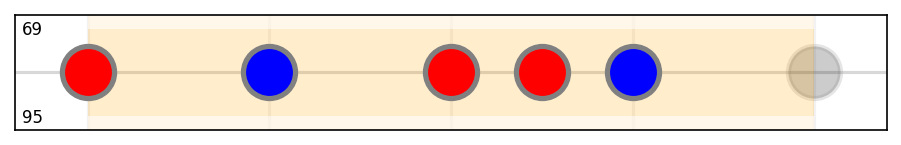

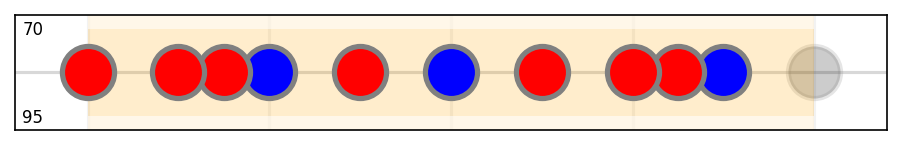

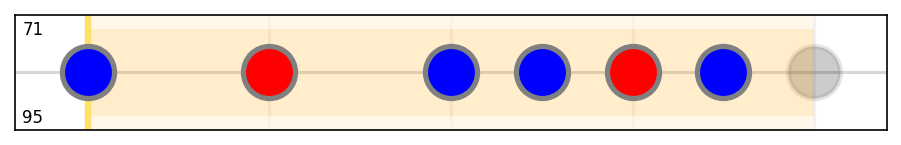

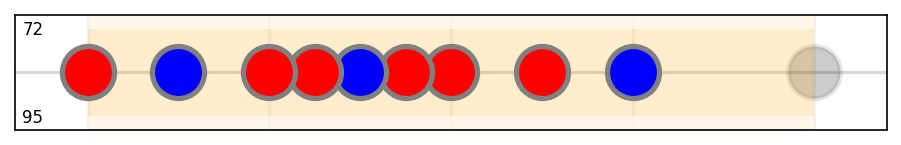

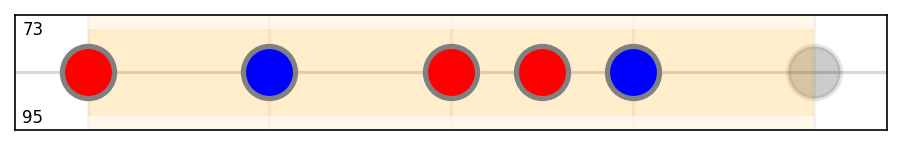

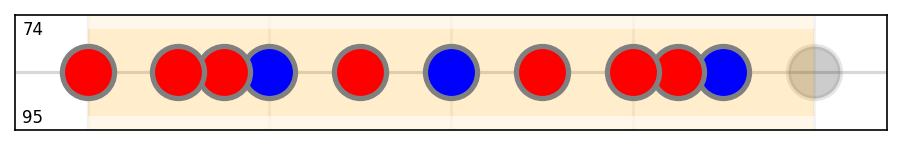

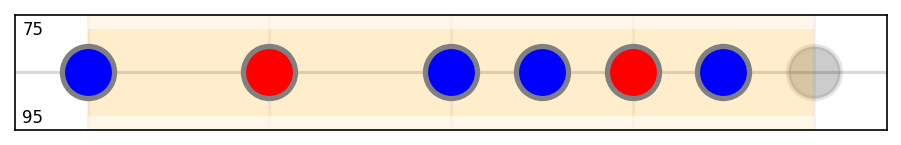

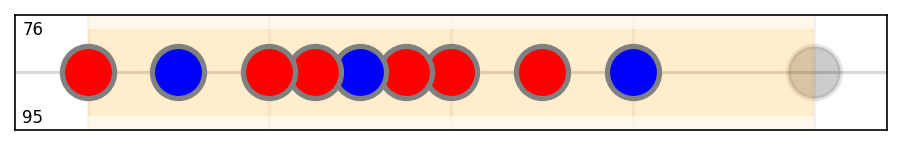

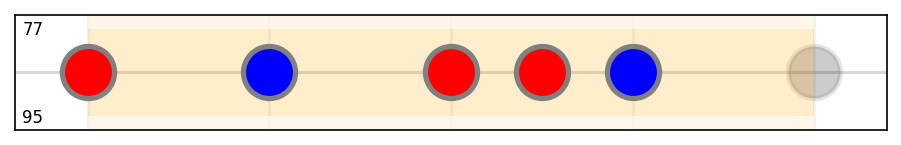

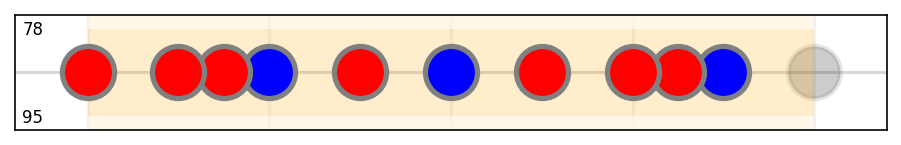

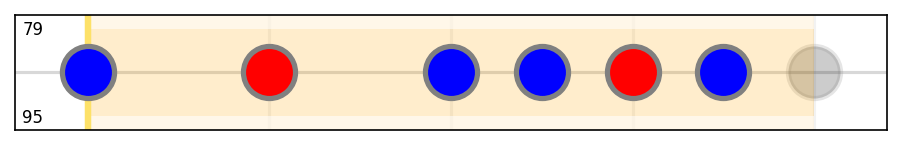

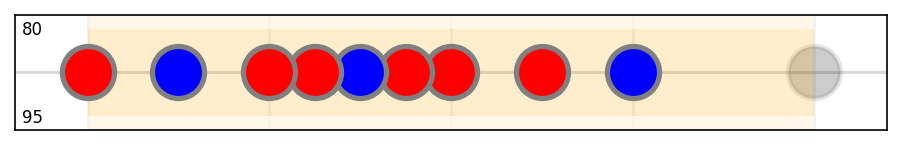

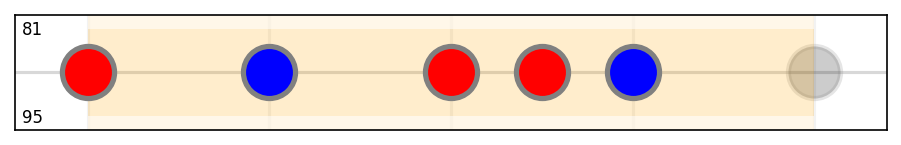

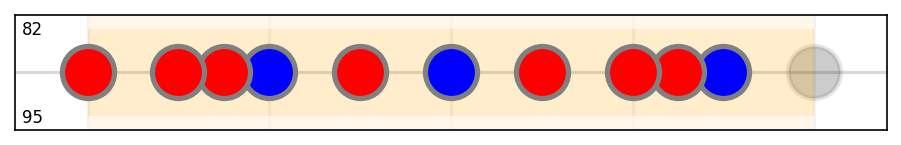

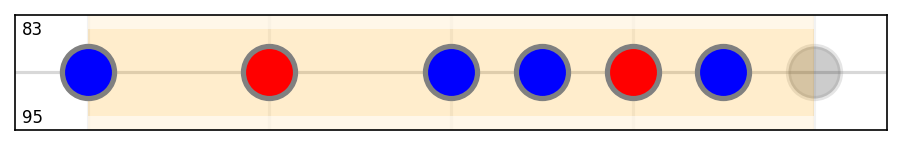

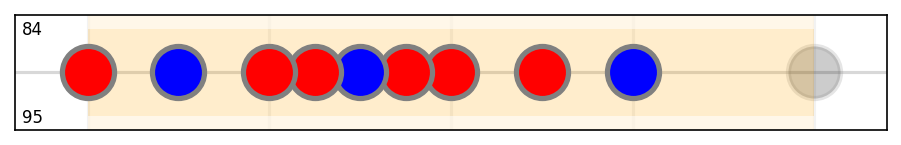

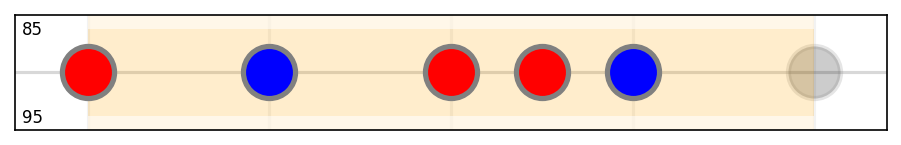

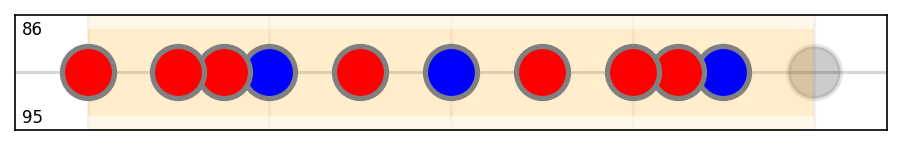

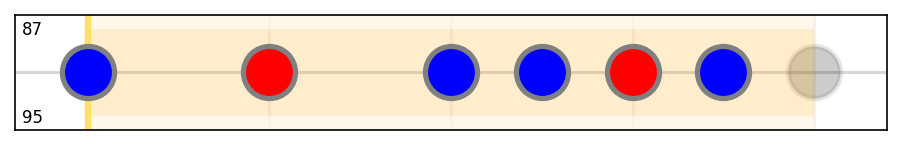

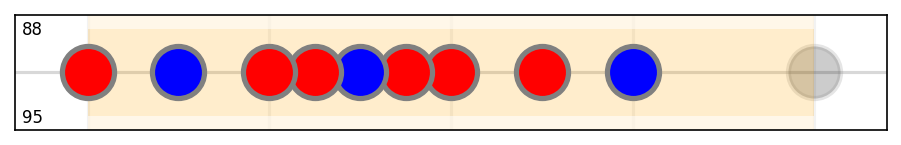

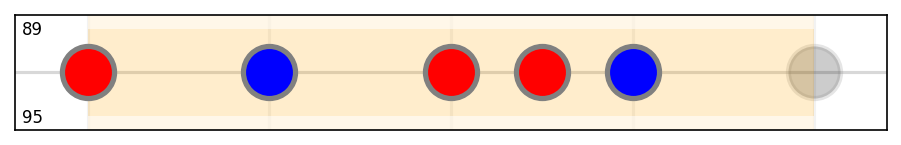

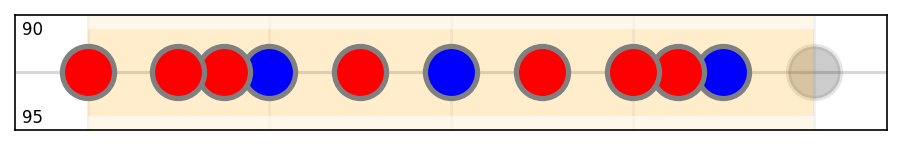

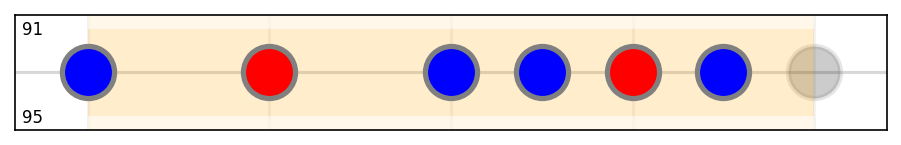

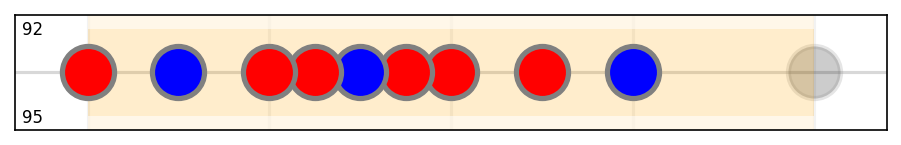

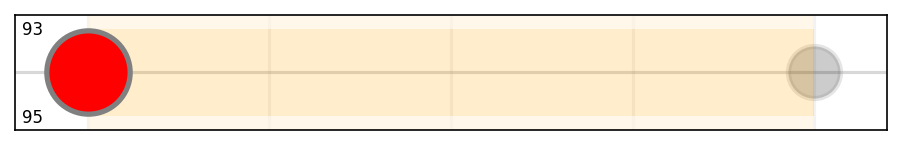

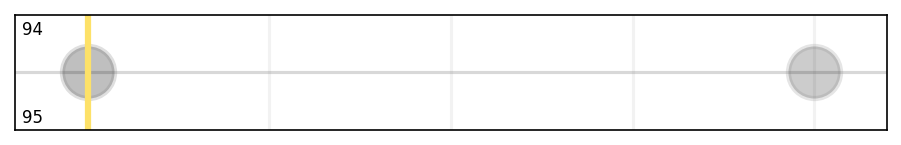

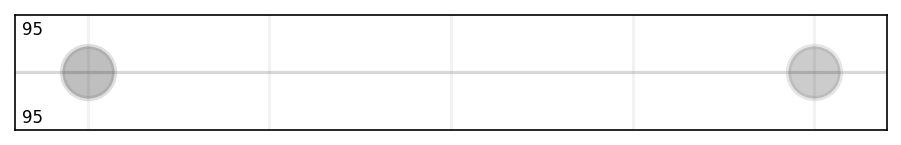

In [355]:
# @title 生成所有小節的圖(新式) - 預設為不進行/不儲存
will = True # @param {type:"boolean"}
save = False # @param {type:"boolean"}
PlotAllNotes(save) if will else print("不進行，若要進行請將\"will\"打勾。")

# 模型/素材下載

In [178]:
# @title  { form-width: "200px" }

#下載下載模組
import os
import sys
if("wget" not in sys.modules):
  !pip install wget
  import wget
  print("\n")
IsEveryThingDownloaded = True
ModelNameList = {"14_2","14_3","14_4","14_5","15_2","15_3","15_4","15_5"}         #所有模型檔案名稱
MaterialNameList = {"dong.wav","ka.wav","big_ka.wav","big_dong.wav"}

#模型儲存的資料夾
ModelStorgeFolder_Name = "TaikoModels"
MaterialFolder_Name = "TaikoMaterials"
if(not os.path.isdir(ModelStorgeFolder_Name)):
  os.makedirs(ModelStorgeFolder_Name)

if(not os.path.isdir(MaterialFolder_Name)):
  os.makedirs(MaterialFolder_Name)

#偵測有無下載模型 以及下載模型
for ModelNumber in ModelNameList:
  Model_Name = str(ModelNumber) + ".pth"
  if(not os.path.isfile(ModelStorgeFolder_Name + "/" + Model_Name)):
    url = "https://github.com/mrpc25/" + ModelStorgeFolder_Name + "/raw/main/" + Model_Name
    wget.download(url)
    IsEveryThingDownloaded = False
    print(f">>>\tModel File \"{Model_Name}\" Has Been Succefully Downloaded.")
    os.rename(Model_Name, ModelStorgeFolder_Name + "/" + Model_Name)

#偵測有無下載素材
for Material in MaterialNameList:
  Material_Name = str(Material)
  if(not os.path.isfile(MaterialFolder_Name + "/" + Material_Name)):
    url = "https://github.com/mrpc25/" + MaterialFolder_Name + "/raw/main/" + Material_Name
    wget.download(url)
    IsEveryThingDownloaded = False
    print(f">>>\tModel File \"{Material_Name}\" Has Been Succefully Downloaded.")
    os.rename(Material_Name, MaterialFolder_Name + "/" + Material_Name)

if(IsEveryThingDownloaded):
  print(">>>\tAlready Downloaded Everything Needed.")

>>>	Already Downloaded Everything Needed.


#聲音生成

In [179]:
# @title 生成特定小節聲音
if("pydub" not in sys.modules):
  !pip install pydub
  print("\n")
import os
from pydub import AudioSegment
from IPython.display import Audio

def AudibilizeBar(MEASURE,LOCATION,BeatsToMeasureSet,SaveFile=False):
  ka = AudioSegment.from_wav("TaikoMaterials/ka.wav")
  dong = AudioSegment.from_wav("TaikoMaterials/dong.wav")
  big_ka = AudioSegment.from_wav("TaikoMaterials/big_ka.wav")
  big_dong = AudioSegment.from_wav("TaikoMaterials/big_dong.wav")

  BarTimeLength = 0
  # if(len(BPMValueSet[MEASURE])!=1):
  #   for i in range(len(BPMValueSet[MEASURE])):
  #     BarTimeLength = BarTimeLength + 60 / BPMValueSet[MEASURE][i] * 4 / ( len(BPMValueSet[MEASURE]) - 1 ) * ( BeatsToMeasureSet[MEASURE][i][0] / BeatsToMeasureSet[MEASURE][i][1])
  # else:
  #   BarTimeLength = BarTimeLength + 60 / BPMValueSet[MEASURE][0] * 4 * ( BeatsToMeasureSet[MEASURE][0][0] / BeatsToMeasureSet[MEASURE][0][1])
  for i in range(len(BPMValueSet[MEASURE])-1):
      BarTimeLength = BarTimeLength + 60 / BPMValueSet[MEASURE][i] * 4 / ( len(BPMValueSet[MEASURE]) - 1 ) * ( BeatsToMeasureSet[MEASURE][i][0] / BeatsToMeasureSet[MEASURE][i][1])
  Base = AudioSegment.silent(duration = BarTimeLength * 1000 + 1500)
  Empty = AudioSegment.silent(duration=1000)

  OverlapLocation = 0
  for i in range(len(EveryBar[MEASURE])-1):
    note = EveryBar[MEASURE][i]
    # if(len(EveryBar[MEASURE])!=1):
    #   SegmentLength = 60 / BPMValueSet[MEASURE][i] * 4 / ( len(BPMValueSet[MEASURE]) - 1 ) * ( BeatsToMeasureSet[MEASURE][i][0] / BeatsToMeasureSet[MEASURE][i][1])
    # else:
    #   SegmentLength = 60 / BPMValueSet[MEASURE][0] * 4 * ( BeatsToMeasureSet[MEASURE][0][0] / BeatsToMeasureSet[MEASURE][0][1])
    SegmentLength = 60 / BPMValueSet[MEASURE][i] * 4 / ( len(BPMValueSet[MEASURE]) - 1 ) * ( BeatsToMeasureSet[MEASURE][i][0] / BeatsToMeasureSet[MEASURE][i][1])
    match note:
      case "1":
        CorrespongingSound = dong
      case "2":
        CorrespongingSound = ka
      case "3":
        CorrespongingSound = big_dong
      case "4":
        CorrespongingSound = big_ka
      case _:
        CorrespongingSound = Empty

    Base = Base.overlay(CorrespongingSound, position=OverlapLocation)
    OverlapLocation = OverlapLocation + SegmentLength * 1000
  Base.export('TaikoMaterials/example.mp3')
  display(Audio('TaikoMaterials/example.mp3')) #solved by https://stackoverflow.com/questions/61573928/using-ipython-display-audio-to-play-audio-in-jupyter-notebook-not-working-when-u

  if(not SaveFile):
    os.remove('TaikoMaterials/example.mp3')

In [180]:
# @title 生成所有小節聲音 - 預設為不進行/不儲存 { form-width: "280px" }
will = False # @param {type:"boolean"}
save = False # @param {type:"boolean"}

if("pydub" not in sys.modules):
  !pip install pydub
  print("\n")
import os
from pydub import AudioSegment
from IPython.display import Audio

def AudibilizeEntireBars(SaveFile=False, method=0):

  ka = AudioSegment.from_wav("TaikoMaterials/ka.wav")
  dong = AudioSegment.from_wav("TaikoMaterials/dong.wav")
  big_ka = AudioSegment.from_wav("TaikoMaterials/big_ka.wav")
  big_dong = AudioSegment.from_wav("TaikoMaterials/big_dong.wav")

  Location = FindEveryActualNotesLocation()
  EntrieTime = Duration(Location[0],Location[-1])[0]
  Base = AudioSegment.silent(duration = EntrieTime * 1000 + 1500)
  Empty = AudioSegment.silent(duration = 1000)

  match method:
    case 0:
      for EachNoteLoca in Location:
        match EveryBar[EachNoteLoca[0]][EachNoteLoca[1]]:
          case "1":
            CorrespongingSound = dong
          case "2":
            CorrespongingSound = ka
          case "3":
            CorrespongingSound = big_dong
          case "4":
            CorrespongingSound = big_ka
          case _:
            CorrespongingSound = Empty
        CurrentTime = Duration(Location[0],EachNoteLoca)[0]
        print(f"\rLocation:\t{TimeDisplay(CurrentTime)}|{TimeDisplay(EntrieTime)}",end='')
        Base = Base.overlay(CorrespongingSound, position = CurrentTime * 1000)
    case 1:
      RelativeTime = [0]
      total = 0
      for i in range(len(Location)-1):
        total = total + Duration(Location[i],Location[i+1])[0]
        RelativeTime.append(total)
      #for EachNoteTime in RelativeTime:
      for x in range(len(RelativeTime)):
        match EveryBar[Location[x][0]][Location[x][1]]:
          case "1":
            CorrespongingSound = dong
          case "2":
            CorrespongingSound = ka
          case "3":
            CorrespongingSound = big_dong
          case "4":
            CorrespongingSound = big_ka
          case _:
            CorrespongingSound = Empty
        EachNoteTime = RelativeTime[x]
        print(f"\rLocation:\t{TimeDisplay(EachNoteTime)}|{TimeDisplay(RelativeTime[-1])}",end='')
        Base = Base.overlay(CorrespongingSound, position = EachNoteTime * 1000)


  print("\r")
  Base.export('TaikoMaterials/EntireFumenSound.mp3')
  display(Audio('TaikoMaterials/EntireFumenSound.mp3')) #solved by https://stackoverflow.com/questions/61573928/using-ipython-display-audio-to-play-audio-in-jupyter-notebook-not-working-when-u


  if(not SaveFile):
    os.remove('TaikoMaterials/EntireFumenSound.mp3')

AudibilizeEntireBars(save) if will else print("不進行，若要進行請將\"will\"打勾。")

不進行，若要進行請將"will"打勾。


#功能區

In [181]:
# @title 譜面基本資訊
#基本資訊:預計output
print(f"歌名:\t\t:{JustForBasicInfo()[0]}")
print(f"星數:\t\t:{JustForBasicInfo()[2]}\n")

#譜面基本內容
notesloaction = FindEveryKindOfNotesLocation()
print(f"演奏時間\t:{round(Duration(notesloaction[0],notesloaction[-1])[0],3)}")
NumberOfNotes = Get_NumberOfNotes_InRegion()
print(f"紅色音符占比\t:{round((NumberOfNotes[1]+NumberOfNotes[3])/NumberOfNotes[0],3)}\n")

#密度
print(f"平均密度\t:{round(DensityOfRegion(),3)} 打/秒")
NotesDuration = FindExtremePeriod()
result = FindExtremeDensityByScanning(Duration(notesloaction[0],notesloaction[-1])[0] * 0.2,0.001)
print(f"前20%高密度\t:{round(result[0],3)} 打/秒")
print(f"後20%低密度\t:{round(result[1],3)} 打/秒")
print(f"最高密度\t:{round(1/NotesDuration[0],3)} 打/秒")
print(f"最低密度\t:{round(1/NotesDuration[1],3)} 打/秒\n")

#視覺因素
both = MultipliedRootOf('both')
r_both = both.real
i_both = both.imag
p_both = math.atan(i_both/r_both)*180/math.pi
print(f"積開根目視速\t:{round(abs(both),3)} bpm",end='')
if(abs(p_both)-0>0.001):
  print(f"\t相位/{round(p_both,3)}度")
else:
  print("")
print(f"\n譜面視速變化程度:\t{round((SeenVelChangeFrequency(True, True, False)[0]-1)*100,3)}%")
print(f"譜面視速變化程度:\t{round(SeenVelChangeFrequency(True, True, True)[0],3)}倍/秒")

print(f"\n換手權重難度\t:{round(WeightResultOfComplex(),3)}")

###

title = JustForBasicInfo()[0]
level = JustForBasicInfo()[2]

Duration_Total = Duration()[0]
RedPercent = (NumberOfNotes[1]+NumberOfNotes[3])/NumberOfNotes[0]

Density_av = float(DensityOfRegion())
Density_high20 = result[0]
Density_low20 = result[1]
Density_max = 1/NotesDuration[0]
Density_min = 1/NotesDuration[1]

SeenVel_rootav = abs(both)
SeenVel_change = SeenVelChangeFrequency(True, True, False)[0] - 1
SeenVel_change_time = SeenVelChangeFrequency(True, True, True)[0]

ComplexWeighyDiff = WeightResultOfComplex()

歌名:		:ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½2000
星數:		:7

演奏時間	:110.25
紅色音符占比	:0.626

平均密度	:5.45 打/秒
前20%高密度	:6.984 打/秒
後20%低密度	:3.537 打/秒
最高密度	:13.333 打/秒
最低密度	:0.196 打/秒

積開根目視速	:200.0 bpm

譜面視速變化程度:	0%
譜面視速變化程度:	0倍/秒

換手權重難度	:4.483


In [182]:
# @title 到這邊會先停下來，下面是其他自選的功能
raise Exception("如果按下全部執行後，到這裡才發生錯誤（只有這個儲存格發生錯誤），那是正常的，代表截至目前為止執行成功。")

Exception: 如果按下全部執行後，到這裡才發生錯誤（只有這個儲存格發生錯誤），那是正常的，代表截至目前為止執行成功。

關於譜面星數預測
1. 如何使用

        需要先執行「一些譜面基本資訊」這個儲存格後，
        並選擇任何一個模型後再按下執行就可使用。

2. 內容
        
        分別採用AC14和AC15（無印）的所有歌曲。
        其中使用鬼級（表裏分開算成兩個）／達人／單人譜面作參照。
資料詳見[太鼓の達人14の収録曲](https://wikiwiki.jp/taiko-fumen/%E4%BD%9C%E5%93%81/AC14)，以及[太鼓の達人(無印) の収録曲](https://wikiwiki.jp/taiko-fumen/%E4%BD%9C%E5%93%81/%E6%96%B0AC/Ver7.03%E3%81%BE%E3%81%A7)。


3. 聲明

        本模型所導出的結果僅供參考，並不代表實際上譜面的應有星數。

In [ ]:
# @title 預測譜面星數(AC14) { form-width: "350px" }
Model = "5 - 4 layers (Linear with ReLUs)" # @param ["1 - 1 layer (Linear)", "2 - 1 layer (20 Sigmoids)", "3 - 1 layer (11 HardSigmoids)", "4 - 3 layers (Linear with ReLUs)", "5 - 4 layers (Linear with ReLUs)"]

import numpy as np
factors = np.array([Duration_Total, RedPercent, Density_av, Density_high20, Density_low20, Density_max, Density_min, SeenVel_rootav, SeenVel_change, SeenVel_change_time, ComplexWeighyDiff])

ChoosenModel = int(Model[0])
ModelName = "14_" + Model[0] + ".pth"
ModelPath = ModelStorgeFolder_Name + "/" + ModelName

match ChoosenModel:

  case 1:
    w = np.array([ 0.008, -0.658,  0.564,  0.237, -0.249, -0.042,  0.177, -0.005, -0.300, -0.010,  1.255])
    b = 0.22802430773477664

    predict_level = np.dot(factors,w) + b
    #test cost ≒ 0.76

  case 2:
    import torch
    from torch import nn
    factors = torch.from_numpy(factors)
    factors = factors.type(torch.float32)
    if(not os.path.isfile(ModelPath)):
      raise Exception(f"Your option need model file \"{ModelName}\"  , but it's not downloand yet.")

    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.sigmoid_num = 20
        self.inputfeat_num = 11

        self.c = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))
        self.w = nn.Parameter(torch.rand(self.sigmoid_num, self.inputfeat_num, requires_grad=True))
        self.b = nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_inside = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))

        self.sigmoid = nn.Sigmoid()

      def forward(self, x):
        Total = self.b
        for i in range(self.sigmoid_num):
          CurrentSigmoidTotal = 0
          Total = Total + self.sigmoid((self.b_inside[i] + self.c[i] * ( (self.w[i]*x).sum(axis=1) )*(10**(-4))))
        return Total.type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    TaikoLevelModel.load_state_dict(torch.load(f=ModelPath))

    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors.reshape(1,-1))

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()[0]
    #test cost ≒ 0.53

  case 3:
    import torch
    from torch import nn
    factors = torch.from_numpy(factors)
    factors = factors.type(torch.float32)
    if(not os.path.isfile(ModelPath)):
      raise Exception(f"Your option need model file \"{ModelName}\"  , but it's not downloand yet.")

    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.sigmoid_num = 11
        self.inputfeat_num = 11

        self.c = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))
        self.w = nn.Parameter(torch.rand(self.sigmoid_num, self.inputfeat_num, requires_grad=True))
        self.b = nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_inside = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))

        self.hardsigmoid = nn.Hardsigmoid()

      def forward(self, x):
        Total = self.b
        for i in range(self.sigmoid_num):
          CurrentSigmoidTotal = 0
          Total = Total + self.hardsigmoid((self.b_inside[i] + self.c[i] * ( (self.w[i]*x).sum(axis=1) )*(10**(-4))))
        return Total.type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    TaikoLevelModel.load_state_dict(torch.load(f=ModelPath))

    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors.reshape(1,-1))

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()[0]
    #test cost ≒ 0.57

  case 4:
    import torch
    from torch import nn
    factors = torch.from_numpy(factors)
    factors = factors.type(torch.float32)
    if(not os.path.isfile(ModelPath)):
      raise Exception(f"Your option need model file \"{ModelName}\"  , but it's not downloand yet.")

    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential \
          (
            nn.Linear(in_features=11, out_features=7),
            nn.ReLU(),
            nn.Linear(in_features=7, out_features=3),
            nn.ReLU(),
            nn.Linear(in_features=3, out_features=1)
          )
      def forward(self, x):
        return (self.layer_stack(x)).type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    TaikoLevelModel.load_state_dict(torch.load(f=ModelPath))

    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors)

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()[0]
    #tess cost ≒ 0.65

  case 5:
    import torch
    from torch import nn
    factors = torch.from_numpy(factors)
    factors = factors.type(torch.float32)
    if(not os.path.isfile(ModelPath)):
      raise Exception(f"Your option need model file \"{ModelName}\"  , but it's not downloand yet.")

    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential \
          (
            nn.Linear(in_features=11, out_features=7),
            nn.ReLU(),
            nn.Linear(in_features=7, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=3),
            nn.ReLU(),
            nn.Linear(in_features=3, out_features=1)
          )
      def forward(self, x):
        return (self.layer_stack(x)).type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    TaikoLevelModel.load_state_dict(torch.load(f=ModelPath))

    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors)

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()[0]
    #tess cost ≒ 0.62

  case _:
    pass

print(f"Title\t\t|\t{title}")
print(f"Actual Level\t|\t{level}")
print(f"Pridict Level\t|\t{round(predict_level,2)}")

print("\n※本模型所導出的結果僅供參考，並不代表實際上譜面的應有星數。")

In [ ]:
# @title 預測譜面星數(AC15無印) { form-width: "350px" }
Model = "5 - 4 layers (Linear with ReLUs)" # @param ["1 - 1 layer (Linear)", "2 - 1 layer (20 Sigmoids)", "3 - 1 layer (11 HardSigmoids)", "4 - 2 layers (Linear with ReLUs)", "5 - 4 layers (Linear with ReLUs)"]

import numpy as np
factors = np.array([Duration_Total, RedPercent, Density_av, Density_high20, Density_low20, Density_max, Density_min, SeenVel_rootav, SeenVel_change, SeenVel_change_time, ComplexWeighyDiff])

ChoosenModel = int(Model[0])
ModelName = "15_" + Model[0] + ".pth"
ModelPath = ModelStorgeFolder_Name + "/" + ModelName

match ChoosenModel:

  case 1:
    w = np.array([0.00804691, -2.0588207, 0.25349426, 0.39613602, -0.11540893, -0.01972612, 0.3689399, -0.00670579, 0.1935756, 0.29895967, 1.0127863])
    b = 1.3593606

    predict_level = np.dot(factors,w) + b
    #test cost ≒ 0.500

  case 2:
    import torch
    from torch import nn
    factors = torch.from_numpy(factors)
    factors = factors.type(torch.float32)
    if(not os.path.isfile(ModelPath)):
      raise Exception(f"Your option need model file \"{ModelName}\"  , but it's not downloand yet.")

    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.sigmoid_num = 20
        self.inputfeat_num = 11

        self.c = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))
        self.w = nn.Parameter(torch.rand(self.sigmoid_num, self.inputfeat_num, requires_grad=True))
        self.b = nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_inside = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))

        self.sigmoid = nn.Sigmoid()

      def forward(self, x):
        Total = self.b
        for i in range(self.sigmoid_num):
          CurrentSigmoidTotal = 0
          Total = Total + self.sigmoid((self.b_inside[i] + self.c[i] * ( (self.w[i]*x).sum(axis=1) )*(10**(-4))))
        return Total.type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    TaikoLevelModel.load_state_dict(torch.load(f=ModelPath))

    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors.reshape(1,-1))

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()[0]
    #test cost ≒ 0.407

  case 3:
    import torch
    from torch import nn
    factors = torch.from_numpy(factors)
    factors = factors.type(torch.float32)
    if(not os.path.isfile(ModelPath)):
      raise Exception(f"Your option need model file \"{ModelName}\"  , but it's not downloand yet.")

    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.sigmoid_num = 11
        self.inputfeat_num = 11

        self.c = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))
        self.w = nn.Parameter(torch.rand(self.sigmoid_num, self.inputfeat_num, requires_grad=True))
        self.b = nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_inside = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))

        self.hardsigmoid = nn.Hardsigmoid()

      def forward(self, x):
        Total = self.b
        for i in range(self.sigmoid_num):
          CurrentSigmoidTotal = 0
          Total = Total + self.hardsigmoid((self.b_inside[i] + self.c[i] * ( (self.w[i]*x).sum(axis=1) )*(10**(-4))))
        return Total.type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    TaikoLevelModel.load_state_dict(torch.load(f=ModelPath))

    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors.reshape(1,-1))

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()[0]
    #test cost ≒ 0.435

  case 4:
    import torch
    from torch import nn
    factors = torch.from_numpy(factors)
    factors = factors.type(torch.float32)
    if(not os.path.isfile(ModelPath)):
      raise Exception(f"Your option need model file \"{ModelName}\"  , but it's not downloand yet.")

    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential \
          (
            nn.Linear(in_features=11, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=1)
          )
      def forward(self, x):
        return (self.layer_stack(x)).type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    TaikoLevelModel.load_state_dict(torch.load(f=ModelPath))

    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors)

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()[0]
    #tess cost ≒ 0.499

  case 5:
    import torch
    from torch import nn
    factors = torch.from_numpy(factors)
    factors = factors.type(torch.float32)
    if(not os.path.isfile(ModelPath)):
      raise Exception(f"Your option need model file \"{ModelName}\"  , but it's not downloand yet.")

    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential \
          (
            nn.Linear(in_features=11, out_features=7),
            nn.ReLU(),
            nn.Linear(in_features=7, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=3),
            nn.ReLU(),
            nn.Linear(in_features=3, out_features=1)
          )
      def forward(self, x):
        return (self.layer_stack(x)).type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    TaikoLevelModel.load_state_dict(torch.load(f=ModelPath))

    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors)

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()[0]
    #tess cost ≒ 0.355

  case _:
    pass

print(f"Title\t\t|\t{title}")
print(f"Actual Level\t|\t{level}")
print(f"Pridict Level\t|\t{round(predict_level,2)}")

print("\n※本模型所導出的結果僅供參考，並不代表實際上譜面的應有星數。")

In [ ]:
#@title 顯示譜面的小節數、經過時間、使用總延遲、出場時間等等
JustForRecognition()

TITLE = OffsetThingsValue("TITLE:", [0, Song_Begin[0]])
OFFSETString = OffsetThingsValue("OFFSET:", [0, Song_Begin[0]])
if(OFFSETString==''):
  OFFSET = 0
else:
  OFFSET = float(OFFSETString)

Time = Duration()
print(f"歌名\t\t:{TITLE}\n小節數\t\t:{len(EveryBar)}\n持續時長\t:{round(Time[0],3)}秒\n延遲總計\t:{round(Time[1],5)}秒")
print(f"譜面出場延遲\t:{-OFFSET}秒")
if(IfAudioNeeded):
  print(f"譜面/音源時長比\t:{round(100*(Time[0]-Time[1])/AudioLength,3)}%")

In [ ]:
# @title 顯示譜面的某一小節的資訊，包括BPM、該小節的節拍組成、流速、小節線和饒燒段狀態、具體譜面內容等等 { form-width: "400px" }
JustForRecognition()

import random
import math


是否需要隨機 = False # @param {type:"boolean"}
是否需要聲音 = True # @param {type:"boolean"}
小節表示法 = "圖片(測試中)"# @param ["圖片(測試中)", "文字(附上指定點)"]
小節位數 = 52 #@param {type:"integer"}
小節位置 = 1 #@param {type:"integer"}

if(小節表示法=="文字(附上指定點)"):
  BarDisplayedInFigure = False
else:
  BarDisplayedInFigure = True

if(是否需要隨機):
  #取得可能的小節數
  MEASURE = random.randint(0,len(EveryBar)-1)
  #取得那個小節的長度內的隨機數(音符數量，沒有的話還是顯示1)
  LOCATION = random.randint(0,(len(EveryBar[MEASURE]))-1)
else:
  MEASURE = 小節位數 - 1
  LOCATION = 小節位置 - 1

try:


  LocationDisplayed = LOCATION
  if(len(EveryBar[MEASURE])==1):
    LocationDisplayed = 0
  if(LocationDisplayed!=len(EveryBar[MEASURE])-1):
    print(f"在第\t{MEASURE+1} of {len(EveryBar)}小節\t位置:{LocationDisplayed+1} of {len(EveryBar[MEASURE])-1} \t的狀態如下:\n")
  else:
    print(f"在第\t{MEASURE+1} of {len(EveryBar)}小節\t位置:小節終止點上 \t的狀態如下:\n")
  if(not 是否需要隨機 and 小節位置<=0):
    1/0
  print(f"\tBPM\t:{BPMValueSet[MEASURE][LOCATION]}")
  print(f"\t節拍\t:{BeatsToMeasureSet[MEASURE][LOCATION][0]}/{BeatsToMeasureSet[MEASURE][LOCATION][1]}")



  scroll = ScrollSet[MEASURE][LOCATION]
  r_scroll = scroll.real
  i_scroll = scroll.imag
  p_scroll = math.atan(i_scroll/r_scroll)*180/math.pi

  OFFSETString = OffsetThingsValue("OFFSET:", [0, Song_Begin[0]])
  if(OFFSETString==''):
    OFFSET = 0
  else:
    OFFSET = float(OFFSETString)

  print(f"\t流速\t:{abs(scroll)}",end='')
  if(abs(p_scroll)-0>0.001):
    print(f"\t(相位\t:{round(p_scroll,3)}度)")
  else:
    print("")
  print(f"\t小節線\t:{BarlineSet[MEASURE][LOCATION]}")
  print(f"\t燃燒段\t:{GOGOSet[MEASURE][LOCATION]}")
  print(f"\t時間點\t:{round(-OFFSET+Duration([0,0],[MEASURE,LOCATION])[0],3)}秒")
  if(BarDisplayedInFigure):
    pass
    #print("\n該小節樸片:")

    #PlotNotes(EveryBar[MEASURE],BeatsToMeasureSet[MEASURE][0][0]/BeatsToMeasureSet[MEASURE][0][1])
    PlotNotes_2(MEASURE,BeatsToMeasureSet[MEASURE][0])

  else:
    print(f"\n譜面內容\t:{EveryBar[MEASURE]}")
    print(f"所選位置\t:",end='')
    for i in range(LOCATION):
      print(" ",end='')
    print("⇑")

except:
  print(f"狀態不存在。")

match 小節表示法:
  case "文字(附上指定點)":
    print("\n該小節聲音:")
  case "圖片(測試中)":
    if(是否需要聲音):
      print("\n該小節聲音/該小節圖片:")
    else:
      print("\n該小節圖片:")
  case _:
    pass


if(是否需要聲音):
  AudibilizeBar(MEASURE,LOCATION,BeatsToMeasureSet)

In [ ]:
#@title 譜面音符資訊
JustForRecognition()

DR = Get_RollInformation()
print("\n所有連打位置\n")
RollTime = 0

IsKickNeedded = None
BalloonKick = Get_BalloonKickNeeded()
BalloonKickIndex = 0

for i in range(len(DR)):
    if(DR[i][0]==5):
        type = "小連打"
        IsKickNeedded = False
    elif(DR[i][0]==6):
        type = "大連打"
        IsKickNeedded  = False
    elif(DR[i][0]==7):
        type = "氣球"
        IsKickNeedded = True
    elif(DR[i][0]==9):
        type = "彩球/番薯"
        IsKickNeedded = True

    RollTime = RollTime + Duration(DR[i][1][0],DR[i][1][1])[0]
  #   print(f"\t類型:{type}\t位置:\t起始:小節{DR[i][1][0][0]+1}\t,{DR[i][1][0][1]+1}/{len(EveryBar[DR[i][1][0][0]])-1}\t\t\
  # 終點:小節{DR[i][1][1][0]+1}\t,{DR[i][1][1][1]+1}/{len(EveryBar[DR[i][1][1][0]])-1}\t\t持續時間:{round(Duration(DR[i][1][0],DR[i][1][1])[0],3)}秒")

    if(IsKickNeedded):
      print(f"\t類型:{type}\t位置:\t起始:小節{DR[i][1][0][0]+1}\t,{DR[i][1][0][1]+1}/{len(EveryBar[DR[i][1][0][0]])-1}\t\t\
  終點:小節{DR[i][1][1][0]+1}\t,{DR[i][1][1][1]+1}/{len(EveryBar[DR[i][1][1][0]])-1}\t\t持續時間:{round(Duration(DR[i][1][0],DR[i][1][1])[0],3)}秒\t\
  所需連打數:{BalloonKick[BalloonKickIndex]}\t\t所需連打速度:{round(BalloonKick[BalloonKickIndex]/Duration(DR[i][1][0],DR[i][1][1])[0],3)}打/秒")
      if(BalloonKickIndex<len(BalloonKick)-1):
        BalloonKickIndex = BalloonKickIndex + 1
    else:
      print(f"\t類型:{type}\t位置:\t起始:小節{DR[i][1][0][0]+1}\t,{DR[i][1][0][1]+1}/{len(EveryBar[DR[i][1][0][0]])-1}\t\t\
  終點:小節{DR[i][1][1][0]+1}\t,{DR[i][1][1][1]+1}/{len(EveryBar[DR[i][1][1][0]])-1}\t\t持續時間:{round(Duration(DR[i][1][0],DR[i][1][1])[0],3)}秒")

print(f"\n\t\t\t\t\t\t\t\t\t\t總計時長:{round(RollTime,3)}秒")

print("\n音符組成\n")

print(f"\t全部\t咚\t咔\t大咚\t大咔")

NumberOfNotes = Get_NumberOfNotes_InRegion()
print(f"\t{NumberOfNotes[0]}\t{NumberOfNotes[1]}\t{NumberOfNotes[2]}\t{NumberOfNotes[3]}\t{NumberOfNotes[4]}")

In [ ]:
JustForRecognition()

import math

#@title 分析譜面的音符密度、平均BPM(兩種算法)、乘積開根號平均視速及流速
print(f"音符密度\t:{round(DensityOfRegion(),3)} 打/秒")
print(f"加總平均BPM\t:{round(SumAverageBPM(),3)} bpm")
print(f"\r乘積開根BPM\t:{round(MultipliedRootOf('bpm'),3)} bpm")

both = MultipliedRootOf('both')
r_both = both.real
i_both = both.imag
p_both = math.atan(i_both/r_both)*180/math.pi
print(f"積開根目視速\t:{round(abs(both),3)} bpm",end='')
if(abs(p_both)-0>0.001):
  print(f"\t相位/{round(p_both,3)}度")
else:
  print("")

scroll = MultipliedRootOf('scroll')
r_scroll = scroll.real
i_scroll = scroll.imag
p_scroll = math.atan(i_scroll/r_scroll)*180/math.pi
print(f"乘積開根SCROLL\t:{round(abs(scroll),3)}",end='')
if(abs(p_scroll)-0>0.001):
  print(f"\t\t相位/{round(p_scroll,3)}度")
else:
  print("")

In [ ]:
#@title 尋找譜面當中所有打點（咚、咔、大咚、大咔）最長與最短時間
JustForRecognition()

NotesDuration = FindExtremePeriod()
print(f"譜面當中最短音符間距\t:{round(NotesDuration[0],3)} 秒\t密度\t:{round(1/NotesDuration[0],3)} 打/秒")
print(f"譜面當中最長音符間距\t:{round(NotesDuration[1],3)} 秒\t密度\t:{round(1/NotesDuration[1],3)} 打/秒")

In [ ]:
JustForRecognition()

# @title 尋找整個譜面當中，局部時間內會出現的最高譜面密度 (測試)
周遭的秒數範圍設定 = "2" #@param {type:"string"}
T = float(周遭的秒數範圍設定)
print(f"搜尋秒數設定:\t{T}秒\n歷史最高密度:\t{round(DensityInSepecificTimeRegion(T),3)}打/秒")

In [ ]:
# @title 整個譜面特定時間比例下，出現過最低與最高的密度(三種模式) { form-width: "400px" }

Density_Mode = "Scanning" # @param ["Old", "TimeStrap", "Scanning"]
ConsideredPercentage = 20 # @param {type:"slider", min:0, max:100, step:1}

if(Density_Mode=="Old"):
  FuctionUsed = DensityInSepecificTimeRegionBoth
elif(Density_Mode=="TimeStrap"):
  FuctionUsed = FindExtremeDensityByTimeStrap
elif(Density_Mode=="Scanning"):
  def FuctionUsed(T):
    return FindExtremeDensityByScanning(T,0.001)
if(ConsideredPercentage==0):
  raise Exception("Percentage input 0")

CosideredTime = Duration(notesloaction[0],notesloaction[-1])[0] * (ConsideredPercentage/100)
result = FuctionUsed(CosideredTime)
print(f"範圍設定:\t{ConsideredPercentage}%\n前{ConsideredPercentage}%時間最高密度:\t{round(result[0],3)}打/秒\n後{ConsideredPercentage}%時間最低密度:\t{round(result[1],3)}打/秒")

In [ ]:
#@title 譜面視速的變化次數和程度 (測試)
JustForRecognition()

計算範圍 = "\u8B5C\u9762\u5167\u6240\u6709\u5730\u65B9" #@param ["譜面內所有地方", "只計算實際打點"]
比較與否 = "\u53EA\u8A08\u7B97\u6709\u8B8A\u5316\u7684\u90E8\u5206" #@param ["計算所有地方", "只計算有變化的部分"]
計算方法 = "\u8003\u616E\u9032\u8B8A\u5316\u904E\u7A0B\u7684\u7D93\u904E\u6642\u9593" #@param ["只計算視覺速度的變化", "考慮進變化過程的經過時間"]

if(計算範圍=="\u53EA\u8A08\u7B97\u5BE6\u969B\u6253\u9EDE"):
  Range = False
else:
  Range = True
if(比較與否=="\u53EA\u8A08\u7B97\u6709\u8B8A\u5316\u7684\u90E8\u5206"):
  Comparison = True
else:
  Comparison = False
if(計算方法=="\u8003\u616E\u9032\u8B8A\u5316\u904E\u7A0B\u7684\u7D93\u904E\u6642\u9593"):
  IsDuration = True
else:
  IsDuration = False
SeenVelInfo = SeenVelChangeFrequency(Range, Comparison, IsDuration)

print(f"\r計算模式：{計算範圍} / {比較與否} / {計算方法}\n")

print(f"譜面視速變化次數:\t{SeenVelInfo[1]}次")
if(IsDuration):
  print(f"譜面視速變化程度:\t{round(SeenVelInfo[0],3)}倍/秒")
else:
  print(f"譜面視速變化程度:\t{round((SeenVelInfo[0]*1-1)*100,3)}%")

In [ ]:
JustForRecognition()

# @title 複合(測試)

輸入數值 = 10 # @param {type:"number"}
數值單位 = "\u6253/\u79D2" # @param ["打/秒", "秒", "BPM (等效成16分音符)"]
印出詳細結果 = True # @param {type:"boolean"}


if(數值單位=="打/秒"):
  print(f"複合定義標準：\t{輸入數值} {數值單位} 以上")
  valuetype = "den"
elif(數值單位=="秒"):
  print(f"複合定義標準：\t{輸入數值} {數值單位} 以下")
  valuetype = "sec"
else:
  print(f"複合定義標準：\t{輸入數值} {數值單位} 以上")
  valuetype = "bpm"

ComplexesLocation = DefineAndFindComplexLocation(輸入數值,valuetype)

print(f"複合總數： {len(ComplexesLocation)-1}條")

if(印出詳細結果):
  print(f"\n詳細結果：\n")

count = 0
for Complex in ComplexesLocation:
  current_complex = ""
  for location in Complex:
    current_complex = current_complex + EveryBar[location[0]][location[1]]
    #print(EveryBar[location[0]][location[1]],end='')
  current_complexinfo = DefineDiffucultyOfComplex(current_complex)
  if(印出詳細結果):
    if(len(Complex)!=0):
      count = count + 1
      print(f"複合:{count}/{len(ComplexesLocation)-1}\t{len(Complex)}連打")
      print(f"複合資訊：\t起始點：{Complex[0][0]+1} - {Complex[0][1]+1}/{len(EveryBar[Complex[0][0]])-1}\t結束點：{Complex[-1][0]+1} - {Complex[-1][1]+1}/{len(EveryBar[Complex[1][0]])-1}")
      print(f"\t\t咚咔變化:{current_complexinfo[0]}次\t\t所需換手:{current_complexinfo[1]}次\t\t密度:{round( ( len(Complex) - 1 ) / Duration(Complex[0], Complex[-1])[0]  , 3)}打/秒")
    print("\n",end='')
  current_complex = ""

這裡定義復合的方式: 有達到某個密度以上的一組依序且連續的音符

其中的密度沒有明確標準。

其中一個參考資料，根據 [A Real Me - CPS Test / CPS Tester](https://www.arealme.com/click-speed-test/en/) 上的統計，人平均可以以6.6~6.8下/秒左右的速度點擊滑鼠。

In [ ]:
JustForRecognition()

# @title 將最終所選譜面內容的所有小節通分 (不支援分歧) { form-width: "300px" }
顯示結果在此儲存格 = True # @param {type:"boolean"}
將結果儲存成檔案 = False # @param {type:"boolean"}

def gcd(a, b):
    return a if b == 0 else gcd(b, a % b)

def lcm(a, b):
    return a * b / gcd(a, b)

temp = 1
for i in range(len(EveryBar)):
  if(len(EveryBar[i])!=1):
    print(temp, len(EveryBar[i])-1,int(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]))
    if(int(lcm(temp,int((len(EveryBar[i])-1)/(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]))))>=temp):
      temp = int(lcm(temp,int((len(EveryBar[i])-1)/(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]))))

  print(temp)
  print("\n")

print("The Number Of Characters Per 1/4 Note:\t" + str(int(temp/4)) , end="")

_scroll = 1
_bpm = float(OffsetThingsValue("BPM:",[ChosenReady,ChosenBegin]))
_measure = [4, 4]
_barline = True
_gogo = False

EveryReducedBar = []

for i in range(len(EveryBar)):

  Temp_Bar = ""

  for j in range(len(EveryBar[i])):

    if(_scroll != ScrollSet[i][j]):
      if(ScrollSet[i][j].imag==0):
        ScrollDisplay = str(ScrollSet[i][j].real)
      else:
        ScrollDisplay = str(ScrollSet[i][j].real) + "+" + str(ScrollSet[i][j].imag) +"i"
      Temp_Bar = Temp_Bar + "\n#SCROLL " + ScrollDisplay + "\n"

    if(_bpm != BPMValueSet[i][j]):
      Temp_Bar = Temp_Bar + "\n#BPMCHANGE " + str(BPMValueSet[i][j]) + "\n"

    if(_measure != BeatsToMeasureSet[i][j]):
      Temp_Bar = Temp_Bar + "\n#MEASURE " + str(BeatsToMeasureSet[i][j][0]) + "/" + str(BeatsToMeasureSet[i][j][1]) + "\n"

    if(_barline != BarlineSet[i][j]):
      if(BarlineSet[i][j]==True):
        Temp_Bar = Temp_Bar + "\n#BARLINEON\n"
      if(BarlineSet[i][j]==False):
        Temp_Bar = Temp_Bar + "\n#BARLINEOFF\n"

    if(_gogo != GOGOSet[i][j]):
      if(GOGOSet[i][j]==True):
        Temp_Bar = Temp_Bar + "\n#GOGOSTART\n"
      if(GOGOSet[i][j]==False):
        Temp_Bar = Temp_Bar + "\n#GOGOEND\n"

    if(DelaySet[i][j]!=0):
      Temp_Bar = Temp_Bar + "\n#DELAY " + str(DelaySet[i][j]) + "\n"


    if(len(EveryBar[i])!=1):
      Temp_Bar = Temp_Bar + EveryBar[i][j]
      reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
      if(EveryBar[i][j]!=","):
        for k in range(reduced-1):
          Temp_Bar = Temp_Bar + "0"

    else:
      for k in range(temp):
        Temp_Bar = Temp_Bar + "0"
      Temp_Bar = Temp_Bar + ","


    _scroll = ScrollSet[i][j]
    _bpm = BPMValueSet[i][j]
    _measure = BeatsToMeasureSet[i][j]
    _delay = DelaySet[i][j]
    _barline = BarlineSet[i][j]
    _gogo = GOGOSet[i][j]

  EveryReducedBar.append(Temp_Bar)

EveryReducedBar.insert(0, "#START")
EveryReducedBar.append("#END")

if(顯示結果在此儲存格):
  print("\n")
# r = ""
for EachReducedBar in EveryReducedBar:
  if(顯示結果在此儲存格):
    print(EachReducedBar)
  # for each in EachReducedBar:
  #   if(each!="#"):
  #     r = r + EachReducedBar
  #   else:
  #     r = r + "\#"
  # r = r + "\n"
if(將結果儲存成檔案):
  with open(file_name + '-reduced.txt', 'w') as f:
      for EachReducedBar in EveryReducedBar:
          f.write(EachReducedBar)
          f.write("\n")
# from IPython.display import HTML
# HTML(f"<button onclick=navigator.clipboard.writeText('{r}')>Copy</button>")

In [ ]:
# @title 所有變數消除
import sys
sys.modules[__name__].__dict__.clear()

In [ ]:
如果執行這裡有發生錯誤代表有順利清除變數

In [ ]:
# @title loop
while True: pass


#其他

In [ ]:
def rhqweyhgrahgeeahghgthqyahgsr():
  section_command_list = FindPhraseInRow("#SECTION",[ChosenBegin, ChosenEndin])
  temp_last = -1
  branch_stateline_check = []
  last_branch_stateline = False

  for section_location in section_command_list:
    for i in range(len(EveryBarRowLocation)):
      MeasureLocationList = EveryBarRowLocation[i]
      for j in range(len(MeasureLocationList)):
        temp_branch_stateline = False
        NotesLocation = MeasureLocationList[j]
        if(temp_last < section_location < NotesLocation):
          branch_stateline_check.append([i,j])
          temp_last = section_location


  return branch_stateline_check

In [ ]:
!pip install pydub
from pydub import AudioSegment

In [ ]:
ka = AudioSegment.from_wav("ka.wav")
dong = AudioSegment.from_wav("dong.wav")

In [ ]:
from IPython.display import Audio                   # 載入 IPython.display 的 Audio模組
Audio('output.mp3')

In [ ]:
plainbase = AudioSegment.silent(duration=10000) #製造空白聲音基底
loop = plainbase.overlay(dong, position=0)
loop = loop.overlay(dong, position=100)
loop = loop.overlay(dong, position=200)
loop.export('output3.mp3')
Audio('output3.mp3')

In [ ]:
# @title
if(not HaveDownLoadedNodel):
  !pip install wget
  import wget
  wget.download("https://github.com/mrpc25/TaikoLevelModel/raw/main/Taiko_3layer_ReLU_F.pth")
  wget.download("https://github.com/mrpc25/TaikoLevelModel/raw/main/Taiko_3layer_ReLU_B.pth")
  wget.download("https://github.com/mrpc25/TaikoLevelModel/raw/main/Taiko_4layer_ReLU_F.pth")
  wget.download("https://github.com/mrpc25/TaikoLevelModel/raw/main/Taiko_4layer_ReLU_B.pth")
  wget.download("https://github.com/mrpc25/TaikoLevelModel/raw/main/Taiko_5layer_ReLU_F.pth")
  wget.download("https://github.com/mrpc25/TaikoLevelModel/raw/main/Taiko_5layer_ReLU_B.pth")
  wget.download('https://github.com/mrpc25/TaikoLevelModel/raw/main/11_hardsigmoid_seed1_B.pth')
  HaveDownLoadedNodel = True
else:
  print("Already Downloaded")

In [ ]:
# @title 預測譜面星數(AC14標準) { form-width: "350px" }
Model = "1 layer" # @param ["1 layer", "3 layers (1,000,000)", "3 layers (best test loss)", "4 layers (1,000,000)", "4 layers (best test loss)", "5 layers (1,000,000)", "5 layers (best test loss)", "1 layer (11 hardsigmoid)"]

import numpy as np
factors = np.array([Duration_Total, RedPercent, Density_av, Density_high20, Density_low20, Density_max, Density_min, SeenVel_rootav, SeenVel_change, SeenVel_change_time, ComplexWeighyDiff])

if(Model == "1 layer"):
  w = np.array([ 0.008, -0.658,  0.564,  0.237, -0.249, -0.042,  0.177, -0.005, -0.300, -0.010,  1.255])
  b = 0.22802430773477664

  predict_level = np.dot(factors,w) + b

  print(f"title\t\t|\t{title}")
  print(f"Actual Level\t|\t{level}")
  print(f"Pridict Level\t|\t{round(predict_level,2)}")
else:
  import torch
  from torch import nn
  factors = torch.from_numpy(factors)
  factors = factors.type(torch.float32)
  if(not HaveDownLoadedNodel):
    raise Exception("Your option need model file to processing, but it's not downloand, please run the download cell above.")

  if(Model == "3 layers (1,000,000)" or Model == "3 layers (best test loss)"):
    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential \
          (
            nn.Linear(in_features=11, out_features=7),
            nn.ReLU(),
            nn.Linear(in_features=7, out_features=3),
            nn.ReLU(),
            nn.Linear(in_features=3, out_features=1)
          )
      def forward(self, x):
        return (self.layer_stack(x)).type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    #仔入儲存好的模型
    if(Model == "3 layers (1,000,000)"):
      TaikoLevelModel.load_state_dict(torch.load(f="Taiko_3layer_ReLU_F.pth"))
    else:
      TaikoLevelModel.load_state_dict(torch.load(f="Taiko_3layer_ReLU_B.pth"))

  elif(Model == "4 layers (1,000,000)" or Model == "4 layers (best test loss)"):
    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential \
          (
            nn.Linear(in_features=11, out_features=7),
            nn.ReLU(),
            nn.Linear(in_features=7, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=3),
            nn.ReLU(),
            nn.Linear(in_features=3, out_features=1)
          )
      def forward(self, x):
        return (self.layer_stack(x)).type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    #仔入儲存好的模型
    if(Model == "4 layers (1,000,000)"):
      TaikoLevelModel.load_state_dict(torch.load(f="Taiko_4layer_ReLU_F.pth"))
    else:
      TaikoLevelModel.load_state_dict(torch.load(f="Taiko_4layer_ReLU_B.pth"))
  elif(Model == "5 layers (1,000,000)" or Model == "5 layers (best test loss)"):
    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential \
          (
            nn.Linear(in_features=11, out_features=9),
            nn.ReLU(),
            nn.Linear(in_features=9, out_features=7),
            nn.ReLU(),
            nn.Linear(in_features=7, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=3),
            nn.ReLU(),
            nn.Linear(in_features=3, out_features=1)
          )
      def forward(self, x):
        return (self.layer_stack(x)).type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    #仔入儲存好的模型
    if(Model == "5 layers (1,000,000)"):
      TaikoLevelModel.load_state_dict(torch.load(f="Taiko_5layer_ReLU_F.pth"))
    else:
      TaikoLevelModel.load_state_dict(torch.load(f="Taiko_5layer_ReLU_B.pth"))
  else:
    class LinearRegressionModel(nn.Module):
      def __init__(self):
        super().__init__()
        self.sigmoid_num = 11
        self.inputfeat_num = 11

        self.c = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))
        self.w = nn.Parameter(torch.rand(self.sigmoid_num, self.inputfeat_num, requires_grad=True))
        self.b = nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_inside = nn.Parameter(torch.rand(self.sigmoid_num, requires_grad=True))

        self.sigmoid = nn.Sigmoid()
        self.hardsigmoid = nn.Hardsigmoid()

      def forward(self, x):
        Total = self.b
        for i in range(self.sigmoid_num):
          CurrentSigmoidTotal = 0
          Total = Total + self.hardsigmoid((self.b_inside[i] + self.c[i] * ( (self.w[i]*x).sum(axis=1) )*(10**(-4))))
        return Total.type(torch.float64)

    TaikoLevelModel = LinearRegressionModel()
    TaikoLevelModel.load_state_dict(torch.load(f="11_hardsigmoid_seed1_B.pth"))

  if(Model!="1 layer (11 hardsigmoid)"):
    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors)

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()

    print(f"title\t\t|\t{title}")
    print(f"Actual Level\t|\t{level}")
    print(f"Pridict Level\t|\t{round(predict_level[0],2)}")
  else:
    TaikoLevelModel.eval()
    with torch.inference_mode():
      predict_level = TaikoLevelModel(factors.reshape(1,-1))

    factors = factors.reshape(-1)
    predict_level = predict_level.numpy()
    predict_level = predict_level.tolist()

    print(f"title\t\t|\t{title}")
    print(f"Actual Level\t|\t{level}")
    print(f"Pridict Level\t|\t{round(predict_level[0],2)}")

In [ ]:
# @title 整個譜面特定時間比例下，出現過最低與最高的密度(舊) { form-width: "400px" }
ConsideredPercentage = 20 # @param {type:"slider", min:0, max:100, step:1}

if(ConsideredPercentage==0):
  raise Exception("Percentage input 0")

CosideredTime = Duration(notesloaction[0],notesloaction[-1])[0] * (ConsideredPercentage/100)
result = DensityInSepecificTimeRegionBoth(CosideredTime)
print(f"範圍設定:\t{ConsideredPercentage}%\n前{ConsideredPercentage}%時間最高密度:\t{round(result[0],3)}打/秒\n後{ConsideredPercentage}%時間最低密度:\t{round(result[1],3)}打/秒")

In [ ]:
# @title 整個譜面特定時間比例下，出現過最低與最高的密度(新) { form-width: "400px" }
ConsideredPercentage = 20 # @param {type:"slider", min:0, max:100, step:1}

if(ConsideredPercentage==0):
  raise Exception("Percentage input 0")

CosideredTime = Duration(notesloaction[0],notesloaction[-1])[0] * (ConsideredPercentage/100)
result = FindExtremeDensityByTimeStrap(CosideredTime)
print(f"範圍設定:\t{ConsideredPercentage}%\n前{ConsideredPercentage}%時間最高密度:\t{round(result[0],3)}打/秒\n後{ConsideredPercentage}%時間最低密度:\t{round(result[1],3)}打/秒")

In [ ]:
# @title 整個譜面特定時間比例下，出現過最低與最高的密度(掃描式) { form-width: "400px" }
ConsideredPercentage = 20 # @param {type:"slider", min:0, max:100, step:1}

if(ConsideredPercentage==0):
  raise Exception("Percentage input 0")

CosideredTime = Duration(notesloaction[0],notesloaction[-1])[0] * (ConsideredPercentage/100)
result = FindExtremeDensityByScanning(CosideredTime,0.001)
print(f"範圍設定:\t{ConsideredPercentage}%\n前{ConsideredPercentage}%時間最高密度:\t{round(result[0],3)}打/秒\n後{ConsideredPercentage}%時間最低密度:\t{round(result[1],3)}打/秒")

In [ ]:
OFFSETString = OffsetThingsValue("OFFSET:", [0, Song_Begin[0]])
if(OFFSETString==''):
  OFFSET = 0
else:
  OFFSET = float(OFFSETString)
# data[]

In [ ]:
def TimePoint(Location):
  OFFSETString = OffsetThingsValue("OFFSET:", [0, Song_Begin[0]])
  if(OFFSETString==''):
    OFFSET = 0
  else:
    OFFSET = float(OFFSETString)

  return -OFFSET+Duration([0,0],Location)[0]

In [ ]:
for i in range(len(EveryBar)):
  for j in range(len(EveryBar[i])-1):
    print(f"{str([i,j]):<10}:\t{EveryBar[i][j]}\t{data[round(TimePoint([i,j])*samplerate)]}")

In [ ]:
def splitarray(array,x):
  Subarray = []
  for element in array:
    Subarray.append(element[x])
  return Subarray

In [ ]:
frequency = splitarray(data,0)
amplitude = splitarray(data,1)

In [ ]:
low = 0
_1 = 0
_10 = 0
_100 = 0
_1000 = 0
for element in amplitude:
  if(element>1000):
    _1000 = _1000 + 1
  elif(element>100):
    _100 = _100 + 1
  elif(element>10):
    _10 = _10 + 1
  elif(element>1):
    _1 = _1 + 1
  else:
    low = low + 1

low, _1, _10, _100, _1000

In [ ]:
# importing the modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.Series(amplitude[1000:len(amplitude)]).plot(figsize=(10,5), lw=1)

In [ ]:
pd.Series(frequency[1000:len(amplitude)]).plot(figsize=(10,5), lw=1)

In [ ]:
JustForRecognition()

# @title 將最終所選譜面內容的所有小節通分 (不支援分歧) { form-width: "300px" }
顯示結果在此儲存格 = False # @param {type:"boolean"}
將結果儲存成檔案 = True # @param {type:"boolean"}

def gcd(a, b):
    return a if b == 0 else gcd(b, a % b)

def lcm(a, b):
    return a * b / gcd(a, b)

temp = 1
for i in range(len(EveryBar)):
  if(len(EveryBar[i])!=1):
    temp = int(lcm(temp,int((len(EveryBar[i])-1)/(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]))))

print("The Number Of Characters Per 1/4 Note:\t" + str(int(temp/4)) , end="")

# _scroll = 1
# _bpm = float(OffsetThingsValue("BPM:",[ChosenReady,ChosenBegin]))
# _measure = [4, 4]
# _barline = True
# _gogo = False

ScrollReducedSet = []
BPMValueRedducedSet = []
BeatsToMeasureReducedSet = []
GOGOReducedSet = []

EveryReducedBar = []

for i in range(len(EveryBar)):

  Temp_Bar = ""

  Temp_Reduced_scroll = []
  Temp_Reduced_bpm = []
  Temp_Reduced_b2m = []
  Temp_Reduced_gogo = []

  for j in range(len(EveryBar[i])):

    if(len(EveryBar[i])!=1):
      Temp_Bar = Temp_Bar + EveryBar[i][j]
      reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))

      if(EveryBar[i][j]!=","):

        Temp_Bar = Temp_Bar + EveryBar[i][j]

        Temp_Reduced_scroll.append(ScrollSet[i][j])
        Temp_Reduced_bpm.append(BPMValueSet[i][j])
        Temp_Reduced_b2m.append(BeatsToMeasureSet[i][j])
        Temp_Reduced_gogo.append(GOGOSet[i][j])

        for k in range(reduced-1):

          Temp_Reduced_scroll.append(ScrollSet[i][j])
          Temp_Reduced_bpm.append(BPMValueSet[i][j])
          Temp_Reduced_b2m.append(BeatsToMeasureSet[i][j])
          Temp_Reduced_gogo.append(GOGOSet[i][j])

      else:

        Temp_Reduced_scroll.append(ScrollSet[i][j])
        Temp_Reduced_bpm.append(BPMValueSet[i][j])
        Temp_Reduced_b2m.append(BeatsToMeasureSet[i][j])
        Temp_Reduced_gogo.append(GOGOSet[i][j])
    else:

      for k in range(temp+1):

        Temp_Reduced_scroll.append(ScrollSet[i][j])
        Temp_Reduced_bpm.append(BPMValueSet[i][j])
        Temp_Reduced_b2m.append(BeatsToMeasureSet[i][j])
        Temp_Reduced_gogo.append(GOGOSet[i][j])

        for k in range(temp):
          Temp_Bar = Temp_Bar + "0"
        Temp_Bar = Temp_Bar + ","


  ScrollReducedSet.append(Temp_Reduced_scroll)
  BPMValueRedducedSet.append(Temp_Reduced_bpm)
  BeatsToMeasureReducedSet.append(Temp_Reduced_b2m)
  GOGOReducedSet.append(Temp_Reduced_gogo)

    # _scroll = ScrollSet[i][j]
    # _bpm = BPMValueSet[i][j]
    # _measure = BeatsToMeasureSet[i][j]
    # _delay = DelaySet[i][j]
    # _barline = BarlineSet[i][j]
    # _gogo = GOGOSet[i][j]

  EveryReducedBar.append(Temp_Bar)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [ ]:
# @title
IfAudioNeeded = True # @param {type:"boolean"}
audio_name = OffsetThingsValue("WAVE:",[0, len(EveryRow)])
import soundfile as sf

with open(audio_name, 'rb') as f:
  audio_files = glob(audio_name)

In [ ]:
ipd.Audio(audio_files[0])

In [ ]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

In [ ]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

In [ ]:
pd.Series(y[100:1000000]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

In [ ]:
def ReplaceInStr(String, target, index):
    ListFromString = []
    for char in String:
        ListFromString.append(char)

    ListFromString[index] = target

    StringFromTransferedList = ""
    for element in ListFromString:
        StringFromTransferedList = StringFromTransferedList + element

    return StringFromTransferedList

In [ ]:
JustForRecognition()

def gcd(a, b):
    return a if b == 0 else gcd(b, a % b)

def lcm(a, b):
    return a * b / gcd(a, b)

temp = 1
for i in range(len(EveryBar)):
  if(len(EveryBar[i])!=1):
    if(int(lcm(temp,int((len(EveryBar[i])-1)/(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]))))>=temp):
      temp = int(lcm(temp,int((len(EveryBar[i])-1)/(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]))))

print("The Number Of Characters Per 1/4 Note:\t" + str(int(temp/4)) , end="")

_scroll = 1
_bpm = float(OffsetThingsValue("BPM:",[ChosenReady,ChosenBegin])) if OffsetThingsValue("BPM:",[ChosenReady,ChosenBegin])!="" else float(OffsetThingsValue("BPM:",[0, Song_Begin[0]]))
_measure = [4, 4]
_barline = True
_gogo = False

EveryReducedBar = []
LastLocationInProcess = [None, None]
DurningRoll = False
DurningRoll_type = None

TITLE = OffsetThingsValue("TITLE:", [0, Song_Begin[0]])
if(not IsAnyDual):
  COURSE = OffsetThingsValue("COURSE:", [ChosenReady, ChosenBegin])
  LevelStar = OffsetThingsValue("LEVEL:", [ChosenReady, ChosenBegin])
else:
  COURSE = OffsetThingsValue("COURSE:", [Song_Difficulty[int(UserChosenFumen)], Song_Difficulty[int(UserChosenFumen)]+1])
  LevelStar = OffsetThingsValue("LEVEL:", [Song_level[int(UserChosenFumen)], Song_level[int(UserChosenFumen)]+1])

Temp_Bar = ""

Temp_Bar = Temp_Bar + "#title " + str(TITLE) + "\n"
EveryReducedBar.append(Temp_Bar)
Temp_Bar = ""

Temp_Bar = Temp_Bar + "#bpm " + str(_bpm) + "\n"
EveryReducedBar.append(Temp_Bar)
Temp_Bar = ""

Temp_Bar = Temp_Bar + "#difficulty " + "\n"
EveryReducedBar.append(Temp_Bar)
Temp_Bar = ""

Temp_Bar = Temp_Bar + "#level " + str(LevelStar) + "\n"
EveryReducedBar.append(Temp_Bar)
Temp_Bar = ""

Temp_Bar = Temp_Bar + "#beatchar " + str(int(temp/4)) + "\n"
EveryReducedBar.append(Temp_Bar)
Temp_Bar = ""

for i in range(len(EveryBar)):

  if(BeatsToMeasureSet[i][0]!=_measure):
    Temp_Bar = Temp_Bar + "#meter " + str(BeatsToMeasureSet[i][0][1]) + " " + str(BeatsToMeasureSet[i][0][0]) + "\n"

  for k in range(len(EveryBar[i])):
    if(len(EveryBar[i])!=1):
      if(ScrollSet[i][k]!=_scroll):
        Temp_Bar = Temp_Bar + "#hs " + str(ScrollSet[i][k].real) + " " + str(int(temp/4)) + " " + str(int(k*temp/(len(EveryBar[i])-1)*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]))) + "\n"
      if(BPMValueSet[i][k]!=_bpm):
        Temp_Bar = Temp_Bar + "#bpm " + str(BPMValueSet[i][k]) + " " + str(int(temp/4)) + " " + str(int(k*temp/(len(EveryBar[i])-1)*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]))) + "\n"
    else:
      if(ScrollSet[i][k]!=_scroll):
        Temp_Bar = Temp_Bar + "#hs " + str(ScrollSet[i][k].real) + "\n"
      if(BPMValueSet[i][k]!=_bpm):
        Temp_Bar = Temp_Bar + "#bpm " + str(BPMValueSet[i][k]) + "\n"
    if(GOGOSet[i][k]!=_gogo):
      if(GOGOSet[i][k]==True):
        Temp_Bar = Temp_Bar + "#begingogo\n"
      else:
        Temp_Bar = Temp_Bar + "#endgogo\n"
    _scroll = ScrollSet[i][k]
    _bpm = BPMValueSet[i][k]
    _gogo = GOGOSet[i][k]

  _measure = BeatsToMeasureSet[i][0]

  # _scroll = ScrollSet[i][k]
  # _bpm = BPMValueSet[i][k]
  # _gogo = GOGOSet[i][k]
  #_delay = DelaySet[i][k]
  #_barline = BarlineSet[i][k]


  EveryReducedBar.append(Temp_Bar)
  Temp_Bar = ""

  for j in range(len(EveryBar[i])):
    reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
    if(len(EveryBar[i])!=1):

      if(not DurningRoll):
        if(EveryBar[i][j]=="0"):
          Temp_Bar = Temp_Bar + " "
        elif(EveryBar[i][j]=="1"):
          Temp_Bar = Temp_Bar + "o"
        elif(EveryBar[i][j]=="2"):
          Temp_Bar = Temp_Bar + "x"
        elif(EveryBar[i][j]=="3"):
          Temp_Bar = Temp_Bar + "O"
        elif(EveryBar[i][j]=="4"):
          Temp_Bar = Temp_Bar + "X"
        elif(EveryBar[i][j]=="5"):
          Temp_Bar = Temp_Bar + "<"
          DurningRoll = True
          DurningRoll_type = 5
        elif(EveryBar[i][j]=="6"):
          Temp_Bar = Temp_Bar + "("
          DurningRoll = True
          DurningRoll_type = 6
        elif(EveryBar[i][j]=="7"):
          Temp_Bar = Temp_Bar + "["
          DurningRoll = True
          DurningRoll_type = 7
        elif(EveryBar[i][j]=="9"):
          Temp_Bar = Temp_Bar + "["
          DurningRoll = True
          DurningRoll_type = 9
        #reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
        if(EveryBar[i][j]!=","):
          for k in range(reduced-1):
            if(EveryBar[i][j]!="5" and EveryBar[i][j]!="6" and EveryBar[i][j]!="7" and EveryBar[i][j]!="9"):
            #if(not DurningRoll):
              Temp_Bar = Temp_Bar + " "
            else:
              Temp_Bar = Temp_Bar + "="
      else:

        #reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
        if(EveryBar[i][j]=="0" or EveryBar[i][j]=="5" or EveryBar[i][j]=="6" or EveryBar[i][j]=="7" or EveryBar[i][j]=="9"):
          for k in range(reduced):
            Temp_Bar = Temp_Bar + "="

        elif(EveryBar[i][j]=="8" or EveryBar[i][j]=="1" or EveryBar[i][j]=="2" or EveryBar[i][j]=="3" or EveryBar[i][j]=="4"):
          DurningRoll = False
          if(len(Temp_Bar)!=0):
            if(DurningRoll_type==5):
              Temp_Bar = ReplaceInStr(Temp_Bar, ">", -1)
              #Temp_Bar[-1] = ">"
            elif(DurningRoll_type==6):
              Temp_Bar = ReplaceInStr(Temp_Bar, ")", -1)
              #Temp_Bar[-1] = ")"
            elif(DurningRoll_type==7 or DurningRoll_type==9):
              Temp_Bar = ReplaceInStr(Temp_Bar, "]", -1)
              #Temp_Bar[-1] = "]"
          else:
            if(DurningRoll_type==5):
              EveryReducedBar[i-1] = ReplaceInStr(EveryReducedBar[i-1], ">", -1)
              #EveryReducedBar[i-1][-1] = ">"
            elif(DurningRoll_type==6):
              EveryReducedBar[i-1] = ReplaceInStr(EveryReducedBar[i-1], ")", -1)
              #EveryReducedBar[i-1][-1] = ")"
            elif(DurningRoll_type==7 or DurningRoll_type==9):
              EveryReducedBar[i-1] = ReplaceInStr(EveryReducedBar[i-1], "]", -1)
              #EveryReducedBar[i-1][-1] = "]"

          if(EveryBar[i][j]=="8"):
            Temp_Bar = Temp_Bar + " "
          elif(EveryBar[i][j]=="1"):
            Temp_Bar = Temp_Bar + "o"
          elif(EveryBar[i][j]=="2"):
            Temp_Bar = Temp_Bar + "x"
          elif(EveryBar[i][j]=="3"):
            Temp_Bar = Temp_Bar + "O"
          elif(EveryBar[i][j]=="4"):
            Temp_Bar = Temp_Bar + "X"

          #reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
          if(EveryBar[i][j]!=","):
            for k in range(reduced-1):
              Temp_Bar = Temp_Bar + " "

    else:
      for k in range(temp):
        if(not DurningRoll):
          Temp_Bar = Temp_Bar + " "
        else:
          Temp_Bar = Temp_Bar + "="


    LastLocationInProcess = [i,j]

  EveryReducedBar.append(Temp_Bar)
  Temp_Bar = ""

In [ ]:
with open(file_name + ' - reduced.txt', 'w') as f:
    for EachReducedBar in EveryReducedBar:
        f.write(EachReducedBar)
        if(len(EachReducedBar)!=0):
          if(EachReducedBar[-1]!="\n"):
            f.write("\n")

In [ ]:
FindPhraseInRow("7")

In [ ]:
EveryRow[107]

In [ ]:
len(EachReducedBar)

In [ ]:
def donothing():
  pass

In [ ]:
for bar in EveryReducedBar:
  print(bar)

In [ ]:
iteInRoll, iteRollsize, iteSelected_color = None, None, None
for x in range(len(EveryBar)):
  iteInRoll, iteRollsize, iteSelected_color = PlotNotes(EveryBar[x], BeatsToMeasureSet[x][0][0]/BeatsToMeasureSet[x][0][1], iteInRoll, iteRollsize, iteSelected_color)

In [ ]:
def DefineAndFindComplexLocation(ref, type_mode="den"):

  NotesLocation = FindEveryActualNotesLocation()
  ComplexesLocation = []
  IsInDenseThreshold = False

  if(type_mode=="den"):
    Threshold = 1 / ref
  elif(type_mode=="sec"):
    Threshold = ref
  elif(type_mode=="bpm"):
    Threshold = 60 / ref / 4

  TempComplexesLocation = []
  for i in range(len(NotesLocation)-1):

    if(Duration(NotesLocation[i],NotesLocation[i+1])[0]<=Threshold):
      IsInDenseThreshold = True
    else:
      IsInDenseThreshold = False

    if(IsInDenseThreshold):
      if(len(TempComplexesLocation)==0):
        TempComplexesLocation = [NotesLocation[i], NotesLocation[i+1]]
      else:
        TempComplexesLocation.append(NotesLocation[i+1])
    else:
      if(len(TempComplexesLocation)!=0):
        ComplexesLocation.append(TempComplexesLocation)
        TempComplexesLocation = []

  return ComplexesLocation

In [ ]:
print(len(DefineAndFindComplexLocation(9.206)))

In [ ]:
def gcd(a, b):
    return a if b == 0 else gcd(b, a % b)

def lcm(a, b):
    return a * b / gcd(a, b)

In [ ]:
lcm(54,96)

In [ ]:
len(x)-1

In [ ]:
temp

In [ ]:
BeatsToMeasureSet[7]

In [ ]:
temp = 1
for i in range(len(EveryBar)):
  if(len(EveryBar[i])!=1):
    print(len(EveryBar[i])-1, temp)
    temp = int(lcm(temp,int((len(EveryBar[i])-1)/(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]))))
    print(temp)
    print("\n")

In [ ]:
EveryReducedBar = []
for i in range(len(EveryBar)):
  TempBar = ""
  if(len(EveryBar[i])!=1):
    Reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
    for j in range(len(EveryBar[i])-1):
      TempBar = TempBar + EveryBar[i][j]
      for k in range(Reduced-1):
        TempBar = TempBar + "0"
  else:
    for k in range(temp):
      TempBar = TempBar + "0"
  EveryReducedBar.append(TempBar)

In [ ]:
EveryReducedBar = []
for i in range(len(EveryBar)):
  TempBar = ""
  if(len(EveryBar[i])!=1):
    Reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
    for j in range(len(EveryBar[i])-1):
      TempBar = TempBar + EveryBar[i][j]
      for k in range(Reduced-1):
        TempBar = TempBar + "0"
  else:
    for k in range(temp):
      TempBar = TempBar + "0"
  EveryReducedBar.append(TempBar)

In [ ]:
_scroll = 1
_bpm = float(OffsetThingsValue("BPM:",[ChosenReady,ChosenBegin]))
_measure = [4, 4]
_barline = True
_gogo = False

EveryReducedBar = []

for i in range(len(EveryBar)):

  Temp_Bar = ""

  for j in range(len(EveryBar[i])):

    if(_scroll != ScrollSet[i][j]):
      if(ScrollSet[i][j].imag==0):
        ScrollDisplay = str(ScrollSet[i][j].real)
      else:
        ScrollDisplay = str(ScrollSet[i][j].real) + "+" + str(ScrollSet[i][j].imag) +"i"
      Temp_Bar = Temp_Bar + "\n#SCROLL " + ScrollDisplay + "\n"

    if(_bpm != BPMValueSet[i][j]):
      Temp_Bar = Temp_Bar + "\n#BPMCHANGE " + str(BPMValueSet[i][j]) + "\n"

    if(_measure != BeatsToMeasureSet[i][j]):
      Temp_Bar = Temp_Bar + "\n#MEASURE " + str(BeatsToMeasureSet[i][j][0]) + "/" + str(BeatsToMeasureSet[i][j][1]) + "\n"

    if(_barline != BarlineSet[i][j]):
      if(BarlineSet[i][j]==True):
        Temp_Bar = Temp_Bar + "\n#BARLINEON\n"
      if(BarlineSet[i][j]==False):
        Temp_Bar = Temp_Bar + "\n#BARLINEOFF\n"

    if(_gogo != GOGOSet[i][j]):
      if(BarlineSet[i][j]==True):
        Temp_Bar = Temp_Bar + "\n#GOGOSTART\n"
      if(BarlineSet[i][j]==False):
        Temp_Bar = Temp_Bar + "\n#GOGOEND\n"

    if(DelaySet[i][j]!=0):
      Temp_Bar = Temp_Bar + "\n#DELAY " + str(DelaySet[i][j]) + "\n"


    if(len(EveryBar[i])!=1):
      Temp_Bar = Temp_Bar + EveryBar[i][j]
      reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
      if(EveryBar[i][j]!=","):
        for k in range(Reduced-1):
          Temp_Bar = Temp_Bar + "0"

    else:
      for k in range(temp):
        Temp_Bar = Temp_Bar + "0"
      Temp_Bar = Temp_Bar + ","


    _scroll = ScrollSet[i][j]
    _bpm = BPMValueSet[i][j]
    _measure = BeatsToMeasureSet[i][j]
    _delay = DelaySet[i][j]
    _barline = BarlineSet[i][j]
    _gogo = GOGOSet[i][j]

  EveryReducedBar.append(Temp_Bar)

In [ ]:
for bar in EveryReducedBar:
  print(bar)

In [ ]:
def ExistenceInList(Target, List):
  for _ in List:
    if(Target == _):
      return True
  return False

In [ ]:
WhereLastBarIs = None

In [ ]:
WhereFirstNotesIs = EveryBarRowLocation[0][0]
WhereLastBarIs = EveryBarRowLocation[-1][-1]

CurrentBar = 0
NewEveryRow = []
TempRow = ""
for CurrentRowLocation in range(WhereFirstNotesIs, WhereLastBarIs+1):

  TempRow = ""

  if(EveryBarRowLocation[CurrentBar][0] <= CurrentRowLocation <= EveryBarRowLocation[CurrentBar][-1]):

    if(ExistenceInList(CurrentRowLocation, EveryBarRowLocation[CurrentBar])):

      for i in range(len(EveryBar)):
        #TempRow = ""

        if(len(EveryBar[CurrentBar])!=1):
          Reduced = int(temp*(BeatsToMeasureSet[CurrentBar][0][0]/BeatsToMeasureSet[CurrentBar][0][1])/(len(EveryBar[CurrentBar])-1))

          for j in range(len(EveryRow[CurrentRowLocation])):
            TempRow = TempRow + EveryRow[CurrentRowLocation][j]
            for k in range(Reduced-1):
              TempRow = TempRow + "0"
        else:
          for k in range(temp):
            TempRow = TempRow + "0"

        if(CurrentRowLocation == EveryBarRowLocation[CurrentBar][-1]):
          TempRow = TempRow + ","
          if(CurrentBar + 1 <= len(EveryBar) - 1):
            CurrentBar = CurrentBar + 1

    else:

      TempRow = EveryRow[CurrentRowLocation]

  else:

    TempRow = EveryRow[CurrentRowLocation]

  NewEveryRow.append(TempRow)

In [ ]:
NewEveryRow[0]

In [ ]:
len(NewEveryRow[5])

In [ ]:
while True: pass

In [ ]:
IfSmothingExsistingInList(2, [1,1,2,1])

In [ ]:
1<=2<=1

In [ ]:
for BarNumber in range(WhereFirstBarIs,WhereLastBarIs+1):
  BarNumber <


In [ ]:
for i in range(len(EveryBarRowLocation)):
  WhereFirstNotsIs = EveryBarRowLocation[i][0]
  WhereLastNotesIs = EveryBarRowLocation[i][-1]

  for BarNumber in range(WhereFirstNotsIs,WhereLastNotesIs+1):
    EveryNewRow = []

    if(WhereFirstNotsIs==WhereFirstNotsIs):

      #EveryReducedBar = []
      TempBar = ""
      if(len(EveryBar[i])!=1):
        Reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
        for j in range(len(EveryBar[i])-1):
          if(str.isnumeric(EveryBar[i][j])):
            TempBar = TempBar + EveryBar[i][j]
          for k in range(Reduced-1):
            TempBar = TempBar + "0"
      else:
        for k in range(temp):
          TempBar = TempBar + "0"
      #EveryReducedBar.append(TempBar)
      EveryNewRow.append(TempBar)




    else:


      #EveryReducedBar = []
      TempBar = ""
      SwitchtingRowLocation = WhereFirstNotsIs

      if(len(EveryBar[i])!=1):
        Reduced = int(temp*(BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1])/(len(EveryBar[i])-1))
        for j in range(len(EveryBar[i])-1):
          TempBar = TempBar + EveryBar[i][j]
          for k in range(Reduced-1):
            TempBar = TempBar + "0"
      else:
        for k in range(temp):
          TempBar = TempBar + "0"
      #EveryReducedBar.append(TempBar)
      EveryNewRow.append(TempBar)

In [ ]:
WhereFirstBarIs, WhereLastBarIs

In [ ]:
EveryReducedBar

In [ ]:
ComplexesLocation = DefineAndFindComplexLocation(150.1,'bpm')
for Complex in ComplexesLocation:
  current_complex = ""
  for location in Complex:
    current_complex = current_complex + EveryBar[location[0]][location[1]]
    #print(EveryBar[location[0]][location[1]],end='')
  print(len(Complex), DefineDiffucultyOfComplex(current_complex),round(( len(Complex) - 1 ) / Duration(Complex[0], Complex[-1])[0] , 3))
  current_complex = ""
  #print("\n",end='')

In [ ]:
def DefineDiffucultyOfComplex(random_complex):
  ppp = random_complex
  aaa = ""
  for _ in ppp:
    if(_ == "1" or _ == "3"):
      aaa = aaa + "d"
    elif(_ == "2" or _ == "4"):
      aaa = aaa + "k"
  temp = aaa[0]
  sign_change = 0
  temp_str = ""
  new_str = []

  for _ in aaa:
    if(temp!=_):
      temp = _
      sign_change = sign_change + 1

    if(len(temp_str)<2):
      temp_str = temp_str + _
    else:
      new_str.append(temp_str)
      temp_str = ""
      temp_str = temp_str + _
  if(len(temp_str)==1):
    new_str.append(temp_str)

  hand_change = 0
  for k in range(len(new_str)-1):
    if(new_str[k][0]!=new_str[k][1] and new_str[k][1]==new_str[k+1][0]):
      hand_change = hand_change + 1

  return sign_change, hand_change

In [ ]:
import matplotlib.pyplot as plt
plt.axhline(y=0.5, markevery=[0.5,0.7], color='r', linestyle='-')
plt.show()

In [ ]:
plt.axhline(y=0, color='grey', linestyle='-', alpha=0.3)
ax = plt.gca()
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.2, 0.2])
aabar = "1050802012221020"
for i in range(len(aabar)):
  target_notes = aabar[len(aabar)-1-i]
  if(target_notes=="1"):
    color = 'ro'
    size = 25
    existing = 1
  elif(target_notes=="2"):
    color = 'bo'
    size = 25
    existing = 1
  elif(target_notes=="3"):
    color = 'ro'
    size = 25
    existing = 1
  elif(target_notes=="4"):
    color = 'bo'
    size = 40
    existing = 1
  else:
    existing = 0

  plt.plot(1-(i+1)/len(aabar), 0, color, markersize=size, mew=2.5, mec="grey", alpha=existing)
  #plt.plot(1-(i+1)/len(aabar), 0, 'bo', markersize=25, mew=3, mec="grey")
# plt.plot(0, 0, 'bo')
# plt.plot(1, 0, 'ro')

In [ ]:
plt.axhline(y=0, color='grey', linestyle='-', alpha=0.3, zorder=0)
ax = plt.gca()
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.2, 0.2])
aabar = EveryBar[24]

InRoll = False
for i in range(len(aabar)):
  target_notes = aabar[i]
  if(InRoll):
    if(target_notes=="0" or target_notes=="5" or target_notes=="6" or target_notes=="7" or target_notes=="9"):
      color='ys'
      size = Rollsize
      existing = 1
    elif(target_notes=="8"):
      color='ko'
      size = Rollsize
      existing = 1
      InRoll = False
    elif(target_notes=="1"):
      color = 'ro'
      size = 25
      existing = 1
      InRoll = False
    elif(target_notes=="2"):
      color = 'bo'
      size = 25
      existing = 1
      InRoll = False
    elif(target_notes=="3"):
      color = 'ro'
      size = 25
      existing = 1
      InRoll = False
    elif(target_notes=="4"):
      color = 'bo'
      size = 40
      existing = 1
      InRoll = False
  else:
    if(target_notes=="1"):
      color = 'ro'
      size = 25
      existing = 1
    elif(target_notes=="2"):
      color = 'bo'
      size = 25
      existing = 1
    elif(target_notes=="3"):
      color = 'ro'
      size = 25
      existing = 1
    elif(target_notes=="4"):
      color = 'bo'
      size = 40
      existing = 1
    elif(target_notes=="5"):
      color = "yo"
      size = 25
      Rollsize = size
      existing = 1
      InRoll = True
    elif(target_notes=="6"):
      color = "yo"
      size = 40
      Rollsize = size
      existing = 1
      InRoll = True
    else:
      existing = 0

  plt.plot((i+1)/len(aabar), 0, color, markersize=size, mew=2.5, mec="grey", alpha=existing, zorder=len(aabar)-i)

In [ ]:
import matplotlib.pyplot as plt
def PlotNotes(SomeBar, adjustratio):
  plt.figure(figsize=(6.25 * adjustratio,1))
  plt.axhline(y=0, color='grey', linestyle='-', alpha=0.3, zorder=0)
  plt.xticks([])
  plt.yticks([])
  ax = plt.gca()
  #ax.set_xlim([-0.1, 1.1])
  ax.set_xlim([-0.1/adjustratio, 1.1/adjustratio])
  ax.set_ylim([-0.1, 0.1])

  InRoll = False

  Selected_color = None
  Selected_marker = None
  SelectedEdgeColor = None
  size = None
  existing = 0

  plt.plot(0, 0, color="black", marker="o", markersize=25, mew=2.5, mec="grey", alpha=0.25, zorder=0)
  if(len(SomeBar)!=1):
    for i in range(len(SomeBar)):
      target_notes = SomeBar[i]
      if(InRoll):
        if(target_notes=="0" or target_notes=="5" or target_notes=="6" or target_notes=="7" or target_notes=="9"):
          Selected_color = Rollcolor = Selected_color
          Selected_marker = "s"
          SelectedEdgeColor = Selected_color
          size = Rollsize
          existing = 1
        elif(target_notes=="8"):
          Selected_color = Rollcolor = Selected_color
          Selected_marker = "o"
          SelectedEdgeColor = Selected_color
          size = Rollsize
          existing = 1
          InRoll = False
        elif(target_notes=="1"):
          Selected_color = "red"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 25
          existing = 1
          InRoll = False
        elif(target_notes=="2"):
          Selected_color = "blue"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 25
          existing = 1
          InRoll = False
        elif(target_notes=="3"):
          Selected_color = "red"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          existing = 1
          InRoll = False
        elif(target_notes=="4"):
          Selected_color = "blue"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          existing = 1
          InRoll = False
      else:
        if(target_notes=="1"):
          Selected_color = "red"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 25
          existing = 1
        elif(target_notes=="2"):
          Selected_color = "blue"
          Selected_marker = "o"
          size = 25
          SelectedEdgeColor = "grey"
          existing = 1
        elif(target_notes=="3"):
          Selected_color = "red"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          existing = 1
        elif(target_notes=="4"):
          Selected_color = "blue"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          existing = 1
        elif(target_notes=="5"):
          Selected_color = "#FFD000"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 25
          Rollcolor = Selected_color
          Rollsize = size
          existing = 1
          InRoll = True
        elif(target_notes=="6"):
          Selected_color = "#FFCC00"
          Selected_marker = "o"
          SelectedEdgeColor = "grey"
          size = 40
          Rollcolor = Selected_color
          Rollsize = size
          existing = 1
          InRoll = True
        elif(target_notes=="7"):
          Selected_color = "#FFCC00"
          Selected_marker = "*"
          SelectedEdgeColor = "grey"
          size = 25
          Rollcolor = Selected_color
          Rollsize = size
          existing = 1
          InRoll = True
        elif(target_notes=="9"):
          Selected_color = "#FF7700"
          Selected_marker = "D"
          SelectedEdgeColor = "grey"
          size = 40
          Rollcolor = Selected_color
          Rollsize = size
          existing = 1
          InRoll = True
        else:
          existing = 0

      plt.plot(i/(len(SomeBar)-1), 0, color=Selected_color, marker=Selected_marker, markersize=size, mew=2.5, mec=SelectedEdgeColor, alpha=existing, zorder=len(SomeBar)-i)
    else:
      plt.plot(0, 0, color="black", marker="o", markersize=25, mew=2.5, mec="grey", alpha=0, zorder=0)
  plt.plot(1, 0, color="black", marker="o", markersize=25, mew=2.5, mec="grey", alpha=0.25, zorder=0)

In [ ]:
for x in range(len(EveryBar)):
  PlotNotes(EveryBar[x], BeatsToMeasureSet[x][0][0]/BeatsToMeasureSet[x][0][1])
  plt.text(-0.075,0.05,x,fontsize=10, zorder=len(EveryBar))

In [ ]:
BeatsToMeasureSet[i][0][0]/BeatsToMeasureSet[i][0][1]

In [ ]:
def ReversedString(string):
  new_string = ""
  for unit in reversed(string):
    new_string = new_string + unit
  return new_string

In [ ]:
ReversedString("266655")

In [ ]:
x

In [ ]:
DefineDiffucultyOfComplex("12212121212212222")

In [ ]:
new_str

In [ ]:
MEASURE = random.randint(0,len(EveryBar))
LOCATION = random.randint(0,(len(EveryBar[MEASURE])))
print(MEASURE, LOCATION)

In [ ]:
for bar in Find_Branch_Of_EachNotesInLoaction():
  for notes in bar:
    print(notes[2])

In [ ]:
Get_NumberOfNotes_InRegion()[0]

In [ ]:
print(FindExtremePeriod())

In [ ]:
DensityInSpreadRange([12,0],1)

In [ ]:
print(87)

In [ ]:
BeatsToMeasure = Find_BeatsToMeasure_Of_EachNotesInLoaction()

print(len(EveryBar)==len(BeatsToMeasure))
print("\n")
for i in range(len(EveryBar)):
  print(i, len(EveryBar[i])==len(BeatsToMeasure[i]))


In [ ]:
EveryPureBar = DeleteCommmaInfo(EveryBar)
EveryPureBar

BeatsToMeasure = DeleteCommmaInfo(Find_BeatsToMeasure_Of_EachNotesInLoaction())
BeatsToMeasure[1][0]

bpm = Find_BPM_Of_EachNotesInLoaction()
bpm[2][0]

In [ ]:
len(FindEveryActualNotesLocation())

In [ ]:
Duration()
x = Find_Delay_Of_EachNotesInLoaction()
for i in range(len(x)):
  for j in range(len(x[i])):
    if(x[i][j]!=0):
      print([i,j], x[i][j])

In [ ]:
Rolls = Get_RollInformation()
for eachroll in Rolls:
  print(Duration(eachroll[1][0], eachroll[1][1]))

In [ ]:
Duration([76, 0],[77, 0])

In [ ]:
print("XD")
while True:pass

In [ ]:
Get_NumberOfNotes_InRegion([0,0], [1,1])

In [ ]:
# #@title 顯示所有連打的在譜面中的相對位置，以及長度
# JustForRecognition()

# DR = Get_RollInformation()
# print("\n所有連打位置\n")
# RollTime = 0

# IsKickNeedded = None
# BalloonKick = Get_BalloonKickNeeded()
# BalloonKickIndex = 0

# for i in range(len(DR)):
#   BrachStateAtRollBegin = OG_BranchStateSet[DR[i][1][0][0]][0][2]
#   BrachStateAtRollEndin = OG_BranchStateSet[DR[i][1][0][1]][0][2]
#   if( ( BrachStateAtRollBegin == None or BrachStateAtRollBegin == UserChosenBranchDirection ) and ( BrachStateAtRollEndin == None or BrachStateAtRollEndin == UserChosenBranchDirection ) ):
#     if(DR[i][0]==5):
#         type = "小連打"
#         IsKickNeedded = False
#     elif(DR[i][0]==6):
#         type = "大連打"
#         IsKickNeedded  = False
#     elif(DR[i][0]==7):
#         type = "氣球"
#         IsKickNeedded = True
#     elif(DR[i][0]==9):
#         type = "彩球/番薯"
#         IsKickNeedded = True

#     RollTime = RollTime + DurationForRoll(DR[i][1][0],DR[i][1][1])[0]
#   #   print(f"\t類型:{type}\t位置:\t起始:小節{DR[i][1][0][0]+1}\t,{DR[i][1][0][1]+1}/{len(EveryBar[DR[i][1][0][0]])-1}\t\t\
#   # 終點:小節{DR[i][1][1][0]+1}\t,{DR[i][1][1][1]+1}/{len(EveryBar[DR[i][1][1][0]])-1}\t\t持續時間:{round(Duration(DR[i][1][0],DR[i][1][1])[0],3)}秒")

#     if(IsKickNeedded):
#       print(f"\t類型:{type}\t位置:\t起始:小節{DR[i][1][0][0]+1}\t,{DR[i][1][0][1]+1}/{len(OG_EveryBar[DR[i][1][0][0]])-1}\t\t\
#   終點:小節{DR[i][1][1][0]+1}\t,{DR[i][1][1][1]+1}/{len(OG_EveryBar[DR[i][1][1][0]])-1}\t\t持續時間:{round(DurationForRoll(DR[i][1][0],DR[i][1][1])[0],3)}秒\t所需連打數:{BalloonKick[BalloonKickIndex]}")
#       if(BalloonKickIndex<len(BalloonKick)-1):
#         BalloonKickIndex = BalloonKickIndex + 1
#     else:
#       print(f"\t類型:{type}\t位置:\t起始:小節{DR[i][1][0][0]+1}\t,{DR[i][1][0][1]+1}/{len(OG_EveryBar[DR[i][1][0][0]])-1}\t\t\
#   終點:小節{DR[i][1][1][0]+1}\t,{DR[i][1][1][1]+1}/{len(OG_EveryBar[DR[i][1][1][0]])-1}\t\t持續時間:{round(DurationForRoll(DR[i][1][0],DR[i][1][1])[0],3)}秒")

# print(f"\n\t\t\t\t\t\t\t\t\t\t總計時長:{round(RollTime,3)}秒")

# print("\n音符組成\n")

# print(f"\t全部\t咚\t咔\t大咚\t大咔")

# NumberOfNotes = Get_NumberOfNotes_InRegion()
# print(f"\t{NumberOfNotes[0]}\t{NumberOfNotes[1]}\t{NumberOfNotes[2]}\t{NumberOfNotes[3]}\t{NumberOfNotes[4]}")

In [ ]:
def DurationForRoll(x=[0, 0], y=[len(OG_EveryBar)-1, len(OG_EveryBar[-1])-1]):
     OverallDuration = 0
     DELAYinProcess = 0
     ProcessDirectionElement = 1

     if(x[0]>y[0] or (x[0]==y[0] and x[1]>y[1])):
          Temp = [x, y]
          x = Temp[1]
          y = Temp[0]
          ProcessDirectionElement = -1
          del Temp

     #起頭點部分的DELAY不應該被記入
     OverallDuration = OverallDuration - OG_DelaySet[x[0]][x[1]]
     DELAYinProcess = DELAYinProcess - OG_DelaySet[x[0]][x[1]]

     for j in range(x[0],y[0]+1):
          if len(OG_EveryBar[j])==1:
               MeasureBeat, MeasureForm = OG_BeatsToMeasureSet[j][0]

               #可能與真正樂理上的算法有出入，這邊以太鼓次郎的判定作計算
               OverallDuration = OverallDuration + 60 / OG_BPMValueSet[j][0] * 4 * ( MeasureBeat / MeasureForm )
          else:
               if(x[0]==y[0]):
                    a = x[1]
                    b = y[1]
               else:
                    if(j==x[0]):
                         a = x[1]
                         b = len(OG_EveryBar[j]) - 1 #小節資訊的最後一個是逗號，因此考慮實際譜面要-1，其他地方以此類推
                    elif(j==y[0]):
                         a = 0
                         b = y[1]
                    else:
                         a = 0
                         b = len(OG_EveryBar[j]) - 1

               for i in range(a,b):
                    MeasureBeat, MeasureForm = OG_BeatsToMeasureSet[j][i]
                    OverallDuration = OverallDuration + OG_DelaySet[j][i] + 60 / OG_BPMValueSet[j][i] * 4 * ( MeasureBeat / MeasureForm ) / ( len(OG_EveryBar[j]) - 1 )
                    DELAYinProcess = DELAYinProcess + OG_DelaySet[j][i]

          #由於每個小節尾端(也就是逗號所在位置)也能夠加上指令，故須考慮
          if(x[0]!=y[0] and j!=y[0]):
              OverallDuration = OverallDuration + OG_DelaySet[j][-1]
              DELAYinProcess = DELAYinProcess + OG_DelaySet[j][-1]

     #最後點所屬的部份的DELAY應該被考慮
     OverallDuration = OverallDuration + OG_DelaySet[y[0]][y[1]]
     DELAYinProcess = DELAYinProcess + OG_DelaySet[y[0]][y[1]]

     return OverallDuration * ProcessDirectionElement, DELAYinProcess * ProcessDirectionElement

#實驗用

In [ ]:
# @title 預測星數（1層線性）

import numpy as np

factors = np.array([Duration_Total, RedPercent, Density_av, Density_high20, Density_low20, Density_max, Density_min, SeenVel_rootav, SeenVel_change, SeenVel_change_time, ComplexWeighyDiff])

w = np.array([ 0.008, -0.658,  0.564,  0.237, -0.249, -0.042,  0.177, -0.005, -0.300, -0.010,  1.255])
b = 0.22802430773477664

predict_level = np.dot(factors,w) + b

print(f"title\t\t|\t{title}")
print(f"Actual Level\t|\t{level}")
print(f"Pridict Level\t|\t{round(predict_level,2)}")

In [ ]:
# @title 預測星數（3層線性+ReLU / 100W）

#cost: 0.697627
import numpy as np
import torch
from torch import nn

factors = np.array([Duration_Total, RedPercent, Density_av, Density_high20, Density_low20, Density_max, Density_min, SeenVel_rootav, SeenVel_change, SeenVel_change_time, ComplexWeighyDiff])
factors = torch.from_numpy(factors)
factors = factors.type(torch.float32)

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential \
      (
        nn.Linear(in_features=11, out_features=7),
        nn.ReLU(),
        nn.Linear(in_features=7, out_features=3),
        nn.ReLU(),
        nn.Linear(in_features=3, out_features=1)
      )
  def forward(self, x):
    return (self.layer_stack(x)).type(torch.float64)

TaikoLevelModel = LinearRegressionModel()
#仔入儲存好的模型
TaikoLevelModel.load_state_dict(torch.load(f="Taiko_3layer_ReLU.pth"))
TaikoLevelModel.eval()

with torch.inference_mode():
  predict_level = TaikoLevelModel(factors)

factors = factors.reshape(-1)
predict_level = predict_level.numpy()
predict_level = predict_level.tolist()

print(f"title\t\t|\t{title}")
print(f"Actual Level\t|\t{level}")
print(f"Pridict Level\t|\t{round(predict_level[0],2)}")

In [ ]:
# @title 預測星數（3層線性+ReLU / 測試表現最好）

#cost: 0.6526
import numpy as np
import torch
from torch import nn

factors = np.array([Duration_Total, RedPercent, Density_av, Density_high20, Density_low20, Density_max, Density_min, SeenVel_rootav, SeenVel_change, SeenVel_change_time, ComplexWeighyDiff])
factors = torch.from_numpy(factors)
factors = factors.type(torch.float32)

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential \
      (
        nn.Linear(in_features=11, out_features=7),
        nn.ReLU(),
        nn.Linear(in_features=7, out_features=3),
        nn.ReLU(),
        nn.Linear(in_features=3, out_features=1)
      )
  def forward(self, x):
    return (self.layer_stack(x)).type(torch.float64)

TaikoLevelModel = LinearRegressionModel()
#仔入儲存好的模型
TaikoLevelModel.load_state_dict(torch.load(f="Taiko_3layer_ReLU_nod.pth"))
TaikoLevelModel.eval()

with torch.inference_mode():
  predict_level = TaikoLevelModel(factors)

factors = factors.reshape(-1)
predict_level = predict_level.numpy()
predict_level = predict_level.tolist()

print(f"title\t\t|\t{title}")
print(f"Actual Level\t|\t{level}")
print(f"Pridict Level\t|\t{round(predict_level[0],2)}")

In [ ]:
# @title 預測星數（4層線性+ReLU / 100W）

#cost: 0.734712
import numpy as np
import torch
from torch import nn

factors = np.array([Duration_Total, RedPercent, Density_av, Density_high20, Density_low20, Density_max, Density_min, SeenVel_rootav, SeenVel_change, SeenVel_change_time, ComplexWeighyDiff])
factors = torch.from_numpy(factors)
factors = factors.type(torch.float32)

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential \
      (
        nn.Linear(in_features=11, out_features=7),
        nn.ReLU(),
        nn.Linear(in_features=7, out_features=5),
        nn.ReLU(),
        nn.Linear(in_features=5, out_features=3),
        nn.ReLU(),
        nn.Linear(in_features=3, out_features=1)
      )
  def forward(self, x):
    return (self.layer_stack(x)).type(torch.float64)

TaikoLevelModel = LinearRegressionModel()
#仔入儲存好的模型
TaikoLevelModel.load_state_dict(torch.load(f="Taiko_4layer_ReLU.pth"))
TaikoLevelModel.eval()

with torch.inference_mode():
  predict_level = TaikoLevelModel(factors)

factors = factors.reshape(-1)
predict_level = predict_level.numpy()
predict_level = predict_level.tolist()

print(f"title\t\t|\t{title}")
print(f"Actual Level\t|\t{level}")
print(f"Pridict Level\t|\t{round(predict_level[0],2)}")

In [ ]:
# @title 預測星數（4層線性+ReLU / 測試表現最好）

#cost: 0.6206
import numpy as np
import torch
from torch import nn

factors = np.array([Duration_Total, RedPercent, Density_av, Density_high20, Density_low20, Density_max, Density_min, SeenVel_rootav, SeenVel_change, SeenVel_change_time, ComplexWeighyDiff])
factors = torch.from_numpy(factors)
factors = factors.type(torch.float32)

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential \
      (
        nn.Linear(in_features=11, out_features=7),
        nn.ReLU(),
        nn.Linear(in_features=7, out_features=5),
        nn.ReLU(),
        nn.Linear(in_features=5, out_features=3),
        nn.ReLU(),
        nn.Linear(in_features=3, out_features=1)
      )
  def forward(self, x):
    return (self.layer_stack(x)).type(torch.float64)

TaikoLevelModel = LinearRegressionModel()
#仔入儲存好的模型
TaikoLevelModel.load_state_dict(torch.load(f="Taiko_4layer_ReLU.pth"))
TaikoLevelModel.eval()

with torch.inference_mode():
  predict_level = TaikoLevelModel(factors)

factors = factors.reshape(-1)
predict_level = predict_level.numpy()
predict_level = predict_level.tolist()

print(f"title\t\t|\t{title}")
print(f"Actual Level\t|\t{level}")
print(f"Pridict Level\t|\t{round(predict_level[0],2)}")

In [ ]:
# @title 預測星數（5層線性+ReLU / 測試表現最好）

#cost:0.6609
import numpy as np
import torch
from torch import nn

factors = np.array([Duration_Total, RedPercent, Density_av, Density_high20, Density_low20, Density_max, Density_min, SeenVel_rootav, SeenVel_change, SeenVel_change_time, ComplexWeighyDiff])
factors = torch.from_numpy(factors)
factors = factors.type(torch.float32)

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_stack = nn.Sequential \
      (
        nn.Linear(in_features=11, out_features=9),
        nn.ReLU(),
        nn.Linear(in_features=9, out_features=7),
        nn.ReLU(),
        nn.Linear(in_features=7, out_features=5),
        nn.ReLU(),
        nn.Linear(in_features=5, out_features=3),
        nn.ReLU(),
        nn.Linear(in_features=3, out_features=1)
      )
  def forward(self, x):
    return (self.layer_stack(x)).type(torch.float64)

TaikoLevelModel = LinearRegressionModel()
#仔入儲存好的模型
TaikoLevelModel.load_state_dict(torch.load(f="Taiko_5layer_ReLU.pth"))
TaikoLevelModel.eval()

with torch.inference_mode():
  predict_level = TaikoLevelModel(factors)

factors = factors.reshape(-1)
predict_level = predict_level.numpy()
predict_level = predict_level.tolist()

print(f"title\t\t|\t{title}")
print(f"Actual Level\t|\t{level}")
print(f"Pridict Level\t|\t{round(predict_level[0],2)}")

In [ ]:
Location = FindEveryActualNotesLocation()
RelativeTime = [0]
total = 0
for i in range(len(Location)-1):
  total = total + Duration(Location[i],Location[i+1])[0]
  RelativeTime.append(total)



In [ ]:
#將所有譜面裡的鼓點時間點標出，再用時間範圍求值
def FindExtremeDensityByTimeStrap(T):
  t = T / 2

  Location = FindEveryActualNotesLocation()
  RelativeTime = [0]
  total = 0
  for i in range(len(Location)-1):
    total = total + Duration(Location[i],Location[i+1])[0]
    RelativeTime.append(total)

  LatestLow = float("inf")
  LatestHigh = 0
  for i in range(len(RelativeTime)):
    if(RelativeTime[i] - t < 0 or RelativeTime[i] + t > RelativeTime[-1] ):
      pass
    else:
      j = 0
      while(RelativeTime[i+j]-RelativeTime[i]<t):
        j = j + 1
      #HighEnd = j - 1

      k = 0
      while(RelativeTime[i]-RelativeTime[i-k]<t):
        k = k + 1
      #LowEnd = k - 1

      #NumberOfNotesInsidePeriod = HighEnd + LowEnd + 1
      NumberOfNotesInsidePeriod = j + k - 1

      CurrentDensity = NumberOfNotesInsidePeriod / T

      if(CurrentDensity > LatestHigh):
        LatestHigh = CurrentDensity
      if(CurrentDensity < LatestLow):
        LatestLow = CurrentDensity

  #print(j-1,k-1,NumberOfNotesInsidePeriod)
  return LatestHigh, LatestLow

In [ ]:
FindExtremeDensityByTimeStrap(Duration()[0]/4)

In [ ]:
Duration()[0]/500

In [ ]:
import sys
sys.modules[__name__].__dict__.clear()

In [ ]:
# i = 0

# while(i<len(EveryBarWithoutComma)):
#   j = 0

#   while(i<len(EveryBarWithoutComma[i])):

#     RollType = None
#     RollLocation = [None, None]

#     Notes = EveryBarWithoutComma[i][j]
#     if(Notes=="5" or Notes=="6" or Notes=="7" or Notes=="9")

In [ ]:
for i in range(len(Song_Begin)):
  print(FindPhraseInRow("#SECTION",[Song_Begin[i]+1,Song_Endin[i]]))
  print(FindPhraseInRow("#BRANCHSTART",[Song_Begin[i]+1,Song_Endin[i]]))
  print(FindPhraseInRow("#N",[Song_Begin[i]+1,Song_Endin[i]]))

  E = FindPhraseInRow("#E",[Song_Begin[i]+1,Song_Endin[i]])
  END = FindPhraseInRow("#END",[Song_Begin[i]+1,Song_Endin[i]])
  for location_END in END:
    for location_E in E:
      if(location_E==location_END):
        E.remove(location_END)
  print(E)

  M = FindPhraseInRow("#M",[Song_Begin[i]+1,Song_Endin[i]])
  MEASURE = FindPhraseInRow("#MEASURE",[Song_Begin[i]+1,Song_Endin[i]])
  for location_MEASURE in MEASURE:
    for location_M in M:
      if(location_M==location_MEASURE):
        M.remove(location_MEASURE)
  print(M)

  print(FindPhraseInRow("#BRANCHEND",[Song_Begin[i]+1,Song_Endin[i]]))
  print("\n")

In [ ]:
import wave

with wave.open("freg.out.wav") as mywav:
    duration_seconds = mywav.getnframes() / mywav.getframerate()
    print(f"Length of the WAV file: {duration_seconds} s")

In [ ]:
!pip install soundfile

In [ ]:
import soundfile as sf
with open('wasapwbsc_whtsg.ogg', 'rb') as f:
    data, samplerate = sf.read(f)
    print(len(data)/samplerate)